# Adding in the V-Features
There are a lot of V (Vesta Enriched) features in the Transactions data set. And some of them have a serious missing value problem, as if that is not enough, judging by some of the comments in the Kaggle competition, they are highly correlated.

We tried a couple of experiments by using standard feature selection such as information gain or Chi2 on the whole set. Those proved not to add a lot of value to model. A potential reason could be that we actually selected very correlated features.

In this notebook we will
- Group the V-Features into Nan-Groups.
- Remove the correlated features in each Nan-group.
- Iteratively select the features in Nan-Group that contribute most to the model.

Removing correlated features might not always be smart, for instance a 6-month counter and a 6-month accumulator may be fairly correlated, still having both in a model might benefit the model. In this case we don't know what these v-features are exactly and there is just so many that we feel we need to revert to drastic measures to somewhat reduce the model complexity.

## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

import gc
import numpy as np
import pandas as pd
import math
import datetime as dt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple


/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
tr_train_file = '../../../../data/train_transaction.csv'
tr_test_file = '../../../../data/test_transaction.csv'
id_train_file = '../../../../data/train_identity.csv'
id_test_file = '../../../../data/train_identity.csv'

## Define Base Features

First, we will define all the base features to we can do some data exploration

In [5]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def offset_to_datetime(offset: int):
    return dt.datetime(2017, 1, 11) + dt.timedelta(seconds=int(offset))

fraud     = ft.FeatureSource('isFraud', ft.FEATURE_TYPE_INT_8)
dtb       = ft.FeatureSource('TransactionDT', ft.FEATURE_TYPE_INT_32)
date_time = ft.FeatureExpression('date_time', ft.FEATURE_TYPE_DATE_TIME, offset_to_datetime, [dtb])

# Base Categorical features
amount  = ft.FeatureSource('TransactionAmt', ft.FEATURE_TYPE_FLOAT_32)
product = ft.FeatureSource('ProductCD', ft.FEATURE_TYPE_CATEGORICAL)
card1   = ft.FeatureSource('card1', ft.FEATURE_TYPE_CATEGORICAL)
card2   = ft.FeatureSource('card2', ft.FEATURE_TYPE_CATEGORICAL)
card3   = ft.FeatureSource('card3', ft.FEATURE_TYPE_CATEGORICAL)
card4   = ft.FeatureSource('card4', ft.FEATURE_TYPE_CATEGORICAL)
card5   = ft.FeatureSource('card5', ft.FEATURE_TYPE_CATEGORICAL)
card6   = ft.FeatureSource('card6', ft.FEATURE_TYPE_CATEGORICAL)
addr1   = ft.FeatureSource('addr1', ft.FEATURE_TYPE_CATEGORICAL)
addr2   = ft.FeatureSource('addr2', ft.FEATURE_TYPE_CATEGORICAL)
dist1   = ft.FeatureSource('dist1', ft.FEATURE_TYPE_FLOAT_32)
p_mail_dom = ft.FeatureSource('P_emaildomain', ft.FEATURE_TYPE_CATEGORICAL)
r_mail_dom = ft.FeatureSource('R_emaildomain', ft.FEATURE_TYPE_CATEGORICAL)

# Raw count features
c1  = ft.FeatureSource('C1', ft.FEATURE_TYPE_FLOAT_32)
c2  = ft.FeatureSource('C2', ft.FEATURE_TYPE_FLOAT_32)
c3  = ft.FeatureSource('C3', ft.FEATURE_TYPE_FLOAT_32)
c4  = ft.FeatureSource('C4', ft.FEATURE_TYPE_FLOAT_32)
c5  = ft.FeatureSource('C5', ft.FEATURE_TYPE_FLOAT_32)
c6  = ft.FeatureSource('C6', ft.FEATURE_TYPE_FLOAT_32)
c7  = ft.FeatureSource('C7', ft.FEATURE_TYPE_FLOAT_32)
c8  = ft.FeatureSource('C8', ft.FEATURE_TYPE_FLOAT_32)
c9  = ft.FeatureSource('C9', ft.FEATURE_TYPE_FLOAT_32)
c10 = ft.FeatureSource('C10', ft.FEATURE_TYPE_FLOAT_32)
c11 = ft.FeatureSource('C11', ft.FEATURE_TYPE_FLOAT_32)
c12 = ft.FeatureSource('C12', ft.FEATURE_TYPE_FLOAT_32)
c13 = ft.FeatureSource('C13', ft.FEATURE_TYPE_FLOAT_32)
c14 = ft.FeatureSource('C14', ft.FEATURE_TYPE_FLOAT_32)

# Raw distance features.
d1  = ft.FeatureSource('D1', ft.FEATURE_TYPE_FLOAT_32)
d2  = ft.FeatureSource('D2', ft.FEATURE_TYPE_FLOAT_32)
d3  = ft.FeatureSource('D3', ft.FEATURE_TYPE_FLOAT_32)
d4  = ft.FeatureSource('D4', ft.FEATURE_TYPE_FLOAT_32)
d5  = ft.FeatureSource('D5', ft.FEATURE_TYPE_FLOAT_32)
d6  = ft.FeatureSource('D6', ft.FEATURE_TYPE_FLOAT_32)
d7  = ft.FeatureSource('D7', ft.FEATURE_TYPE_FLOAT_32)
d8  = ft.FeatureSource('D8', ft.FEATURE_TYPE_FLOAT_32)
d9  = ft.FeatureSource('D9', ft.FEATURE_TYPE_FLOAT_32)
d10 = ft.FeatureSource('D10', ft.FEATURE_TYPE_FLOAT_32)
d11 = ft.FeatureSource('D11', ft.FEATURE_TYPE_FLOAT_32)
d12 = ft.FeatureSource('D12', ft.FEATURE_TYPE_FLOAT_32)
d13 = ft.FeatureSource('D13', ft.FEATURE_TYPE_FLOAT_32)
d14 = ft.FeatureSource('D14', ft.FEATURE_TYPE_FLOAT_32)
d15 = ft.FeatureSource('D15', ft.FEATURE_TYPE_FLOAT_32)

# Match features.
m1 = ft.FeatureSource('M1', ft.FEATURE_TYPE_CATEGORICAL)
m2 = ft.FeatureSource('M2', ft.FEATURE_TYPE_CATEGORICAL)
m3 = ft.FeatureSource('M3', ft.FEATURE_TYPE_CATEGORICAL)
m4 = ft.FeatureSource('M4', ft.FEATURE_TYPE_CATEGORICAL)
m5 = ft.FeatureSource('M5', ft.FEATURE_TYPE_CATEGORICAL)
m6 = ft.FeatureSource('M6', ft.FEATURE_TYPE_CATEGORICAL)
m7 = ft.FeatureSource('M7', ft.FEATURE_TYPE_CATEGORICAL)
m8 = ft.FeatureSource('M8', ft.FEATURE_TYPE_CATEGORICAL)
m9 = ft.FeatureSource('M9', ft.FEATURE_TYPE_CATEGORICAL)

base_features = [
    date_time, amount, product, fraud, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1,
    c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, d1, d2, d3, d4, d5, d6, d7, d8, d9,
    d10, d11, d12, d13, d14, d15, m1, m2, m3, m4, m5, m6, m7, m8, m9
]

# V-Features
v_base_features = [ft.FeatureSource(f'V{i}', ft.FEATURE_TYPE_FLOAT_32) for i in range(1,340)]

td = ft.TensorDefinition('transactions', base_features + v_base_features)

with en.EnginePandas(num_threads=1) as e:
    df = e.df_from_csv(td, tr_train_file, inference=False)

2023-06-01 10:21:37.979 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:21:37.980 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:21:37.980 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:21:37.982 eng1n3.pandas.pandasengine     INFO     Building Panda for : transactions from file ../../../../data/train_transaction.csv
2023-06-01 10:21:46.068 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: transactions


In [6]:
df

date_time  TransactionAmt ProductCD  isFraud  card1  card2  \
0      2017-01-12 00:00:00       68.500000         W        0  13926    NaN   
1      2017-01-12 00:00:01       29.000000         W        0   2755  404.0   
2      2017-01-12 00:01:09       59.000000         W        0   4663  490.0   
3      2017-01-12 00:01:39       50.000000         W        0  18132  567.0   
4      2017-01-12 00:01:46       50.000000         H        0   4497  514.0   
...                    ...             ...       ...      ...    ...    ...   
590535 2017-07-12 23:57:27       49.000000         W        0   6550    NaN   
590536 2017-07-12 23:57:29       39.500000         W        0  10444  225.0   
590537 2017-07-12 23:57:59       30.950001         W        0  12037  595.0   
590538 2017-07-12 23:58:08      117.000000         W        0   7826  481.0   
590539 2017-07-12 23:58:51      279.950012         W        0  15066  170.0   

        card3       card4  card5   card6  ... V330 V331  V332  V333  V334  \
0       150.0    discover  142.0  credit  ...  NaN  NaN   NaN   NaN   NaN   
1       150.0  mastercard  102.0  credit  ...  NaN  NaN   NaN   NaN   NaN   
2       150.0        visa  166.0   debit  ...  NaN  NaN   NaN   NaN   NaN   
3       150.0  mastercard  117.0   debit  ...  NaN  NaN   NaN   NaN   NaN   
4       150.0  mastercard  102.0  credit  ...  0.0  0.0   0.0   0.0   0.0   
...       ...         ...    ...     ...  ...  ...  ...   ...   ...   ...   
590535  150.0        visa  226.0   debit  ...  NaN  NaN   NaN   NaN   NaN   
590536  150.0  mastercard  224.0   debit  ...  NaN  NaN   NaN   NaN   NaN   
590537  150.0  mastercard  224.0   debit  ...  NaN  NaN   NaN   NaN   NaN   
590538  150.0  mastercard  224.0   debit  ...  NaN  NaN   NaN   NaN   NaN   
590539  150.0  mastercard  102.0  credit  ...  NaN  NaN   NaN   NaN   NaN   

        V335  V336  V337  V338  V339  
0        NaN   NaN   NaN   NaN   NaN  
1        NaN   NaN   NaN   NaN   NaN  
2        NaN   NaN   NaN   NaN   NaN  
3        NaN   NaN   NaN   NaN   NaN  
4        0.0   0.0   0.0   0.0   0.0  
...      ...   ...   ...   ...   ...  
590535   NaN   NaN   NaN   NaN   NaN  
590536   NaN   NaN   NaN   NaN   NaN  
590537   NaN   NaN   NaN   NaN   NaN  
590538   NaN   NaN   NaN   NaN   NaN  
590539   NaN   NaN   NaN   NaN   NaN  

[590540 rows x 390 columns]

### V Only Features

Select the V-Features only from the DataFrame. An observation we can make is that there are groups of features that have the same NaN-Count. One might expect that those features are somehow linked/related. Maybe they are from the same source or apply to a similar type of payment? We will call those groups of v-features with the same Nan count, the `Nan-Groups` throughout the rest of  this notebook.

In [7]:
v_df = df[[f'V{i}' for i in range(1,340)]]

In [8]:
v_df

V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V330  V331  \
0       1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   
1       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
2       1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   
3       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
4       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   0.0   0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
590535  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   
590536  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   
590537  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   NaN   NaN   
590538  1.0  1.0  1.0  2.0  2.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   
590539  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   NaN   NaN   

        V332  V333  V334  V335  V336  V337  V338  V339  
0        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...      ...   ...   ...   ...   ...   ...   ...   ...  
590535   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
590536   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
590537   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
590538   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
590539   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[590540 rows x 339 columns]

In [9]:
v_df.describe()

V1             V2             V3             V4  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.999945       1.045204       1.078075       0.846456   
std         0.007390       0.240133       0.320890       0.440053   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       8.000000       9.000000       6.000000   

                  V5             V6             V7             V8  \
count  311253.000000  311253.000000  311253.000000  311253.000000   
mean        0.876991       1.045686       1.072870       1.027704   
std         0.475902       0.239385       0.304779       0.186069   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         6.000000       9.000000       9.000000       8.000000   

                  V9            V10  ...          V330           V331  \
count  311253.000000  311253.000000  ...  82351.000000   82351.000000   
mean        1.041529       0.463915  ...      0.775874     721.741882   
std         0.226339       0.521522  ...      4.727971    6217.223633   
min         0.000000       0.000000  ...      0.000000       0.000000   
25%         1.000000       0.000000  ...      0.000000       0.000000   
50%         1.000000       0.000000  ...      0.000000       0.000000   
75%         1.000000       1.000000  ...      0.000000       0.000000   
max         8.000000       4.000000  ...     55.000000  160000.000000   

                V332           V333          V334          V335          V336  \
count   82351.000000   82351.000000  82351.000000  82351.000000  82351.000000   
mean     1375.783691    1014.622803      9.807015     59.164551     28.530905   
std     11169.276367    7955.735352    243.861389    387.629486    274.576904   
min         0.000000       0.000000      0.000000      0.000000      0.000000   
25%         0.000000       0.000000      0.000000      0.000000      0.000000   
50%         0.000000       0.000000      0.000000      0.000000      0.000000   
75%        25.000000       0.000000      0.000000      0.000000      0.000000   
max    160000.000000  160000.000000  55125.000000  55125.000000  55125.000000   

                V337           V338           V339  
count   82351.000000   82351.000000   82351.000000  
mean       55.352417     151.160538     100.700874  
std       668.486816    1095.034302     814.946716  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max    104060.000000  104060.000000  104060.000000  

[8 rows x 339 columns]

## Reduce Groups
The overall next objective is to select the best features within each NaN group. This will be done in several steps.

### Step1 : Group features with same number of NaN elements
Below snippet of code will create groups of V-Features that have the same number of missing (Nan) values. The first column tells us how many NaN values the feature group has, the second column is the list of feature with that number of NaN's.

We can see that there are a total of 15 groups that have a NaN count ranging from 12 to 508.595

In [10]:
x=pd.DataFrame(v_df.isna().sum(axis=0)).reset_index()
y=x.groupby(by=0).agg(list)
y=y.sort_values(0)
y

index
0                                                        
12      [V279, V280, V284, V285, V286, V287, V290, V29...
314     [V95, V96, V97, V98, V99, V100, V101, V102, V1...
1269    [V281, V282, V283, V288, V289, V296, V300, V30...
76073   [V12, V13, V14, V15, V16, V17, V18, V19, V20, ...
77096   [V53, V54, V55, V56, V57, V58, V59, V60, V61, ...
89164   [V75, V76, V77, V78, V79, V80, V81, V82, V83, ...
168969  [V35, V36, V37, V38, V39, V40, V41, V42, V43, ...
279287     [V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11]
449124  [V220, V221, V222, V227, V234, V238, V239, V24...
450721  [V169, V170, V171, V174, V175, V180, V184, V18...
450909  [V167, V168, V172, V173, V176, V177, V178, V17...
460110  [V217, V218, V219, V223, V224, V225, V226, V22...
508189  [V322, V323, V324, V325, V326, V327, V328, V32...
508589  [V143, V144, V145, V150, V151, V152, V159, V16...
508595  [V138, V139, V140, V141, V142, V146, V147, V14...

In [11]:
# Some code
## This will plot the correlation within a specific 'Nan' group
def plot_corr_matrix(df, vs, name):
    fig, ax = plt.subplots(figsize=(20,20))
    corr = df[vs].corr().abs()
    corr = np.where(np.triu(np.ones_like(corr, dtype=bool), k=1), corr, np.nan)
    plt.title(f'FeatureCount : {name} NaN')
    plt.imshow(corr, cmap='Reds')
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f'{corr[i, j]:.2f}', ha='center', va='center')
    tick_marks = np.arange(len(vs))
    ax.tick_params(right=True, top=True, labelright=True, labeltop=True,rotation=0)
    ax.set_xticks(tick_marks, vs)
    ax.set_yticks(tick_marks, vs)
    fig.tight_layout()
    plt.show()

## This will group the highly correlated features within a Nan group, using a threshold.
def reduce_groups(df, vs, threshold):
    corr = df[vs].corr().abs()
    corr = np.where(np.triu(np.ones_like(corr, dtype=bool), k=1), corr, np.nan)
    groups = [[vs[0]]]
    for i, e in enumerate(vs[1:]):
        j = np.nanargmax(corr[:, i+1])
        if corr[j, i+1] > threshold:
            found = False
            for g in groups:
                # Add to group
                if vs[j] in g:
                    g.append(vs[i+1])
                    found = True
                    break
                # Create new group
            if not found:
                groups.append([vs[i+1]])
        else:
            groups.append([vs[i+1]])
    return groups

# This will select the best feature in a group based on infogain
def reduce_group_infogain(df, groups, k):
    best = []
    for g in groups:
        if len(g) > k:
            # Create a mask that filters out the NaN's.
            mask = df[g].iloc[:,0].isnull()
            v_selector = SelectKBest(mutual_info_classif, k=k)
            _ = v_selector.fit(df[g].loc[~mask], df['isFraud'].loc[~mask].squeeze())
            best.extend(v_selector.get_feature_names_out())
        else:
            best.extend(g)
    return best

### Step2 : Reduce correlated features
Loop over the Nan-groups and;
1. Display the upper correlation matrix of the features within the NaN-group. Using the absolute value of the correlation, so we don't care if the correlation is positive or negative.
2. Create groups of correlated features within each 'NaN'-group. We do this by using the upper triangle correlation matrix and group feaures with a correlation higher than a threshold.
3. Within those correlation groups, we select the highest contributing feature to the fraud label (initially using infogain).
4. The features we get back will be the **'best_overall'** features for that NaN-group.

===== Start processing group 12 ======


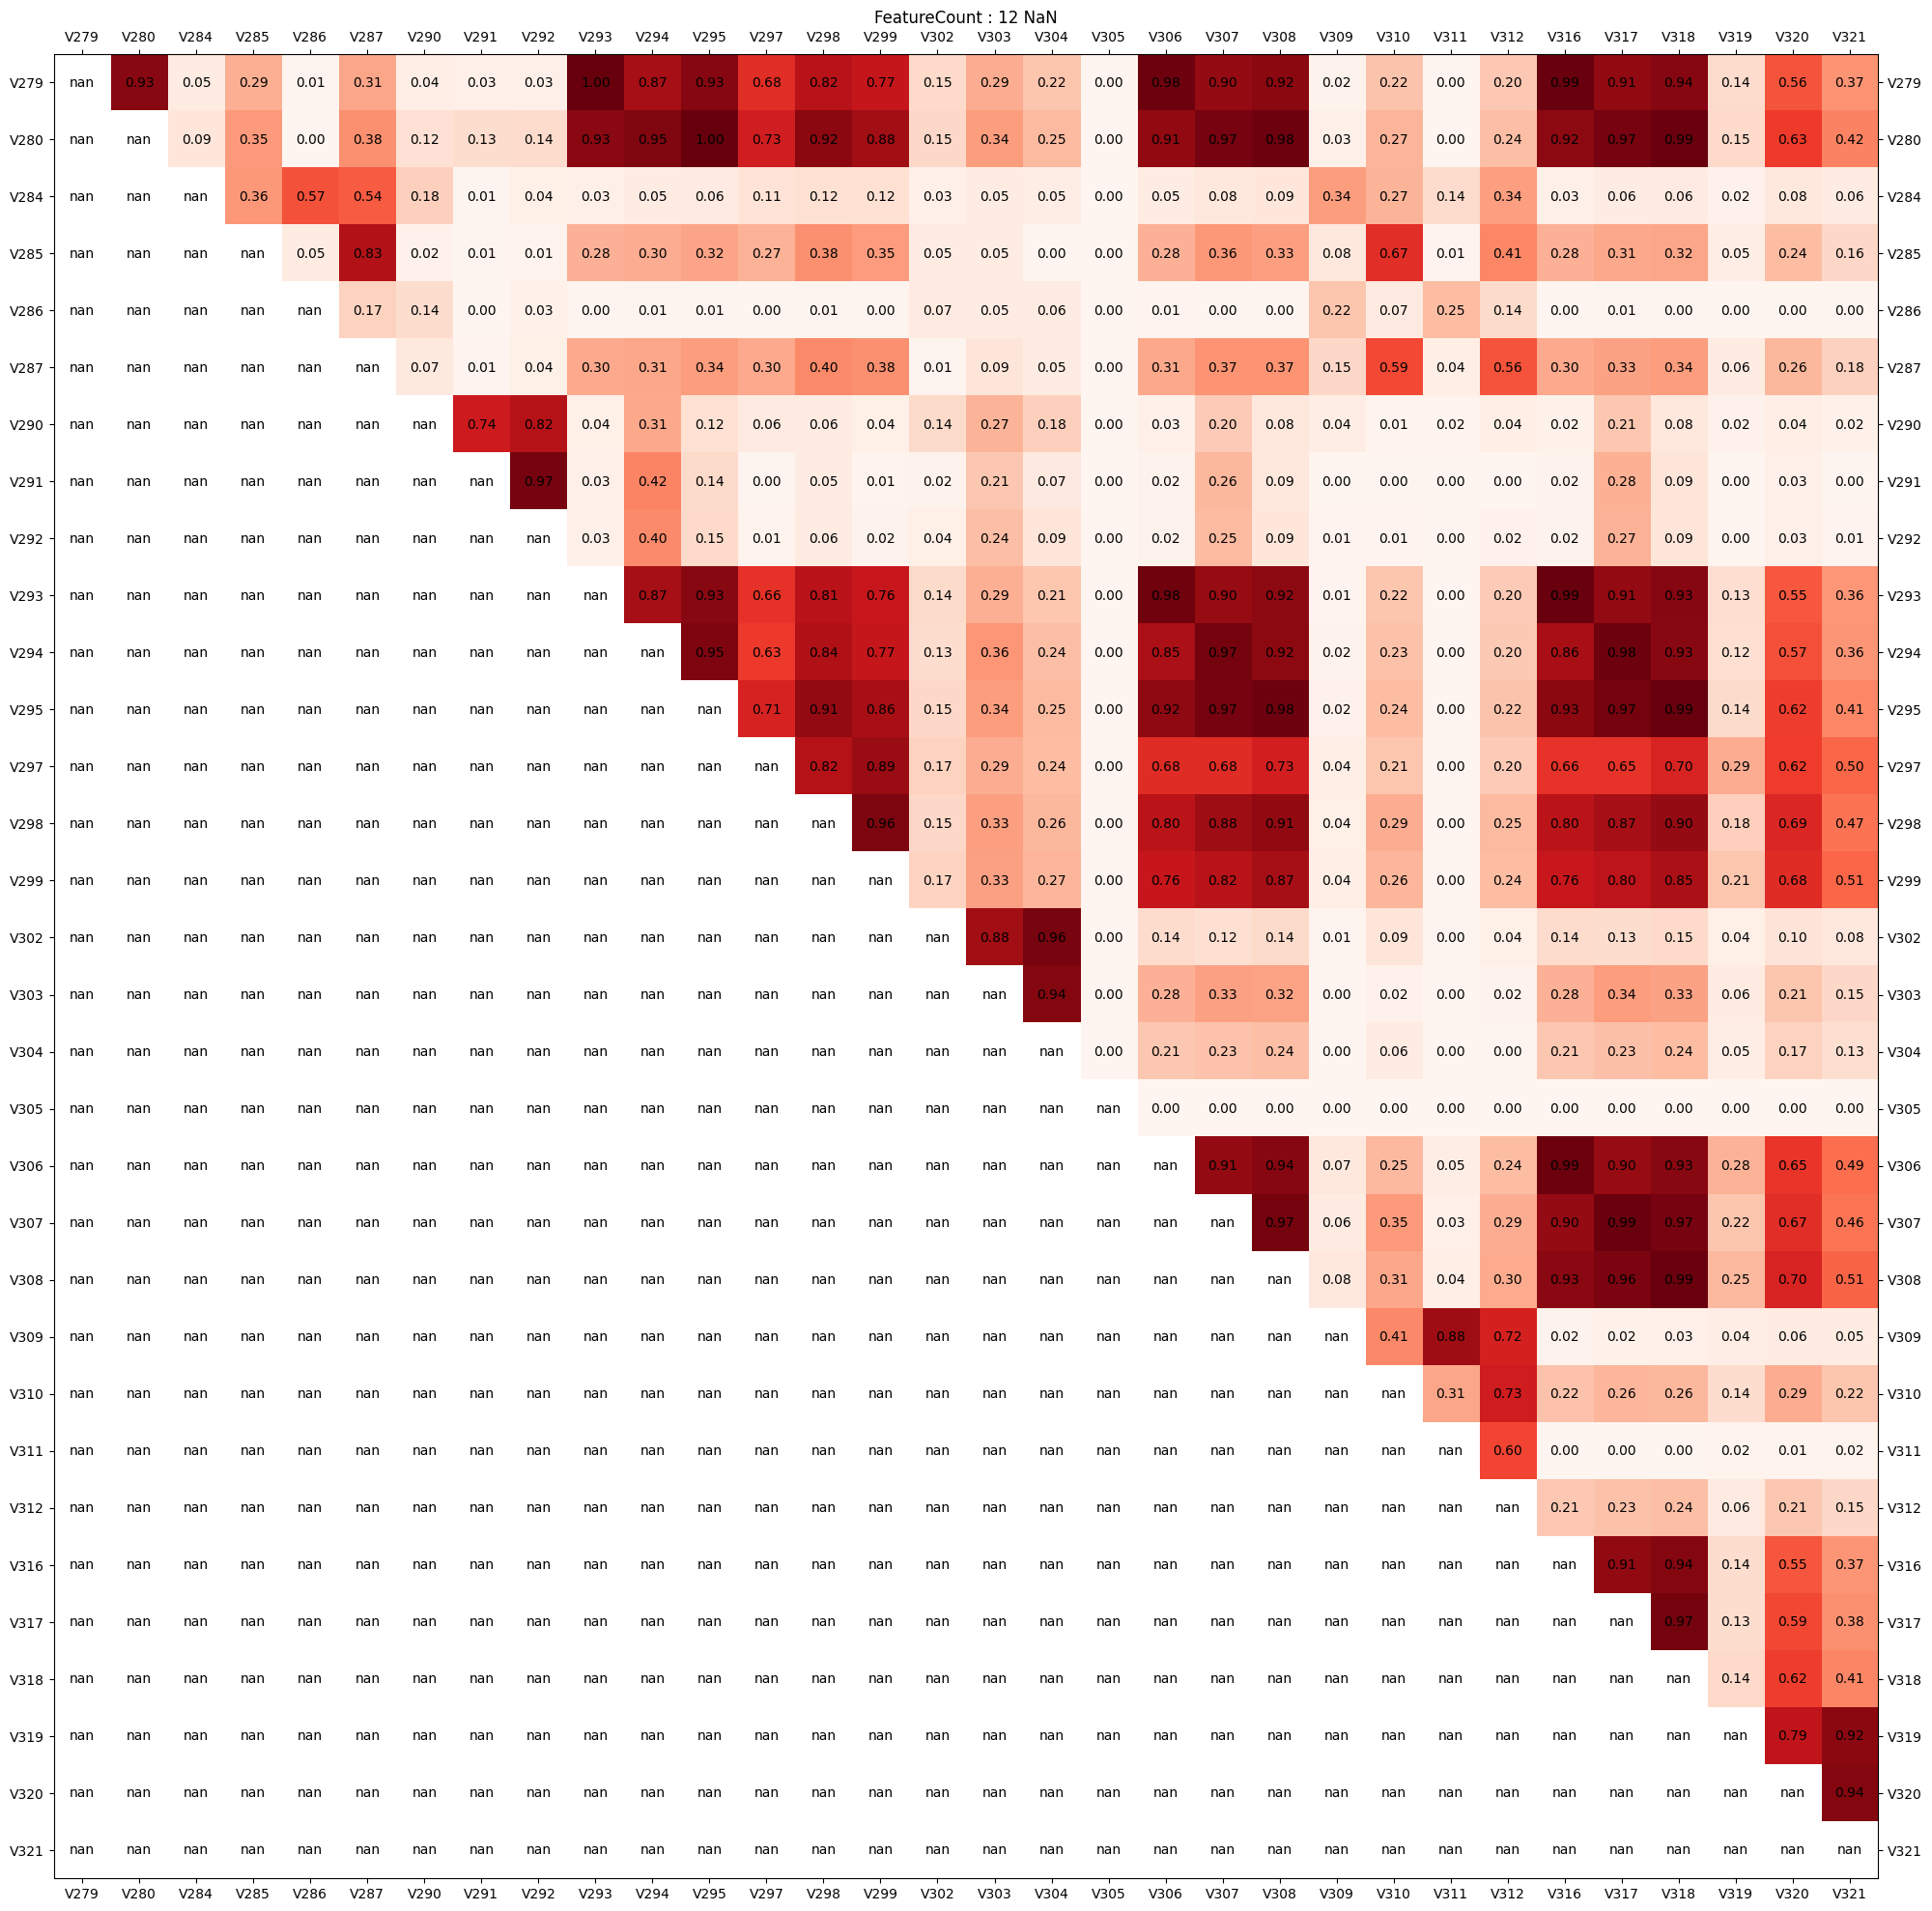

Correlated groups for 12 : [['V279', 'V280', 'V293', 'V294', 'V295', 'V298', 'V299', 'V306', 'V307', 'V308', 'V316', 'V317', 'V318'], ['V284'], ['V285', 'V287'], ['V286'], ['V290'], ['V291', 'V292'], ['V297'], ['V302', 'V303', 'V304'], ['V305'], ['V309', 'V311'], ['V310'], ['V312'], ['V319'], ['V320', 'V321']]

Best for 12 : ['V317', 'V284', 'V285', 'V286', 'V290', 'V292', 'V297', 'V302', 'V305', 'V309', 'V310', 'V312', 'V319', 'V320']
===== End processing group 12 ======


===== Start processing group 314 ======


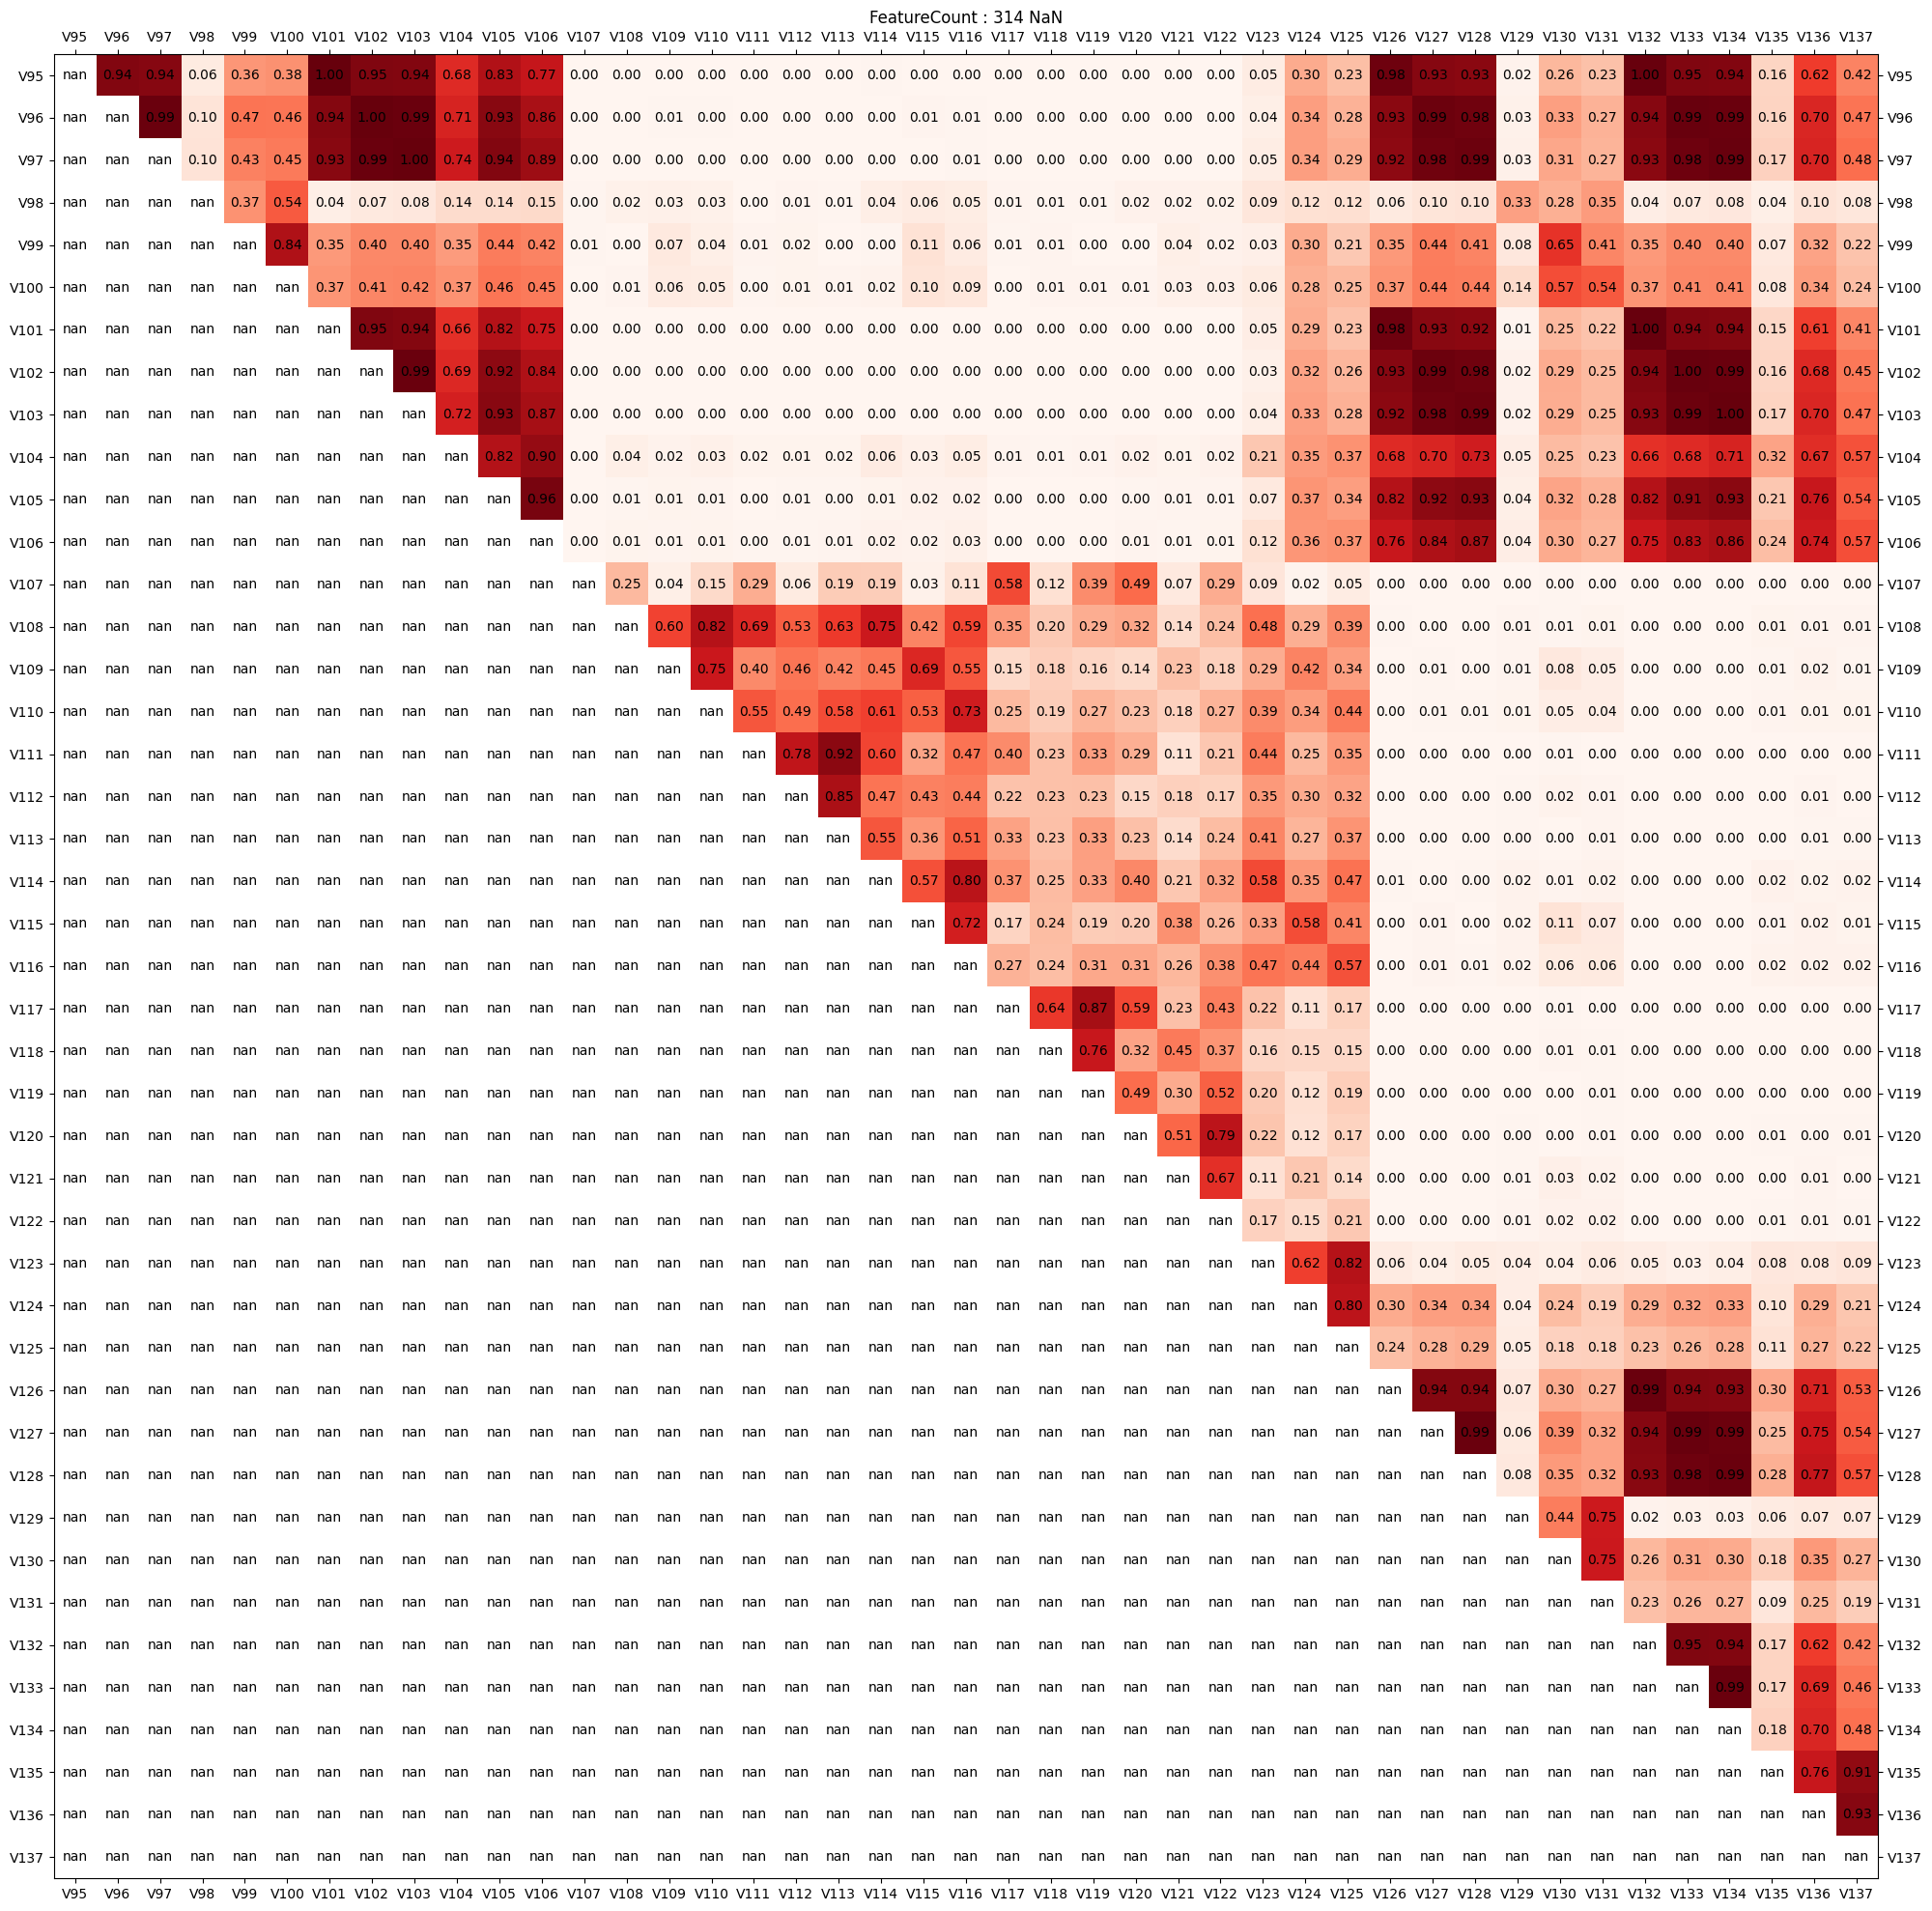

Correlated groups for 314 : [['V95', 'V96', 'V97', 'V101', 'V102', 'V103', 'V105', 'V106', 'V126', 'V127', 'V128', 'V132', 'V133', 'V134'], ['V98'], ['V99', 'V100'], ['V104'], ['V107'], ['V108', 'V110'], ['V109'], ['V111', 'V113'], ['V112'], ['V114', 'V116'], ['V115'], ['V117', 'V119'], ['V118'], ['V120'], ['V121'], ['V122'], ['V123', 'V125'], ['V124'], ['V129'], ['V130'], ['V131'], ['V135'], ['V136', 'V137']]

Best for 314 : ['V133', 'V98', 'V100', 'V104', 'V107', 'V110', 'V109', 'V113', 'V112', 'V114', 'V115', 'V119', 'V118', 'V120', 'V121', 'V122', 'V123', 'V124', 'V129', 'V130', 'V131', 'V135', 'V136']
===== End processing group 314 ======


===== Start processing group 1269 ======


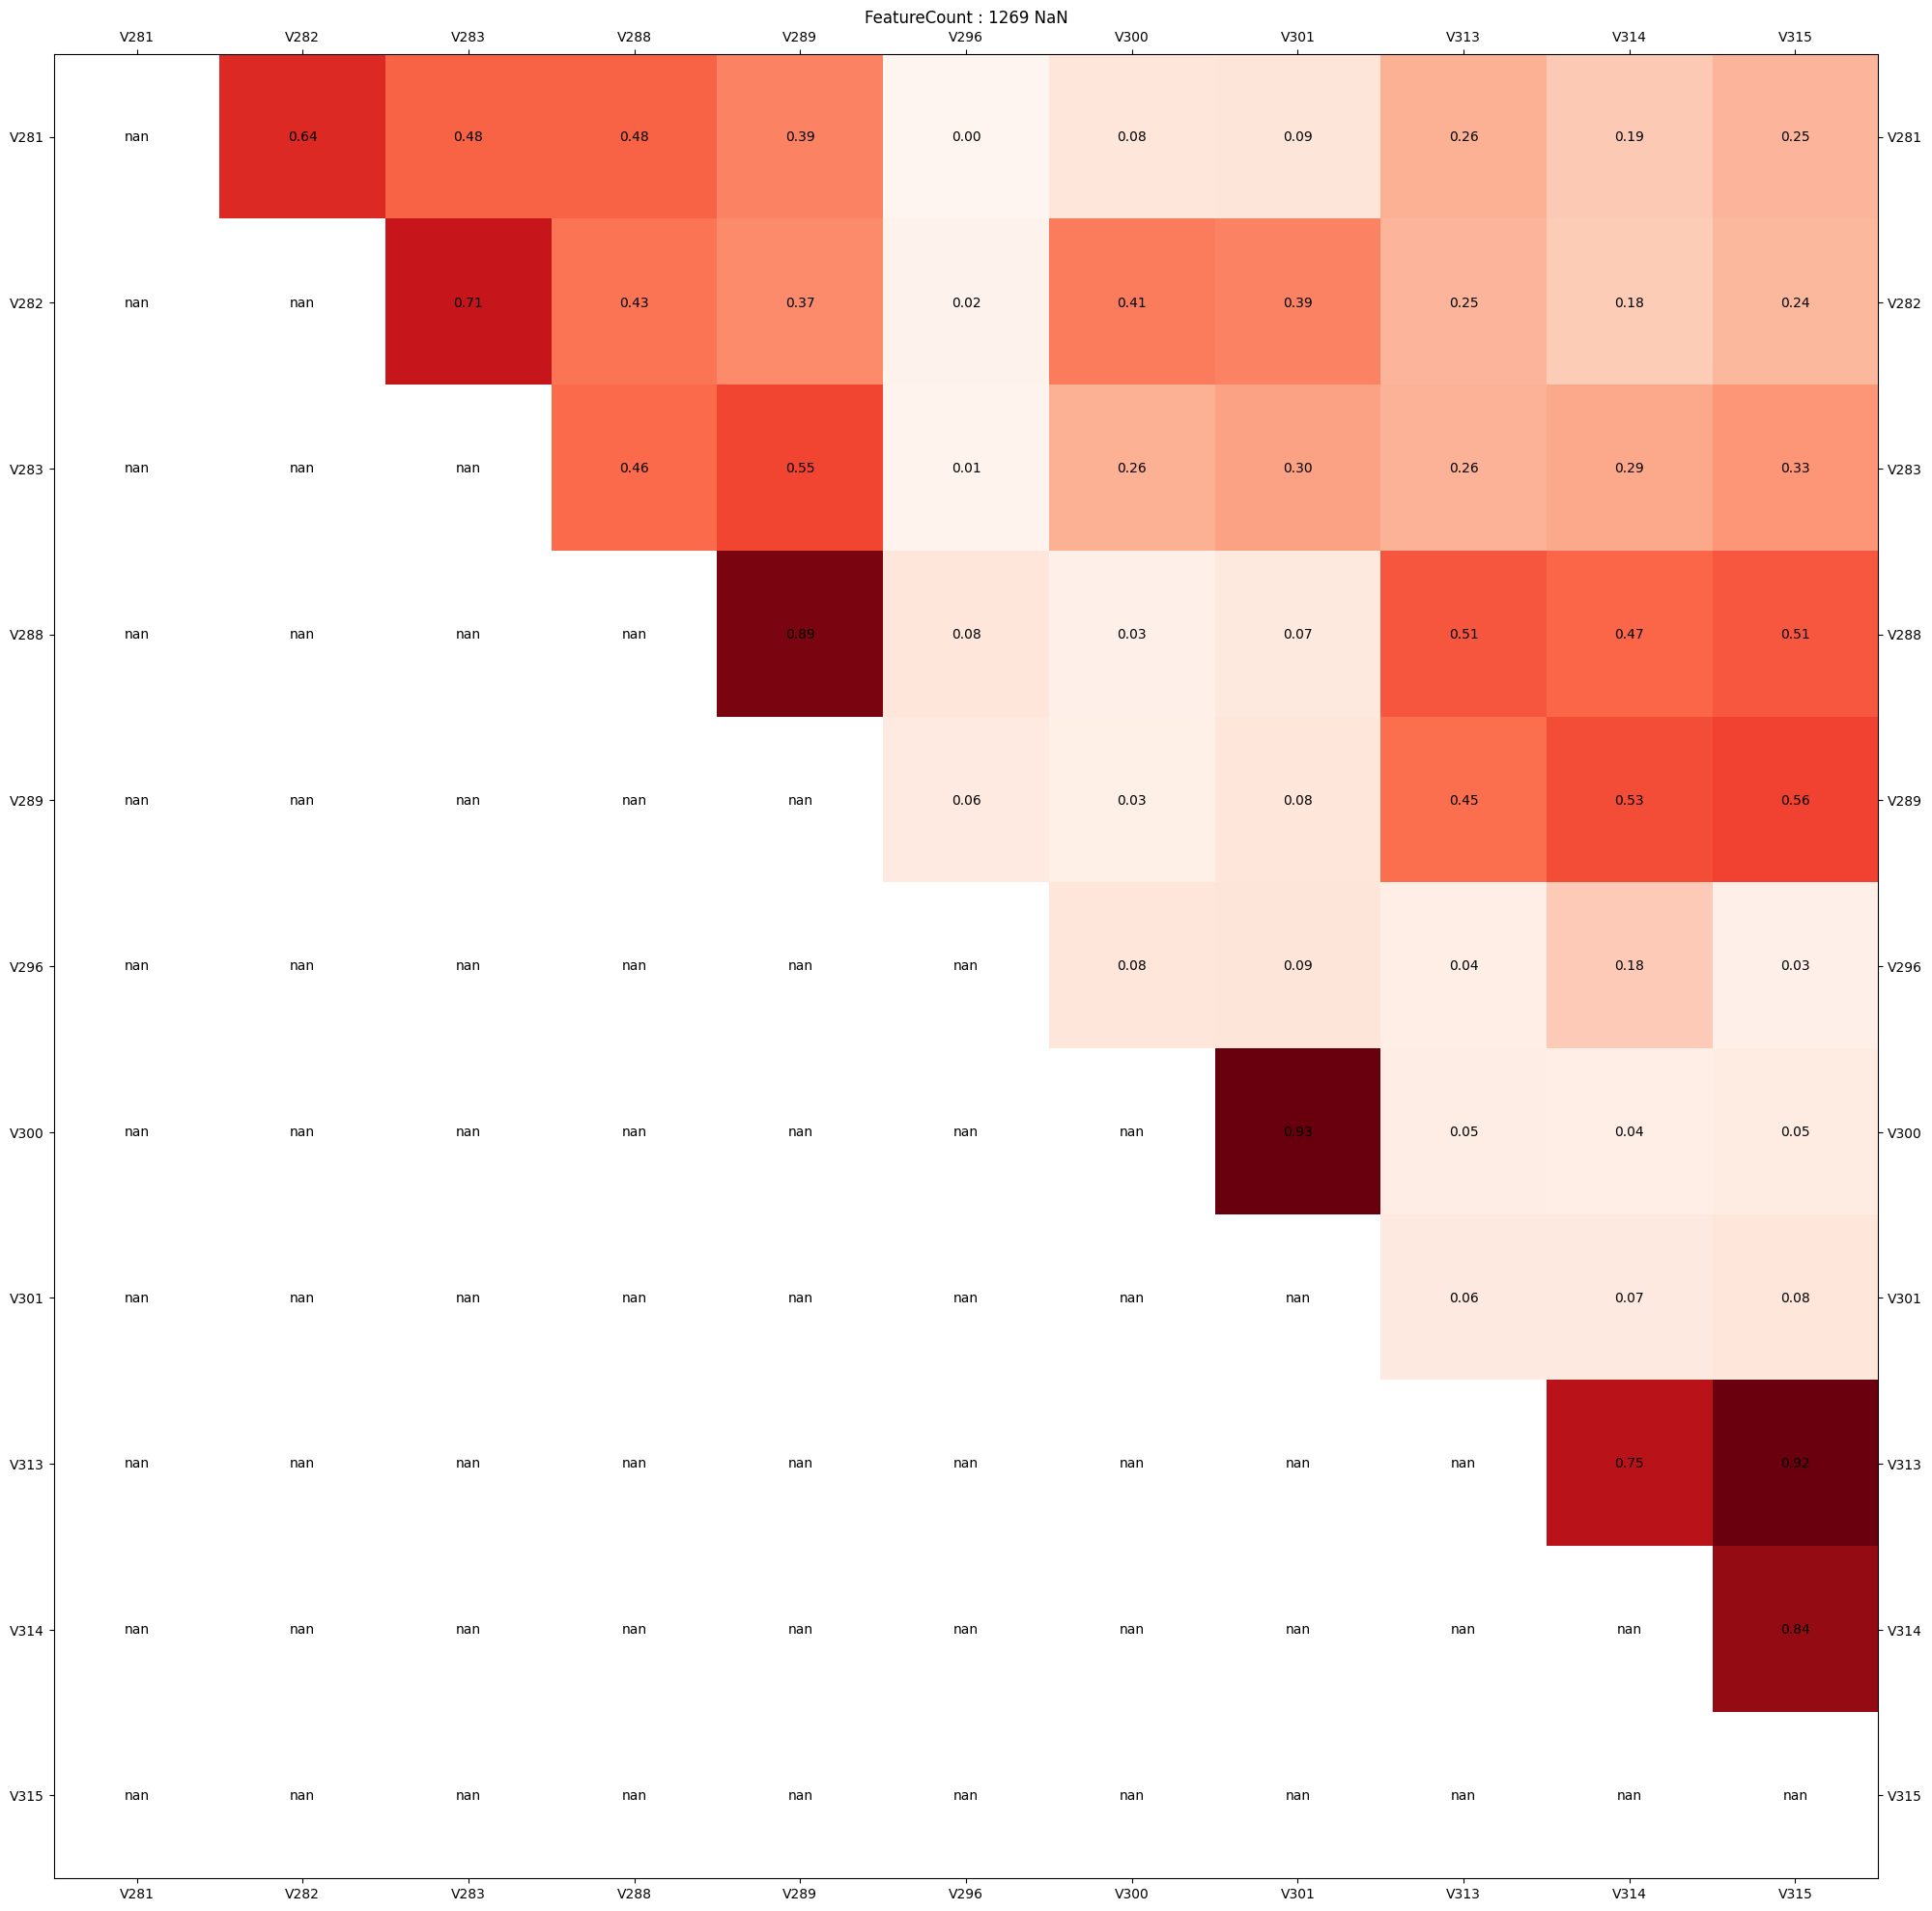

Correlated groups for 1269 : [['V281'], ['V282'], ['V283'], ['V288', 'V289'], ['V296'], ['V300', 'V301'], ['V313', 'V315'], ['V314']]

Best for 1269 : ['V281', 'V282', 'V283', 'V288', 'V296', 'V301', 'V315', 'V314']
===== End processing group 1269 ======


===== Start processing group 76073 ======


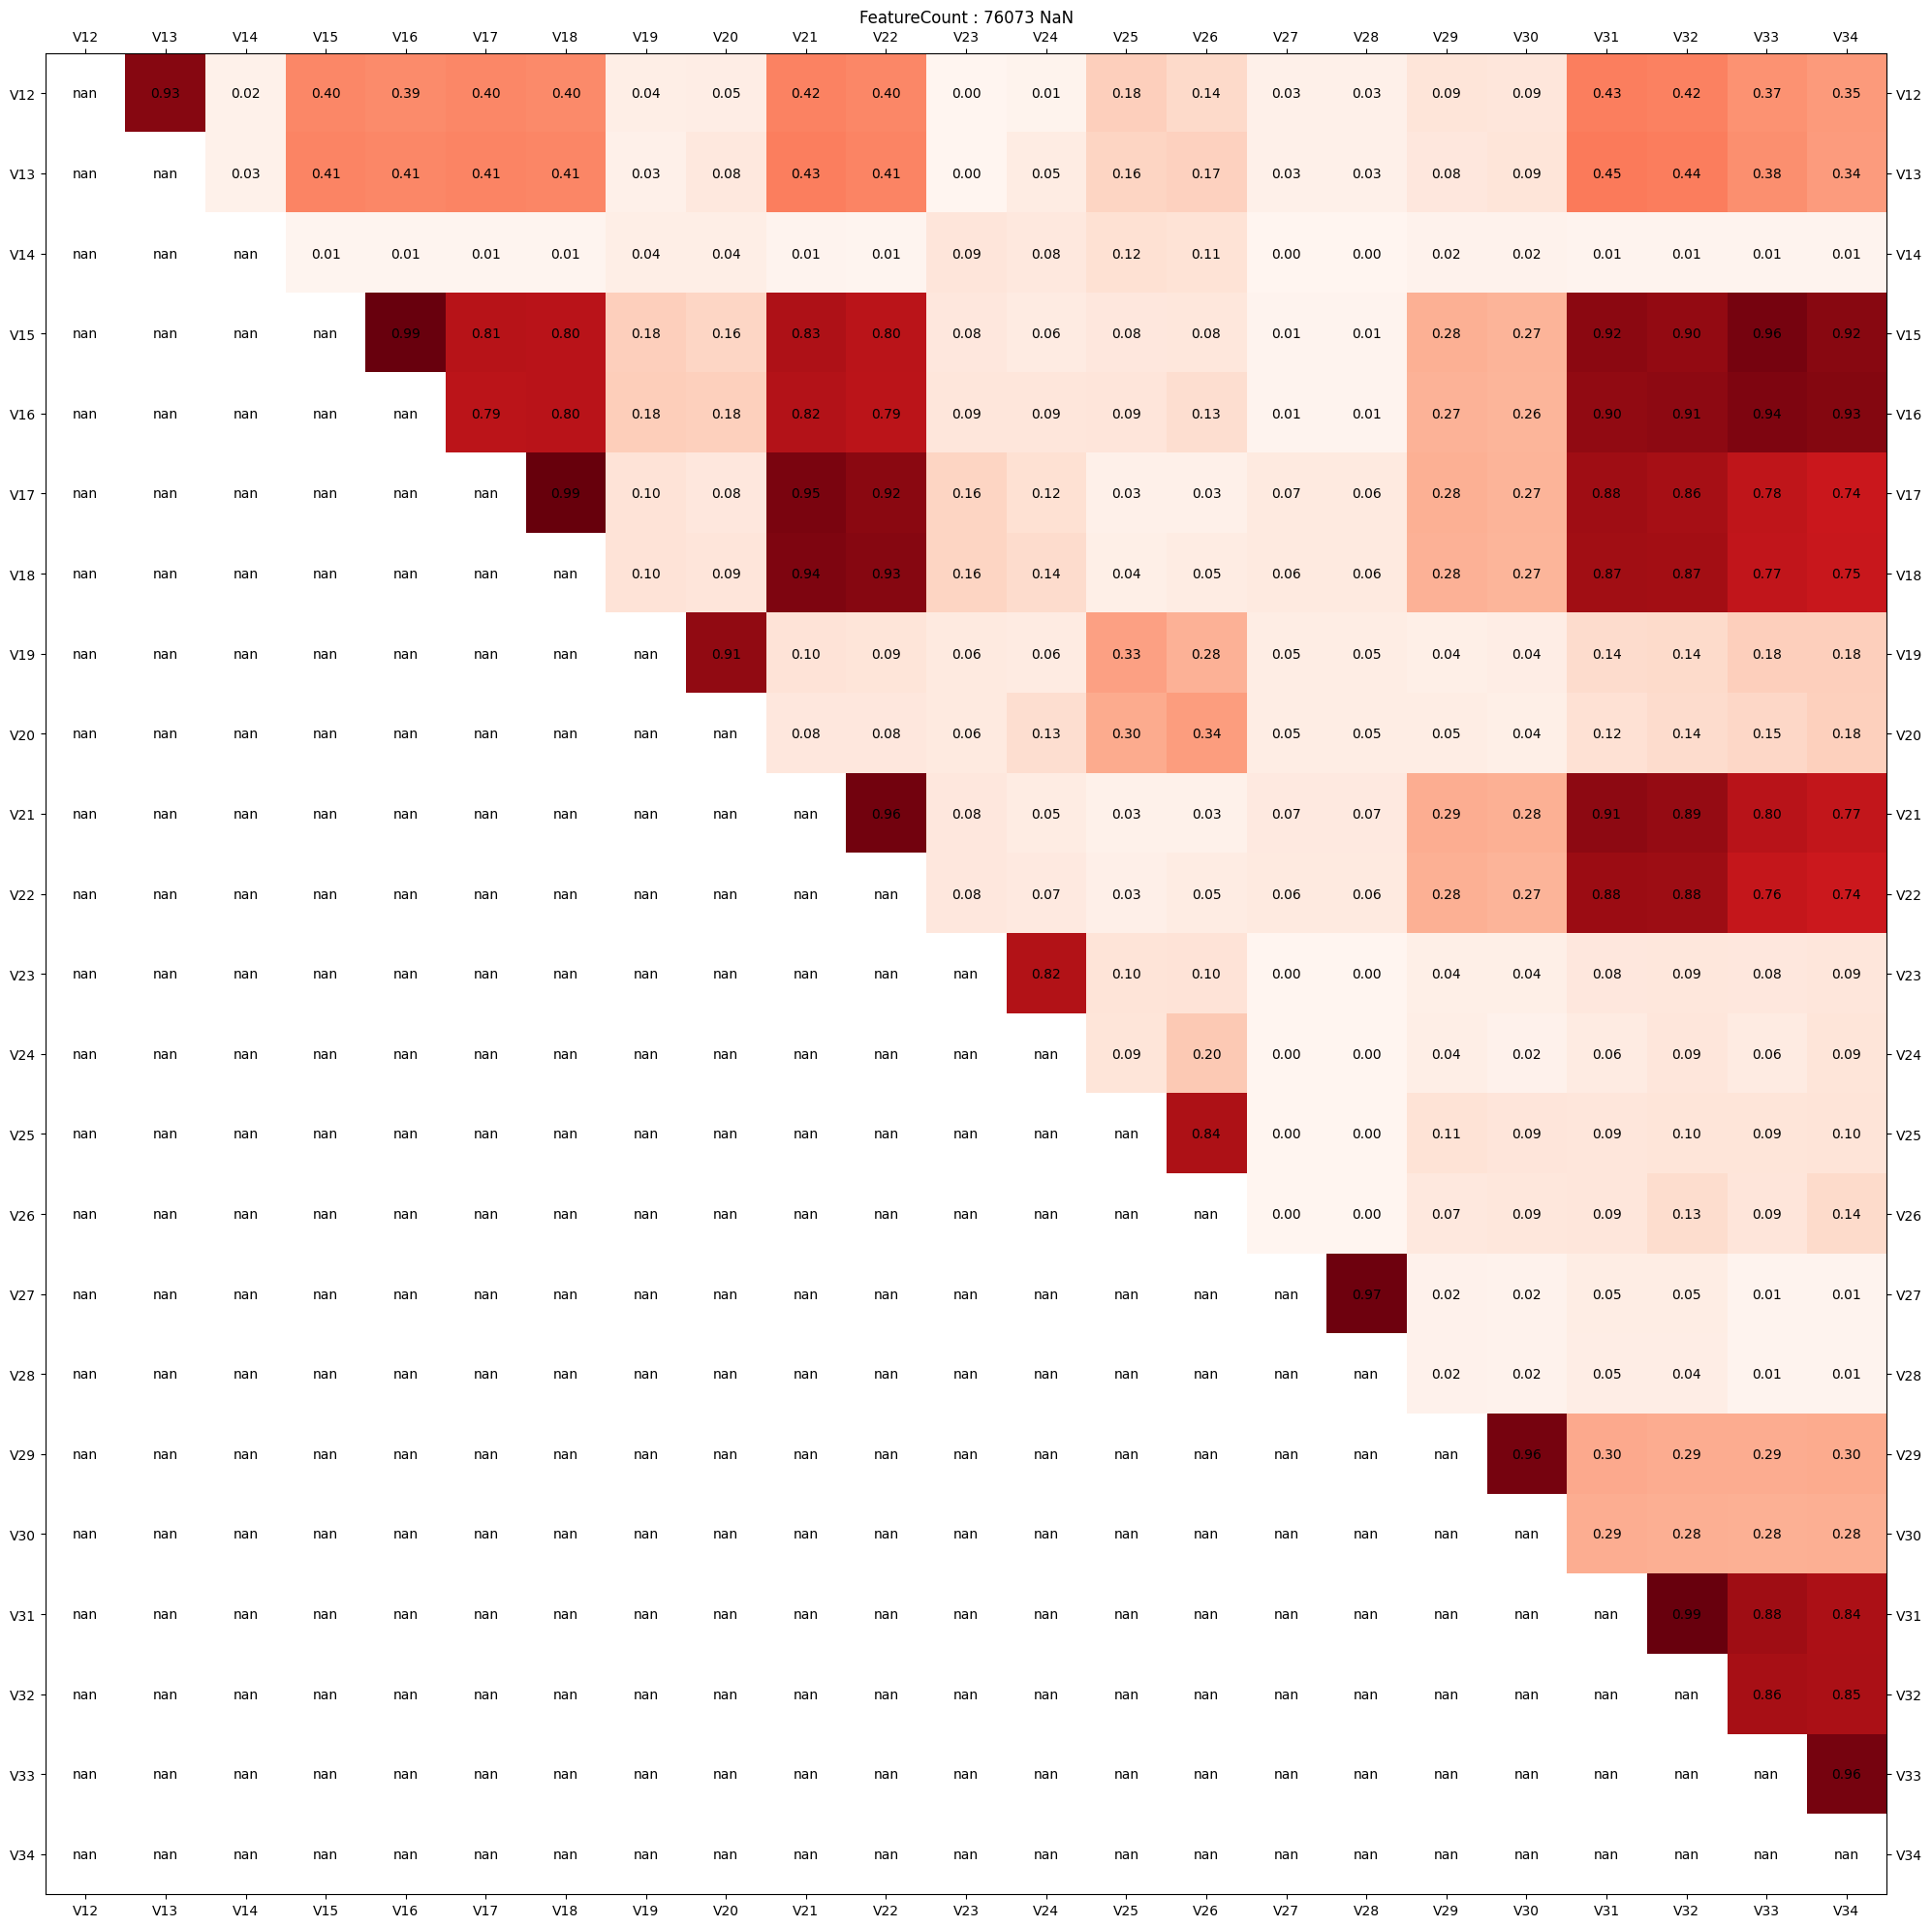

Correlated groups for 76073 : [['V12', 'V13'], ['V14'], ['V15', 'V16', 'V17', 'V18', 'V21', 'V22', 'V31', 'V32', 'V33', 'V34'], ['V19', 'V20'], ['V23', 'V24'], ['V25', 'V26'], ['V27', 'V28'], ['V29', 'V30']]

Best for 76073 : ['V13', 'V14', 'V34', 'V20', 'V23', 'V26', 'V28', 'V29']
===== End processing group 76073 ======


===== Start processing group 77096 ======


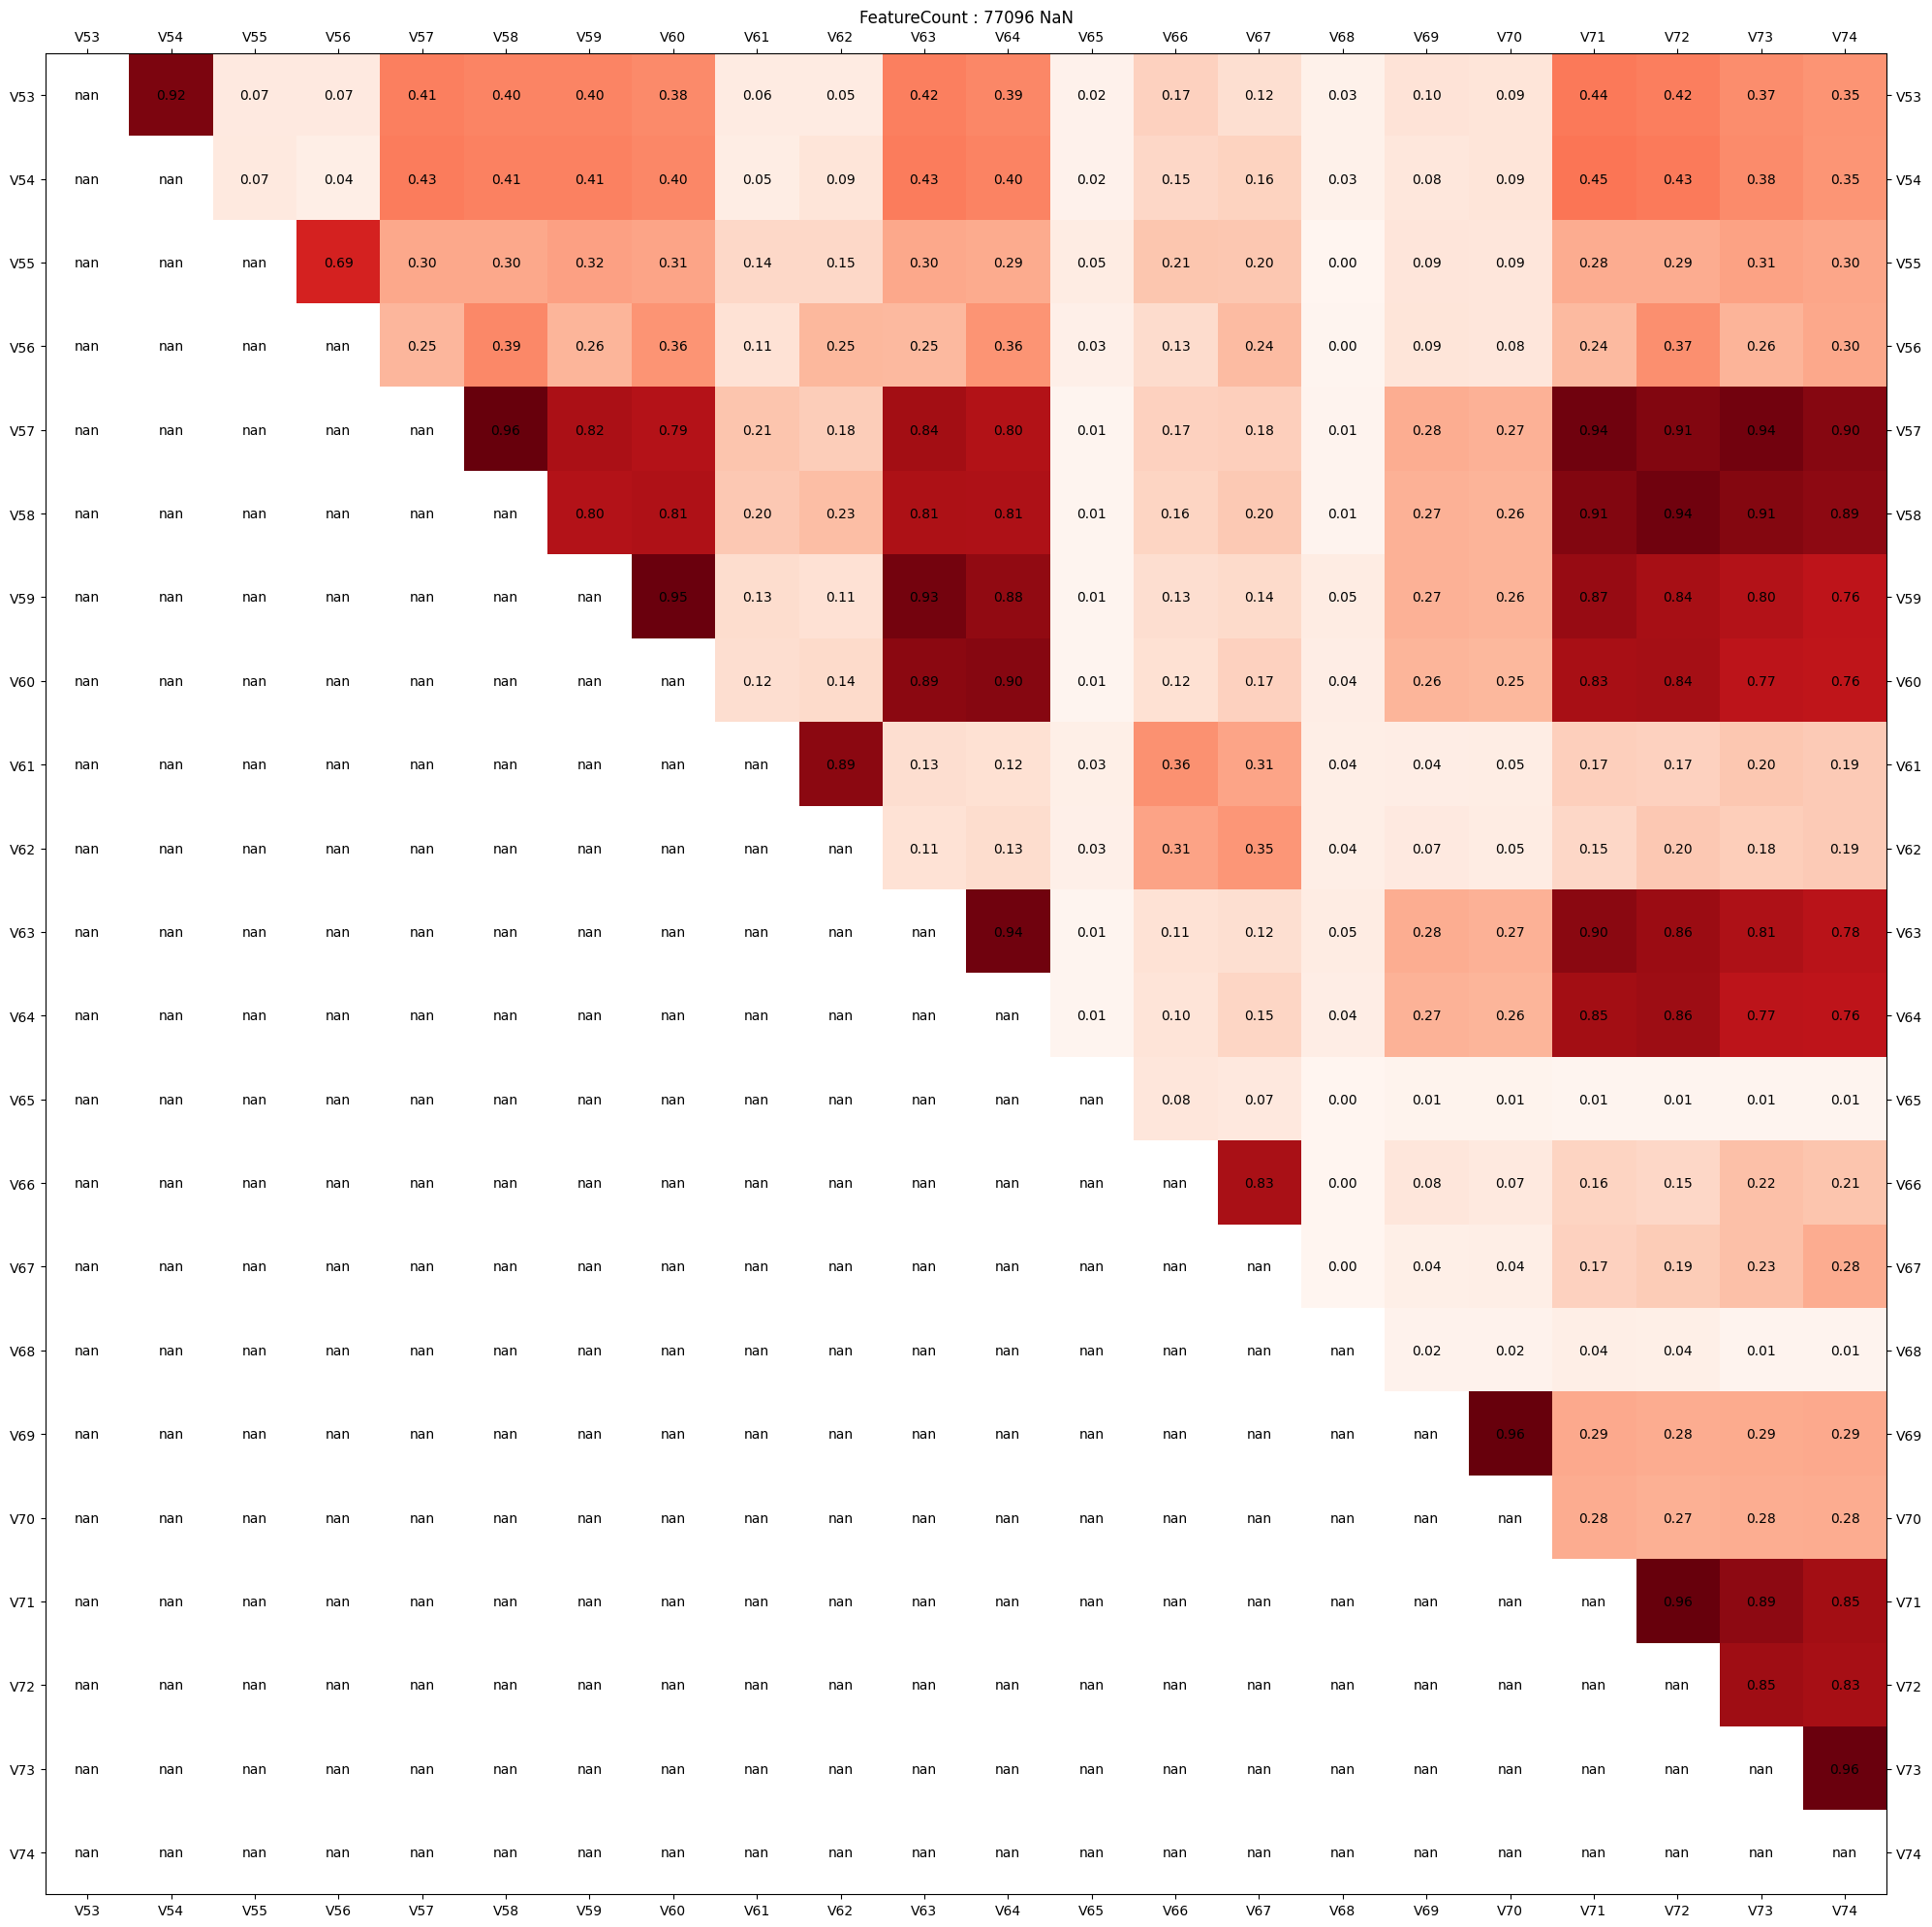

Correlated groups for 77096 : [['V53', 'V54'], ['V55'], ['V56'], ['V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V71', 'V72', 'V73', 'V74'], ['V61', 'V62'], ['V65'], ['V66', 'V67'], ['V68'], ['V69', 'V70']]

Best for 77096 : ['V54', 'V55', 'V56', 'V74', 'V62', 'V65', 'V67', 'V68', 'V69']
===== End processing group 77096 ======


===== Start processing group 89164 ======


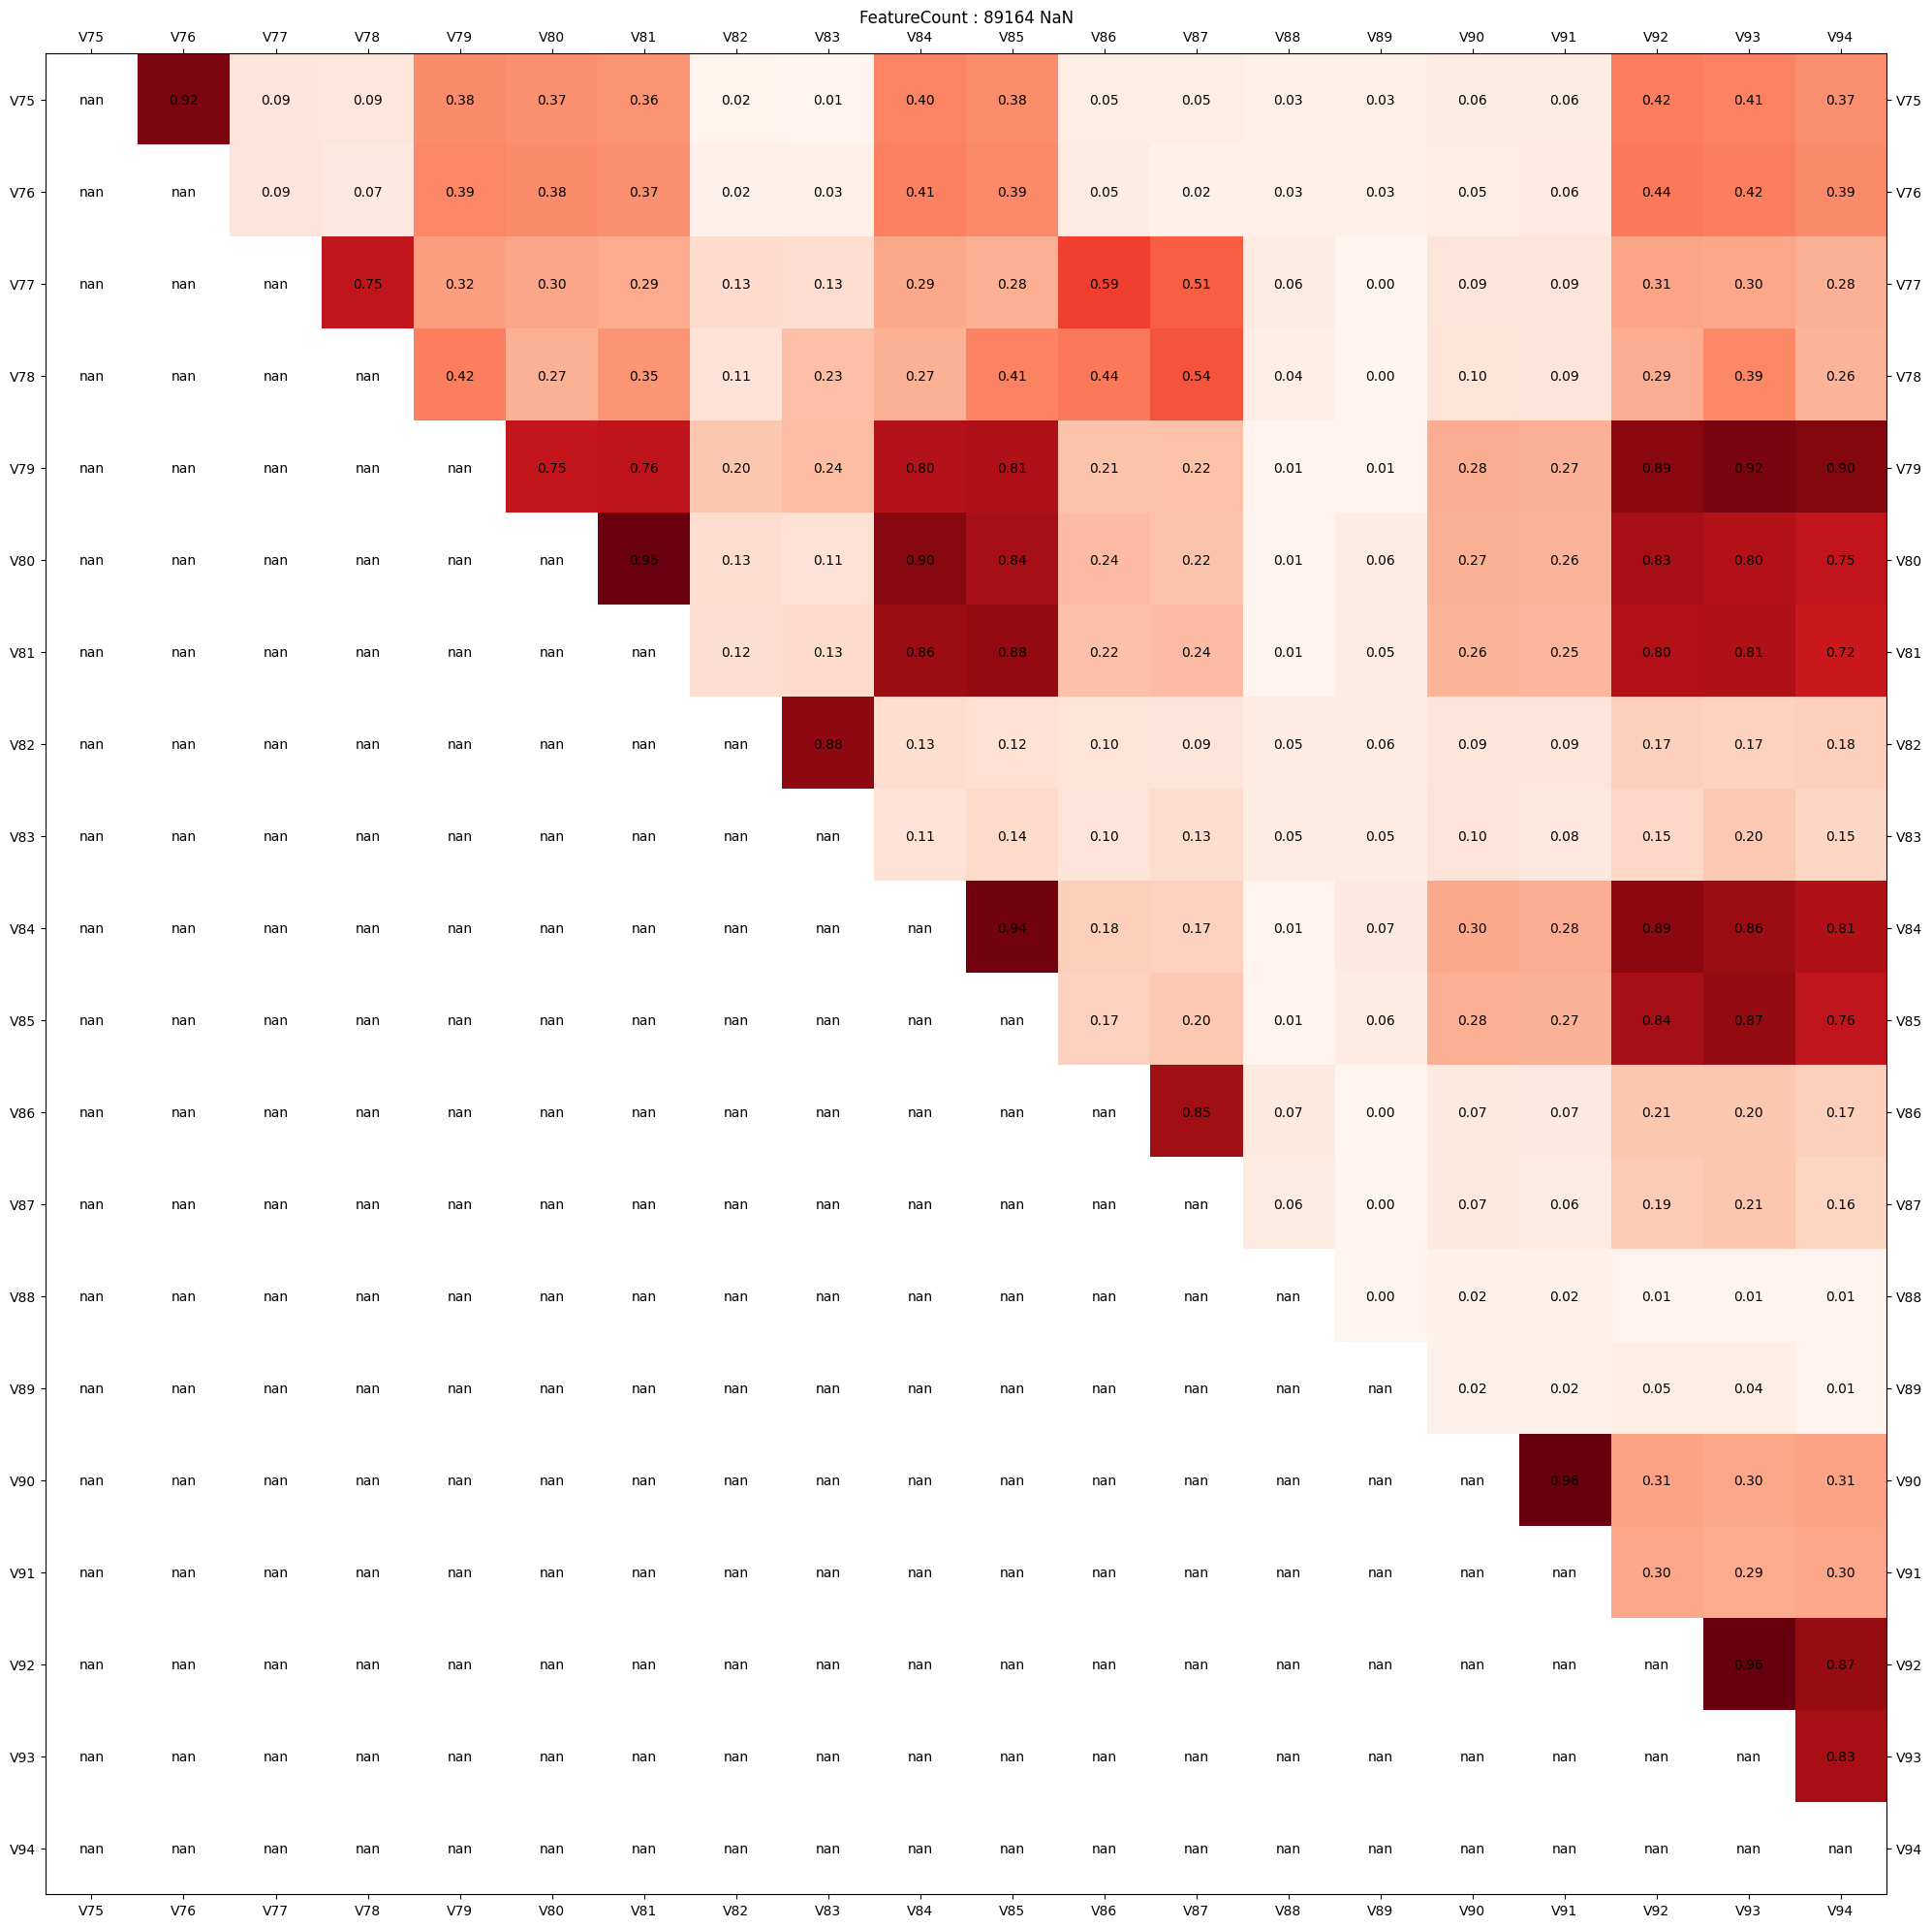

Correlated groups for 89164 : [['V75', 'V76'], ['V77'], ['V78'], ['V79', 'V94'], ['V80', 'V81', 'V84', 'V85', 'V92', 'V93'], ['V82', 'V83'], ['V86', 'V87'], ['V88'], ['V89'], ['V90', 'V91']]

Best for 89164 : ['V76', 'V77', 'V78', 'V79', 'V93', 'V83', 'V86', 'V88', 'V89', 'V90']
===== End processing group 89164 ======


===== Start processing group 168969 ======


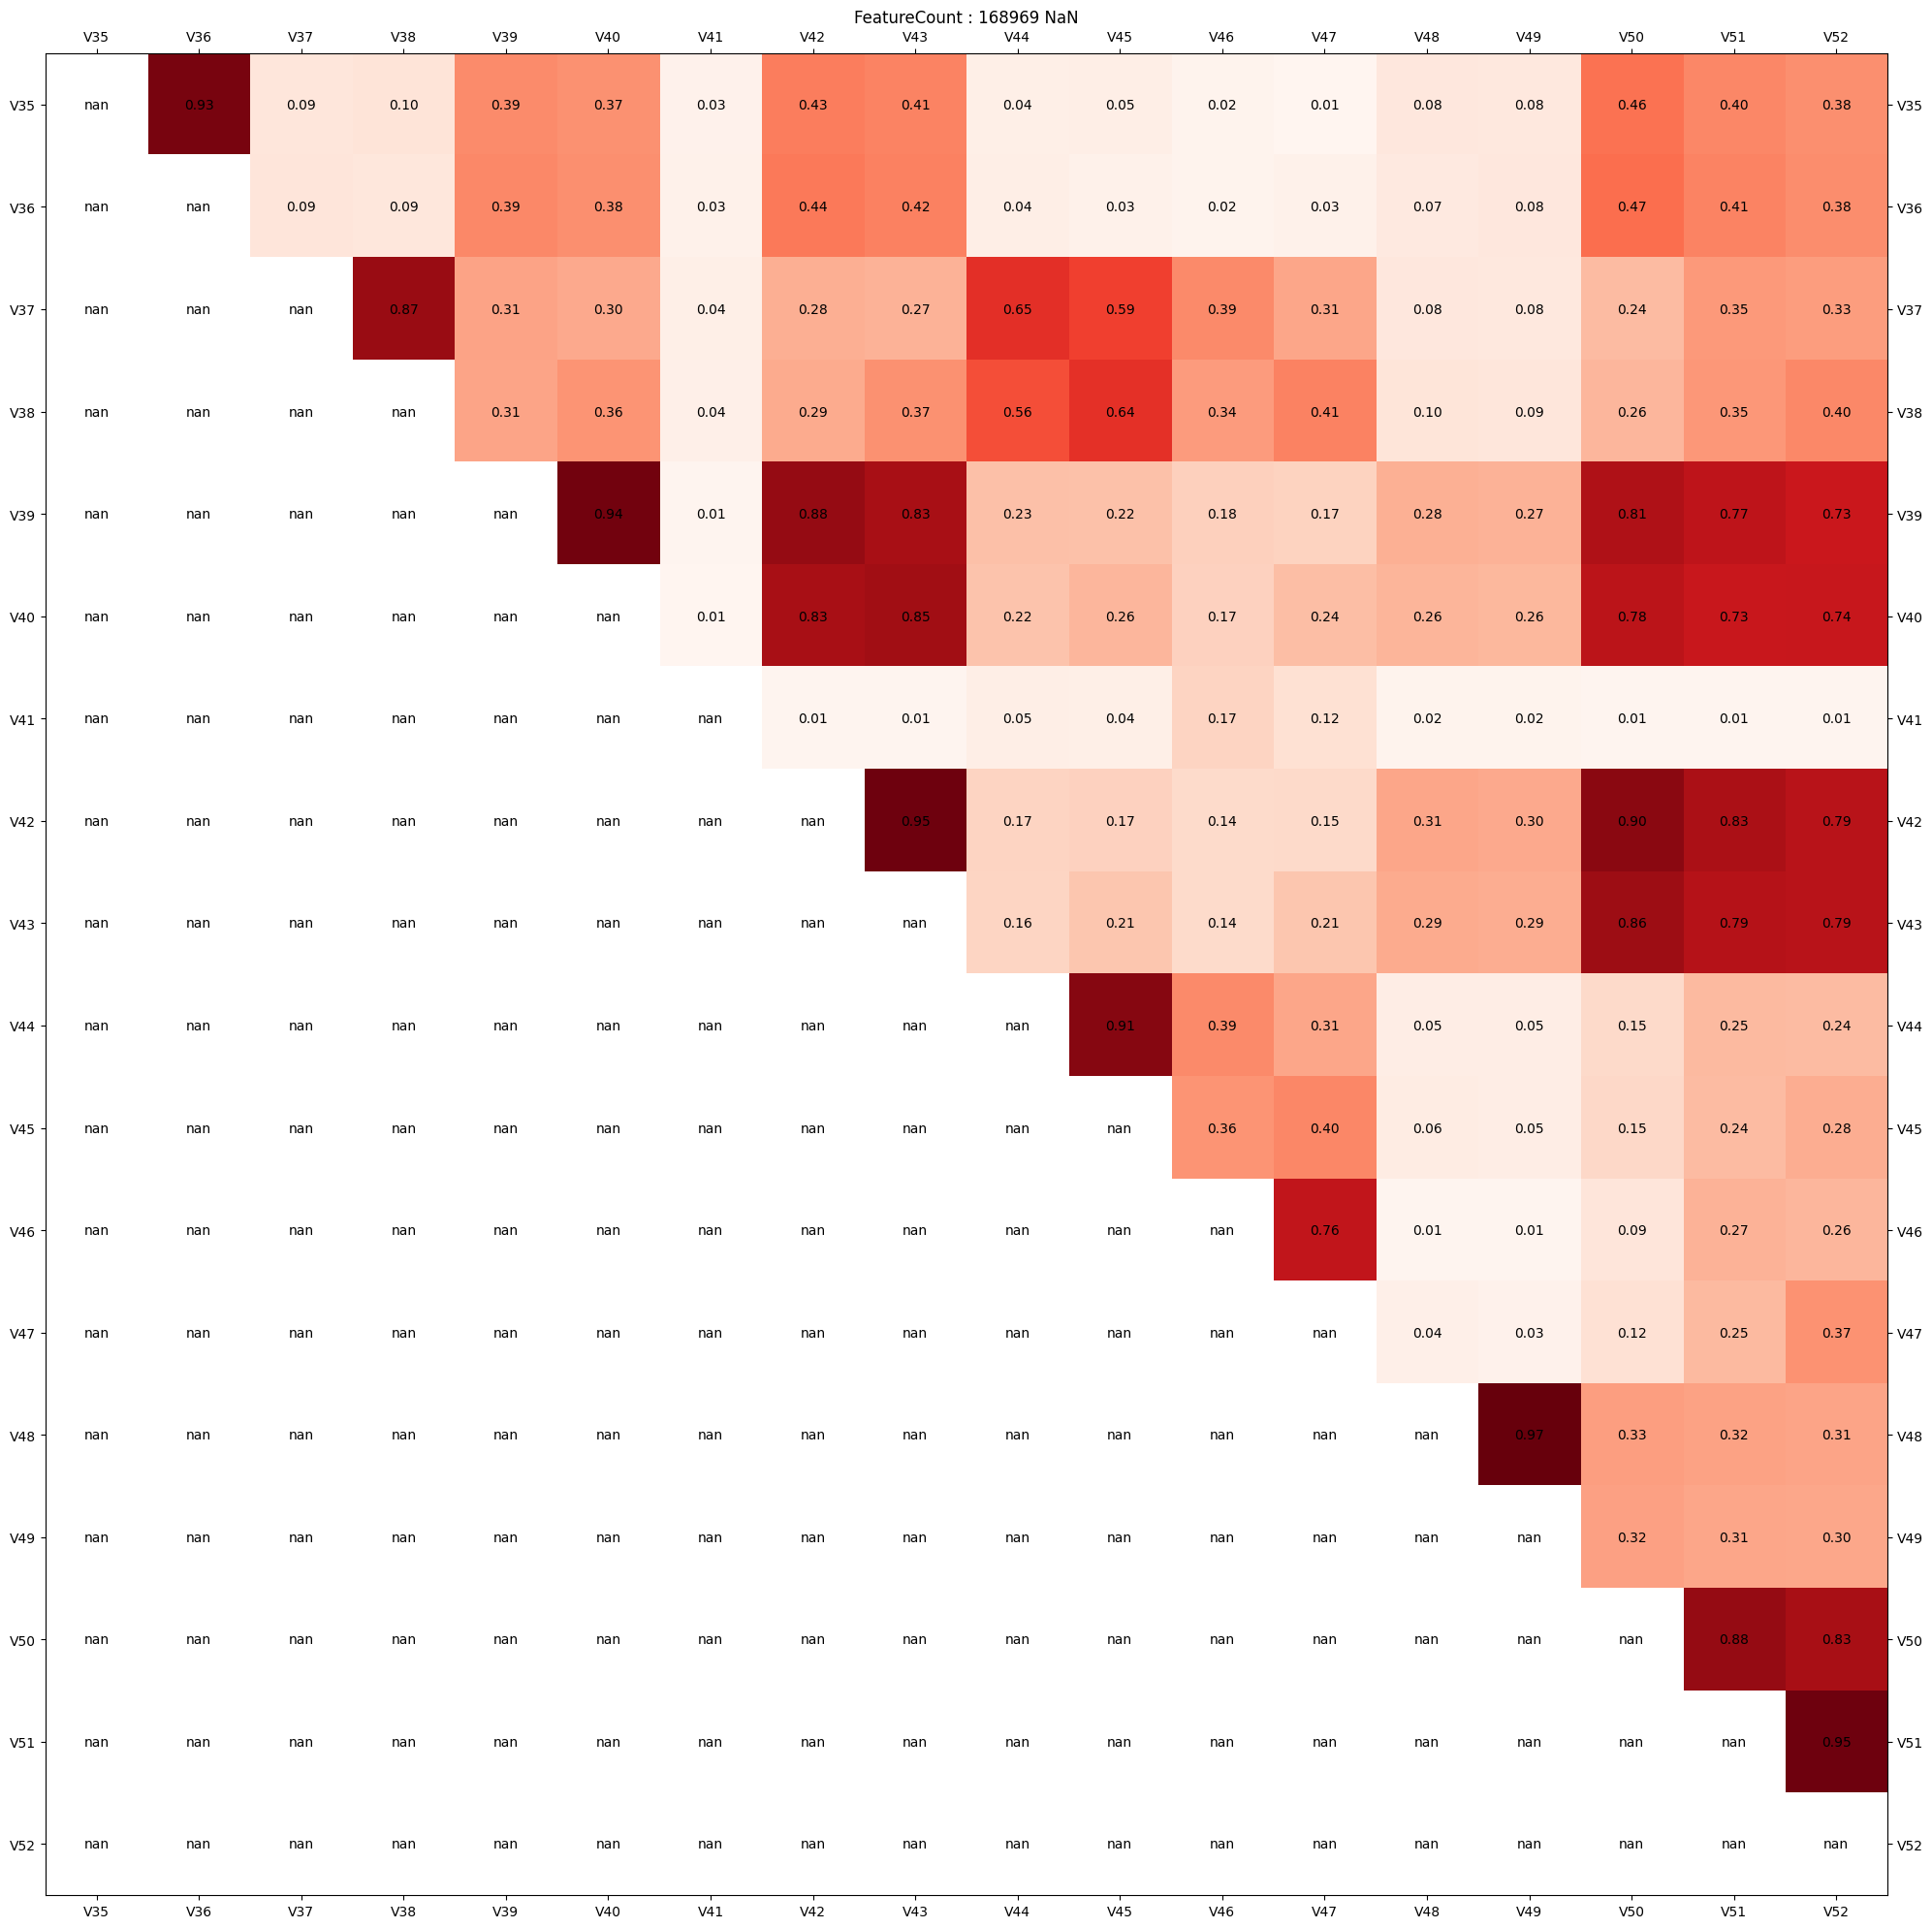

Correlated groups for 168969 : [['V35', 'V36'], ['V37', 'V38'], ['V39', 'V40', 'V42', 'V43', 'V50', 'V51', 'V52'], ['V41'], ['V44', 'V45'], ['V46'], ['V47'], ['V48', 'V49']]

Best for 168969 : ['V36', 'V38', 'V52', 'V41', 'V45', 'V46', 'V47', 'V48']
===== End processing group 168969 ======


===== Start processing group 279287 ======


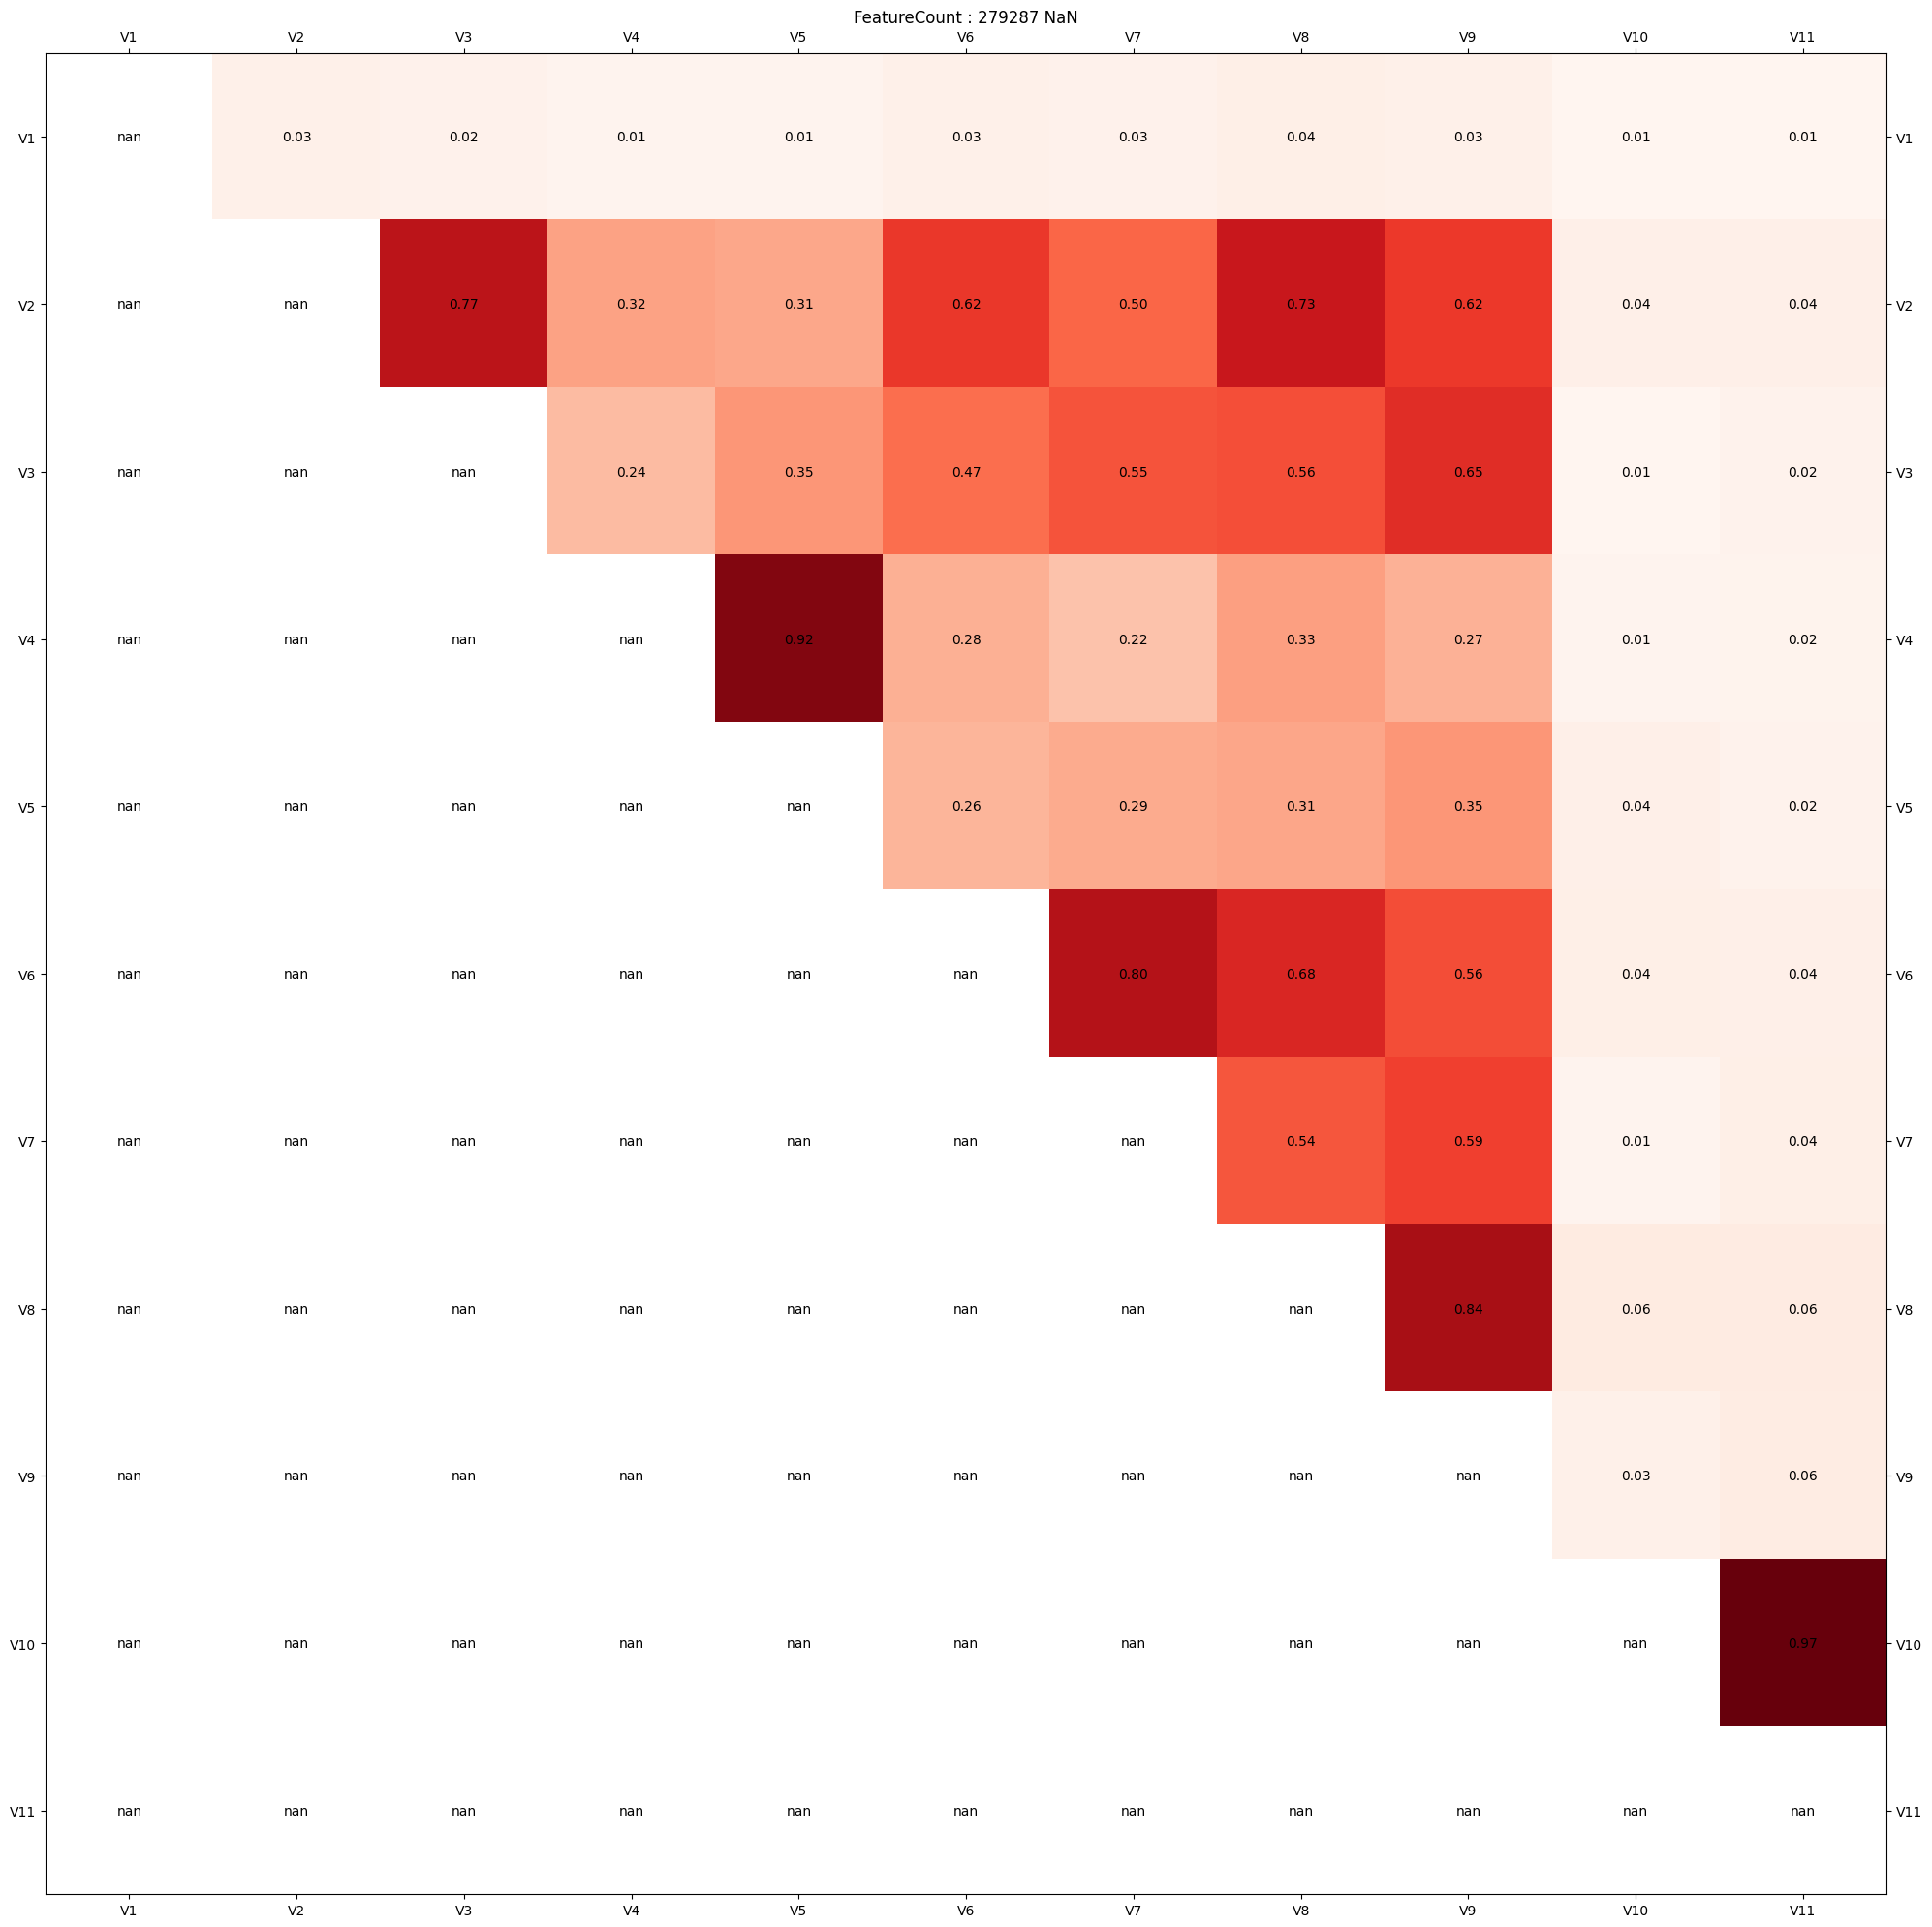

Correlated groups for 279287 : [['V1'], ['V2'], ['V3'], ['V4', 'V5'], ['V6'], ['V7'], ['V8', 'V9'], ['V10', 'V11']]

Best for 279287 : ['V1', 'V2', 'V3', 'V5', 'V6', 'V7', 'V9', 'V10']
===== End processing group 279287 ======


===== Start processing group 449124 ======


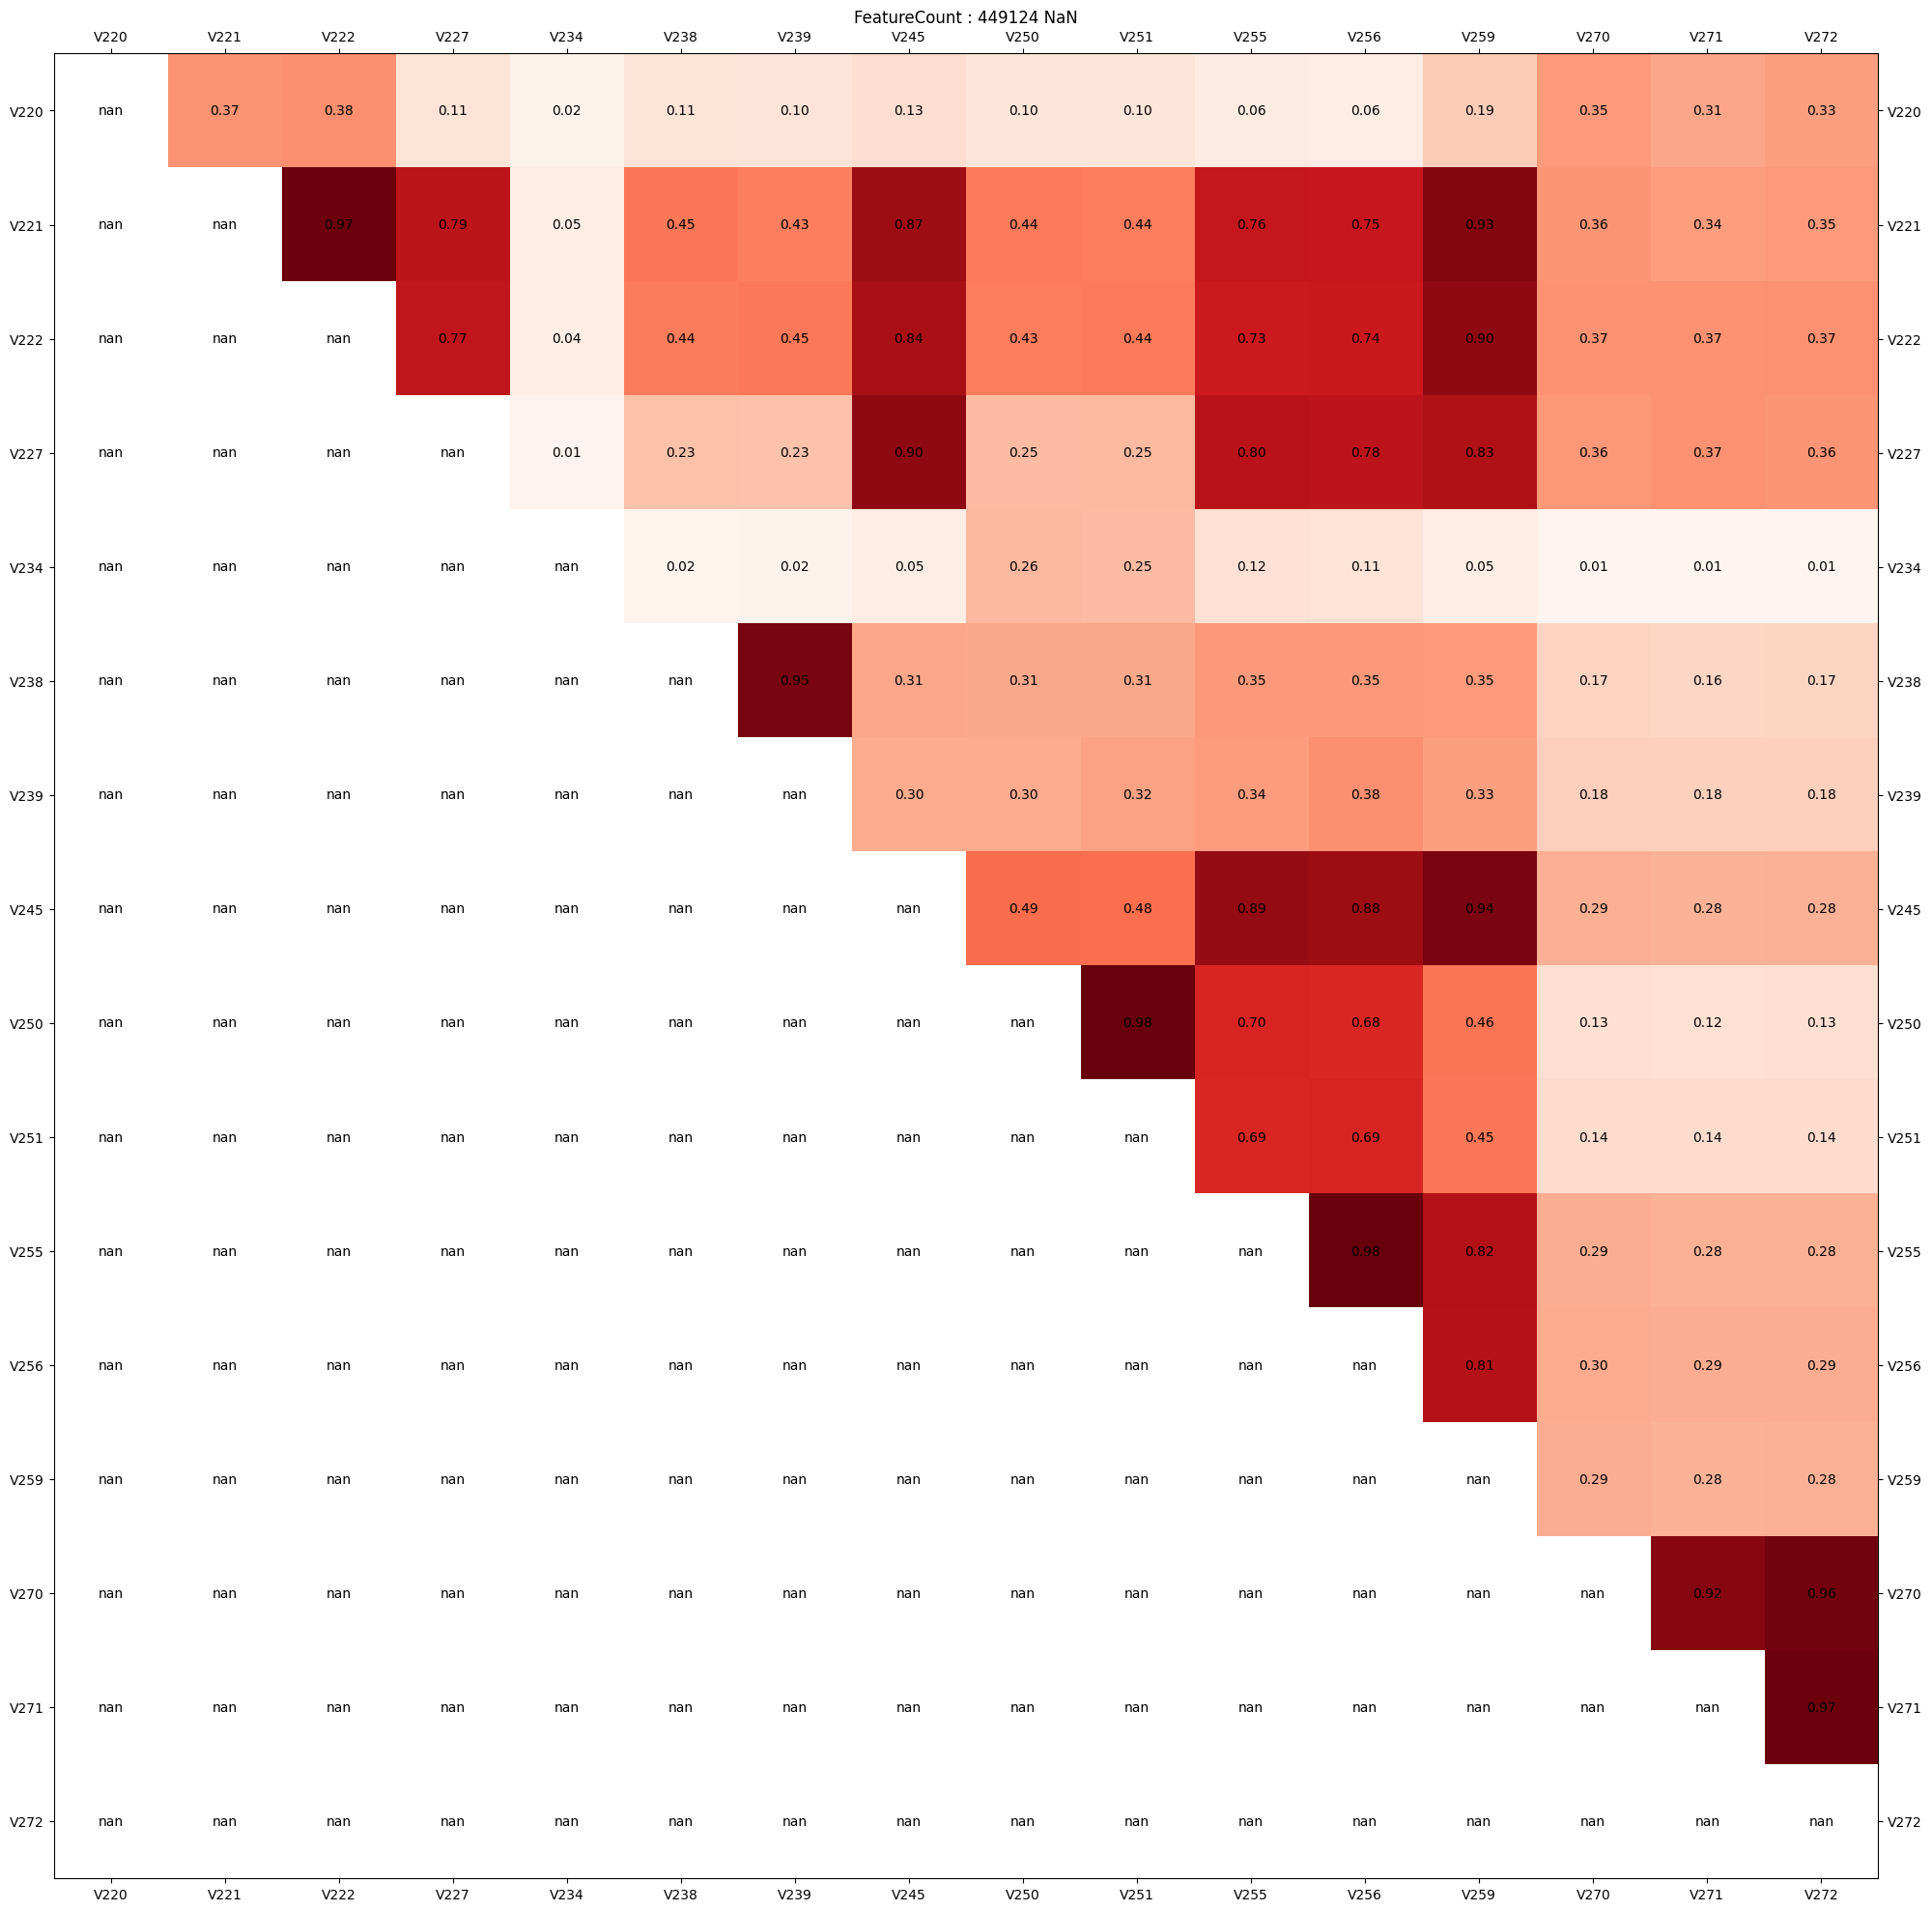

Correlated groups for 449124 : [['V220'], ['V221', 'V222'], ['V227', 'V245', 'V255', 'V256', 'V259'], ['V234'], ['V238', 'V239'], ['V250', 'V251'], ['V270', 'V271', 'V272']]

Best for 449124 : ['V220', 'V222', 'V259', 'V234', 'V239', 'V250', 'V271']
===== End processing group 449124 ======


===== Start processing group 450721 ======


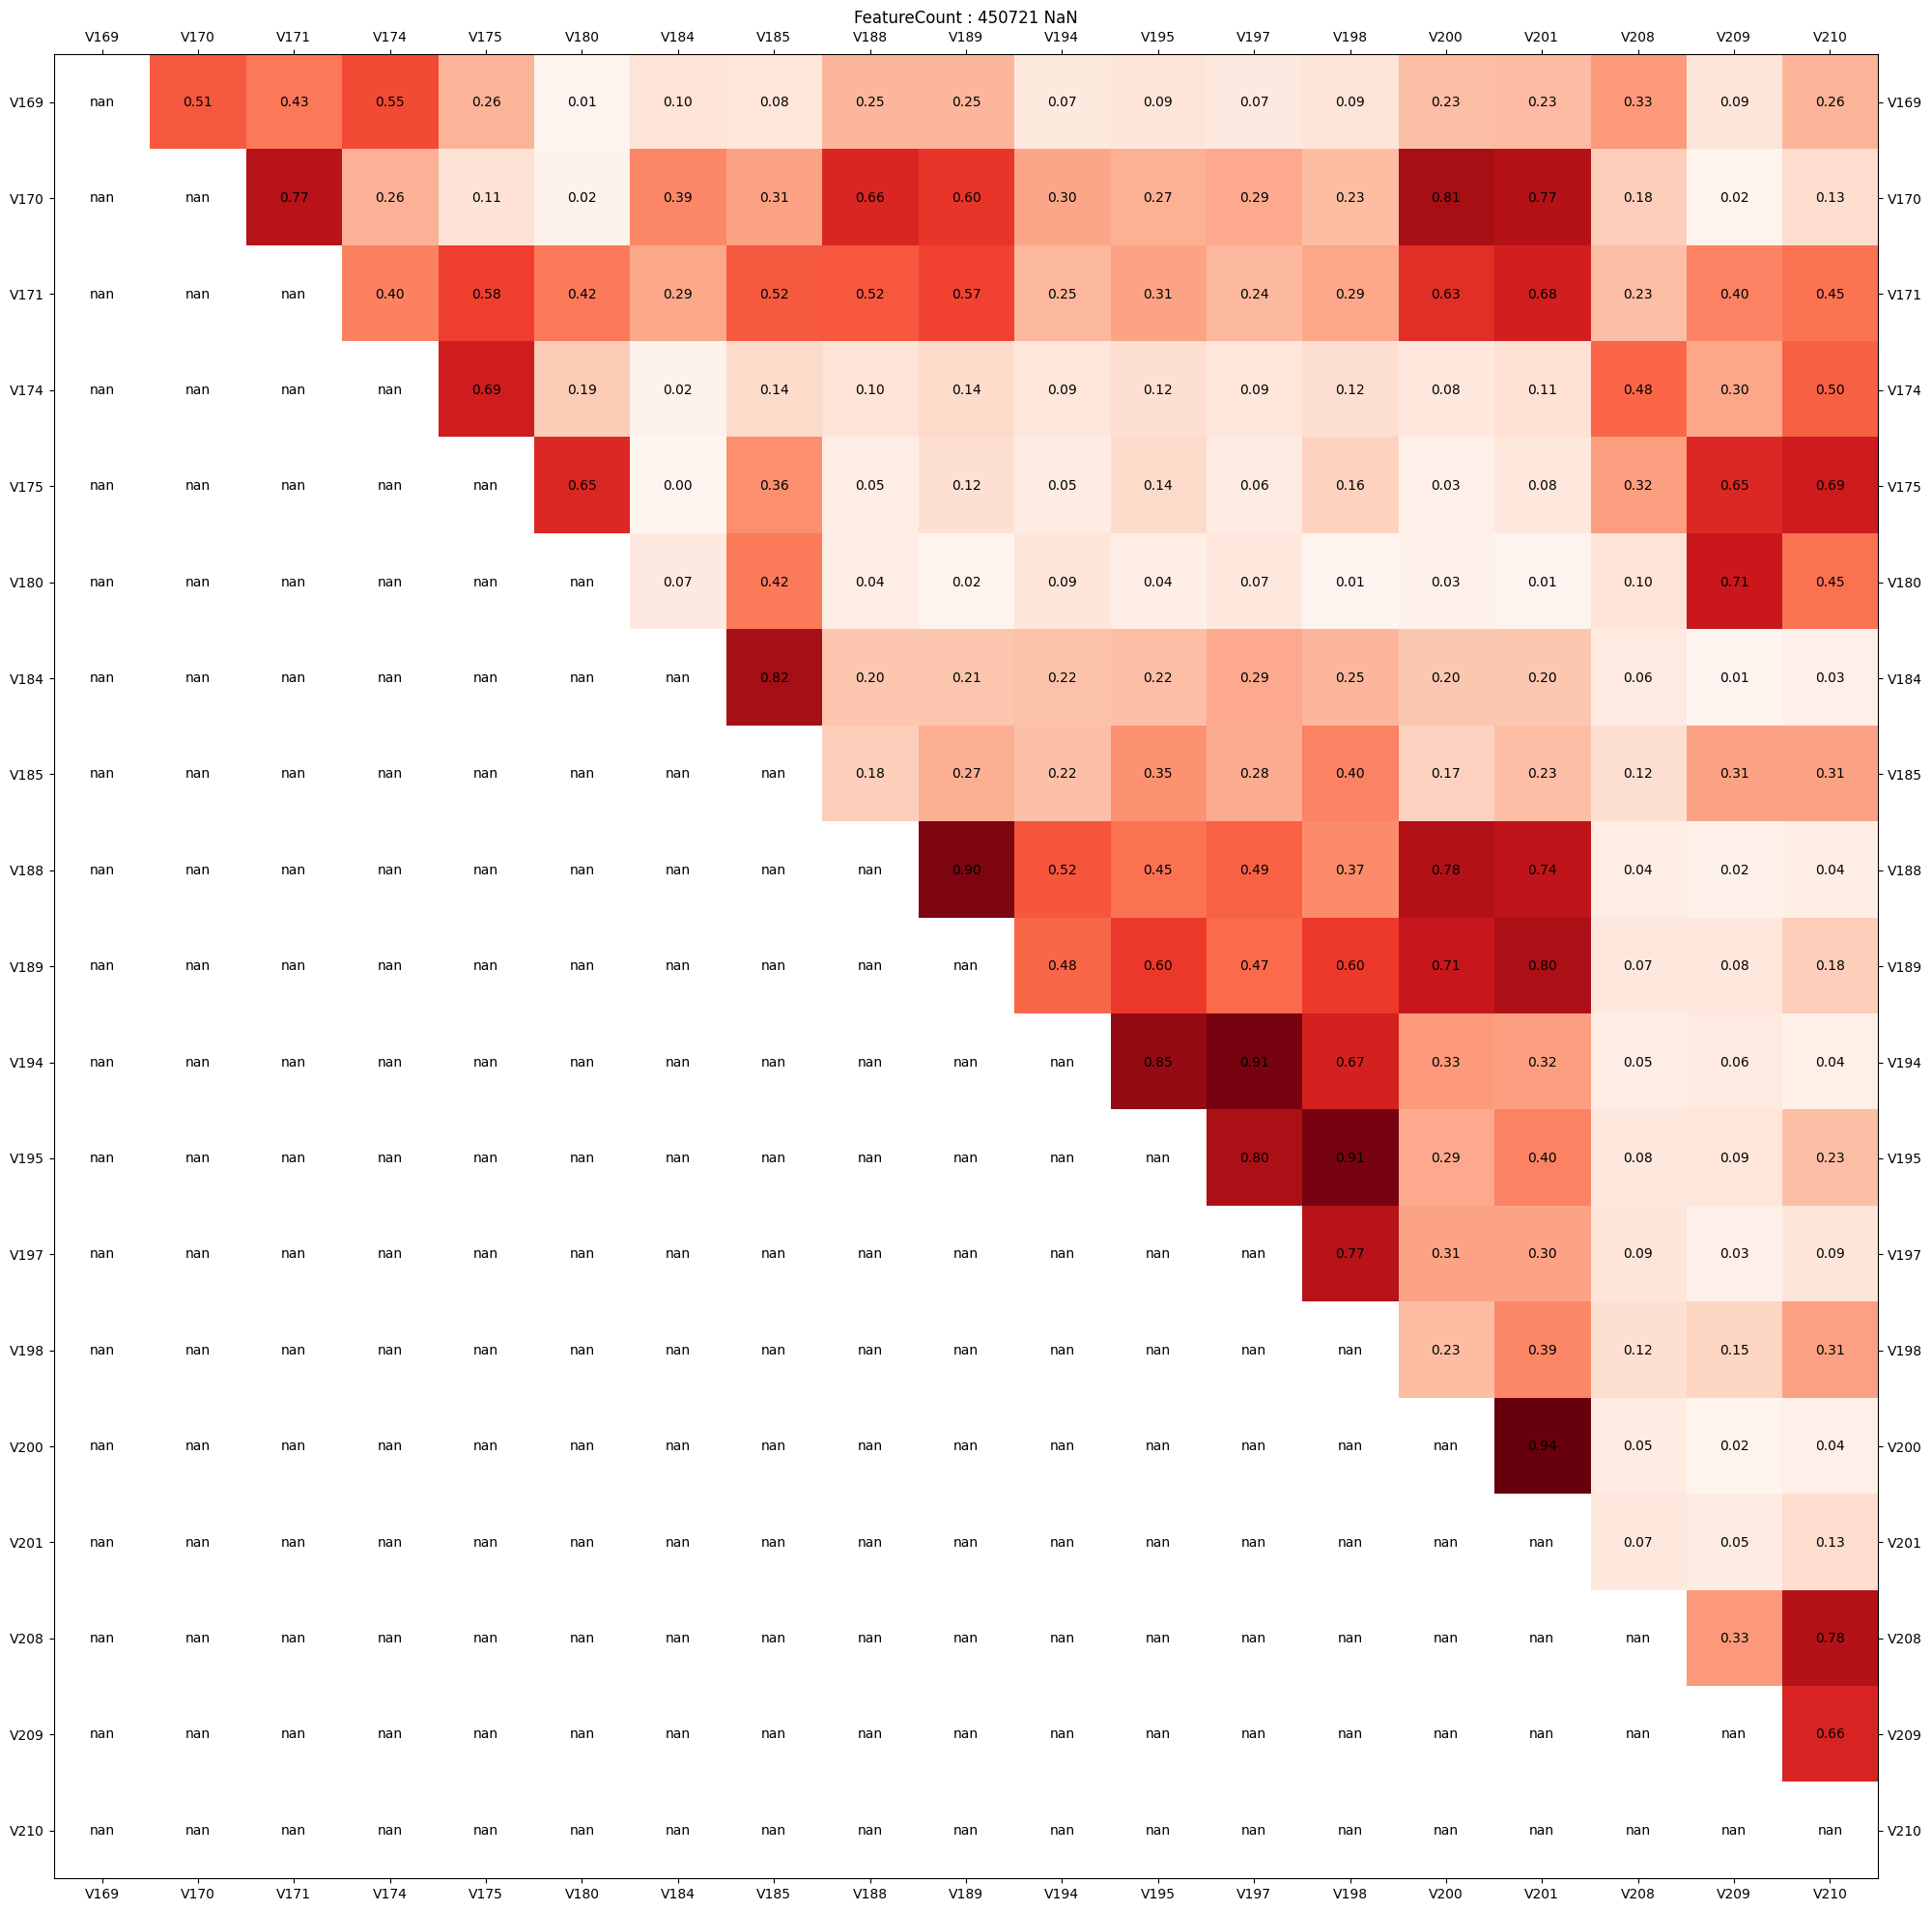

Correlated groups for 450721 : [['V169'], ['V170', 'V200', 'V201'], ['V171'], ['V174'], ['V175'], ['V180'], ['V184', 'V185'], ['V188', 'V189'], ['V194', 'V195', 'V197', 'V198'], ['V208'], ['V209'], ['V210']]

Best for 450721 : ['V169', 'V201', 'V171', 'V174', 'V175', 'V180', 'V184', 'V189', 'V198', 'V208', 'V209', 'V210']
===== End processing group 450721 ======


===== Start processing group 450909 ======


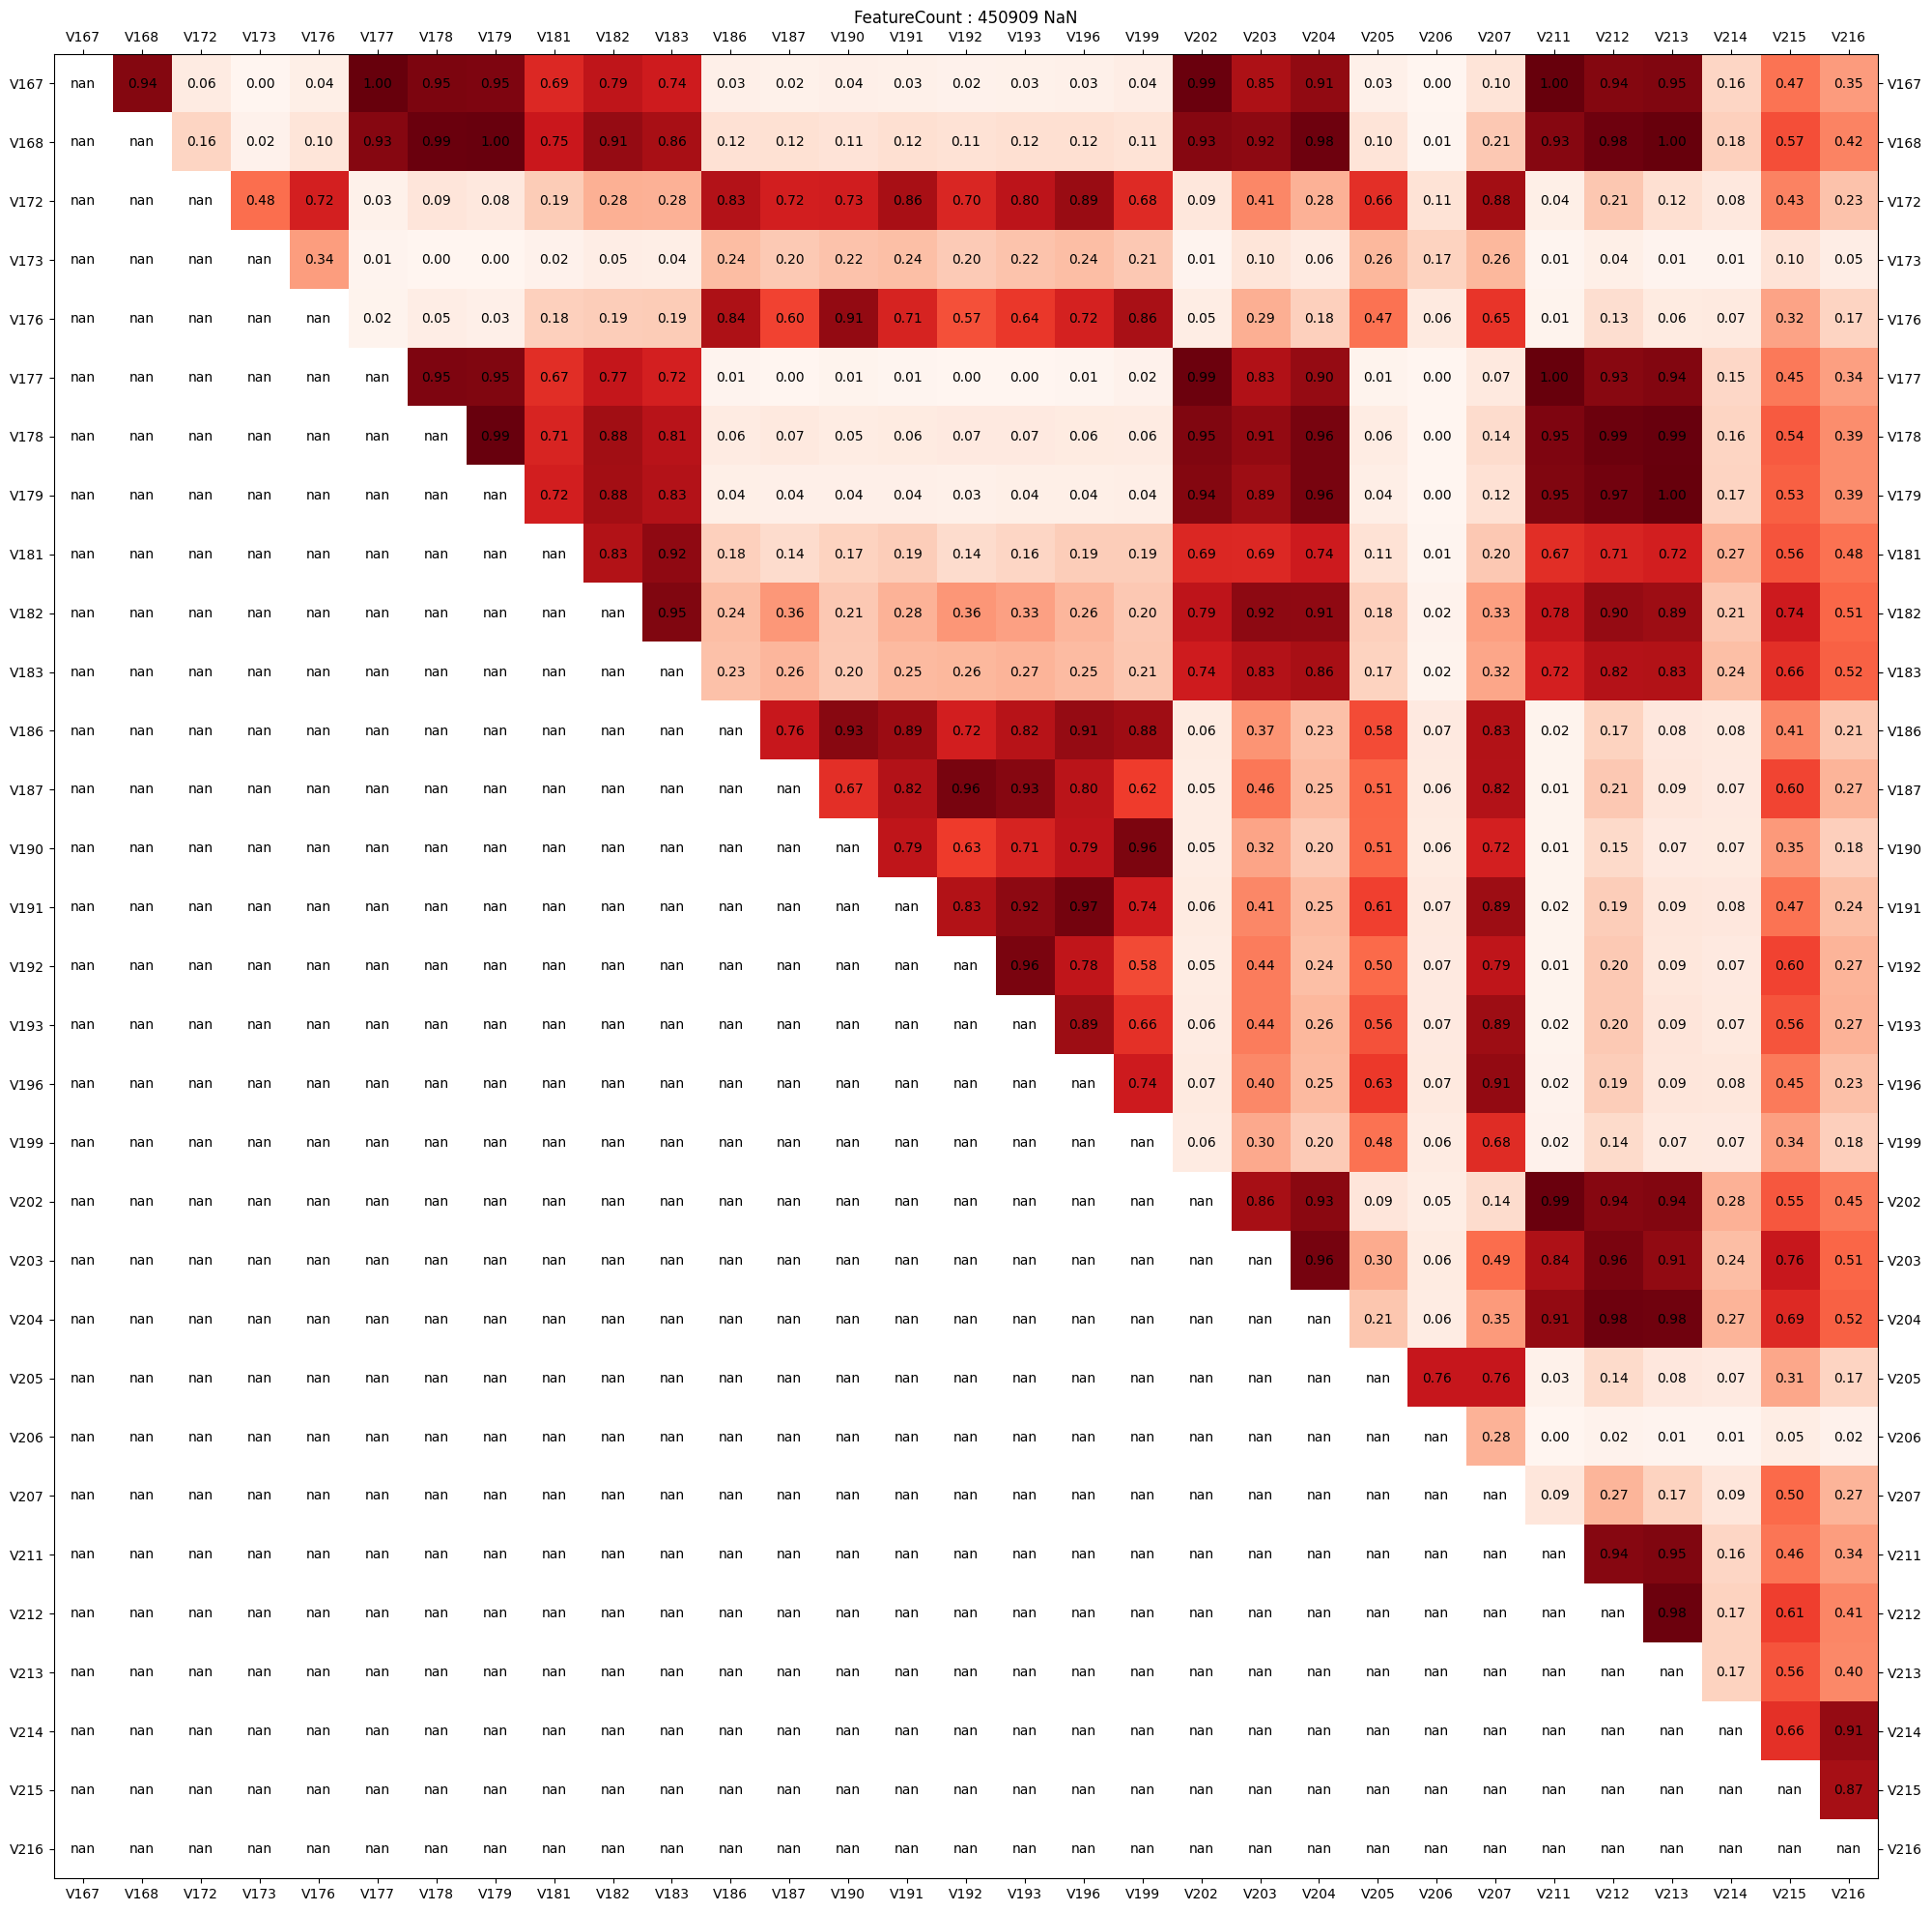

Correlated groups for 450909 : [['V167', 'V168', 'V177', 'V178', 'V179', 'V182', 'V183', 'V202', 'V203', 'V204', 'V211', 'V212', 'V213'], ['V172'], ['V173'], ['V176', 'V186', 'V190', 'V191', 'V196', 'V199', 'V207'], ['V181'], ['V187', 'V192', 'V193'], ['V205'], ['V206'], ['V214', 'V216'], ['V215']]

Best for 450909 : ['V212', 'V172', 'V173', 'V199', 'V181', 'V187', 'V205', 'V206', 'V216', 'V215']
===== End processing group 450909 ======


===== Start processing group 460110 ======


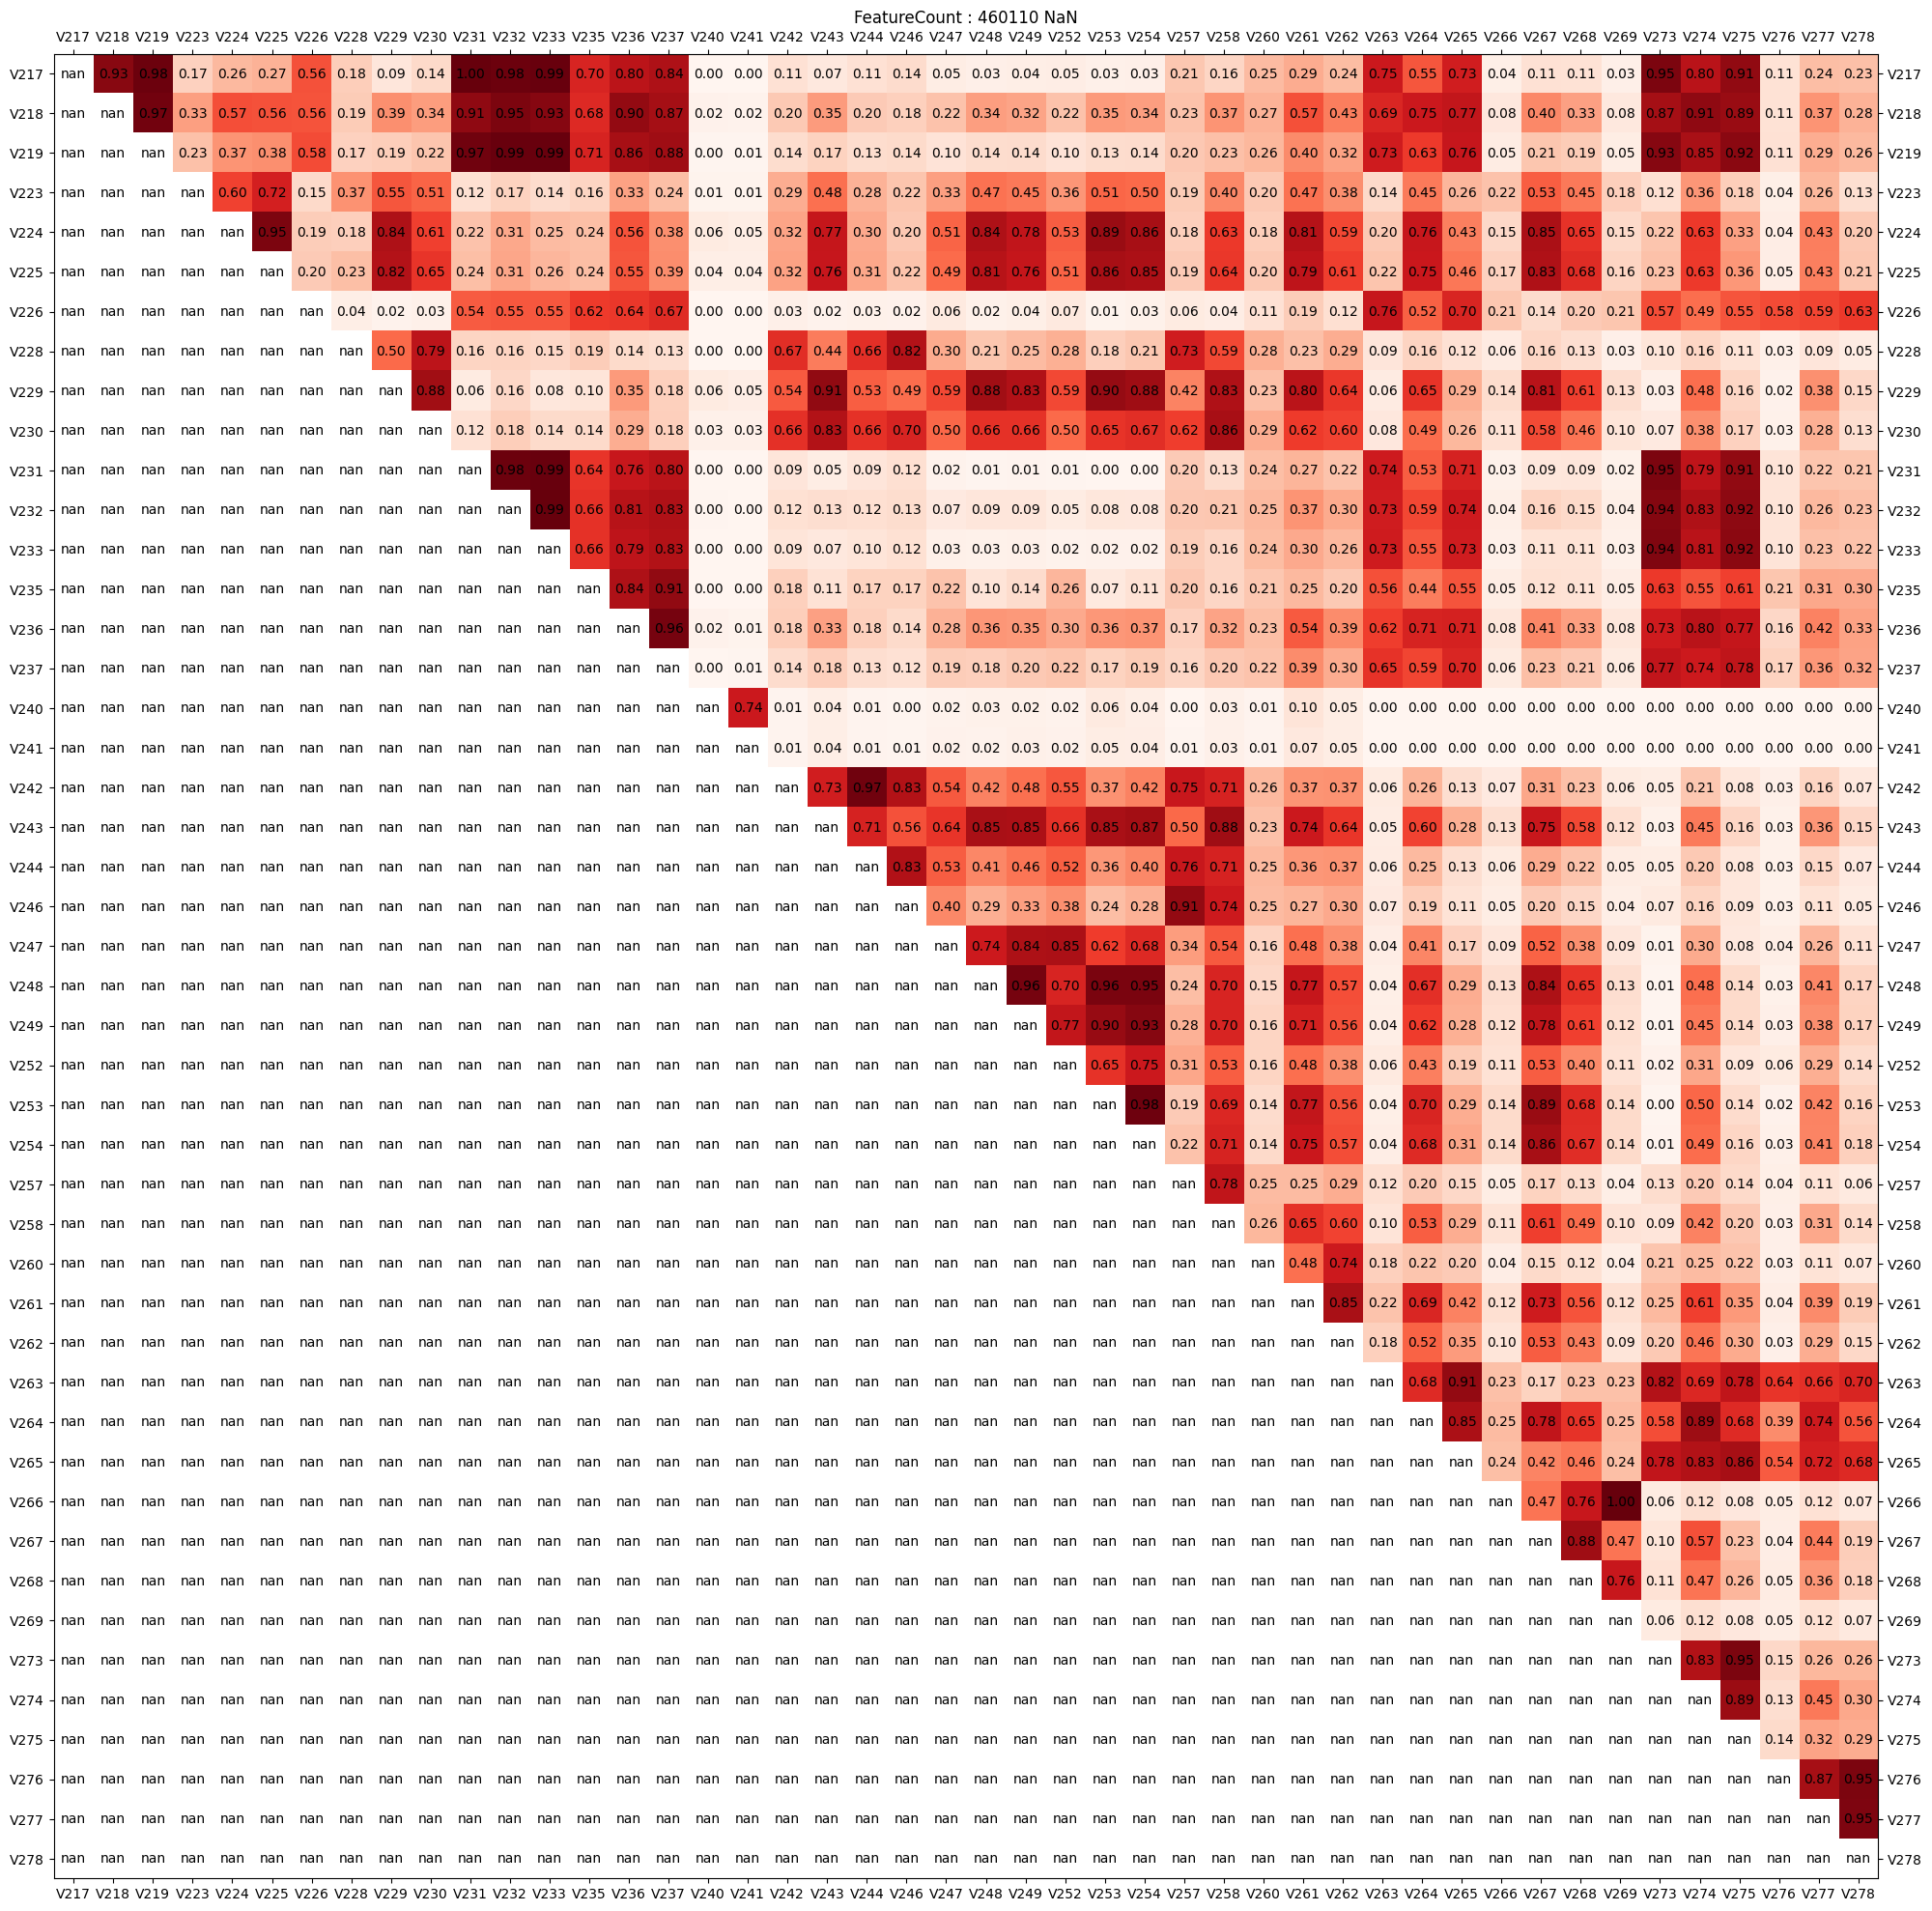

Correlated groups for 460110 : [['V217', 'V218', 'V219', 'V231', 'V232', 'V233', 'V236', 'V237', 'V273', 'V274', 'V275'], ['V223'], ['V224', 'V225', 'V229', 'V230', 'V243', 'V248', 'V249', 'V253', 'V254', 'V258', 'V261', 'V262', 'V267', 'V268'], ['V226'], ['V228'], ['V235'], ['V240'], ['V241'], ['V242', 'V244', 'V246', 'V257'], ['V247', 'V252'], ['V260'], ['V263', 'V265'], ['V264'], ['V266', 'V269'], ['V276', 'V277', 'V278']]

Best for 460110 : ['V274', 'V223', 'V258', 'V226', 'V228', 'V235', 'V240', 'V241', 'V257', 'V252', 'V260', 'V265', 'V264', 'V266', 'V277']
===== End processing group 460110 ======


===== Start processing group 508189 ======


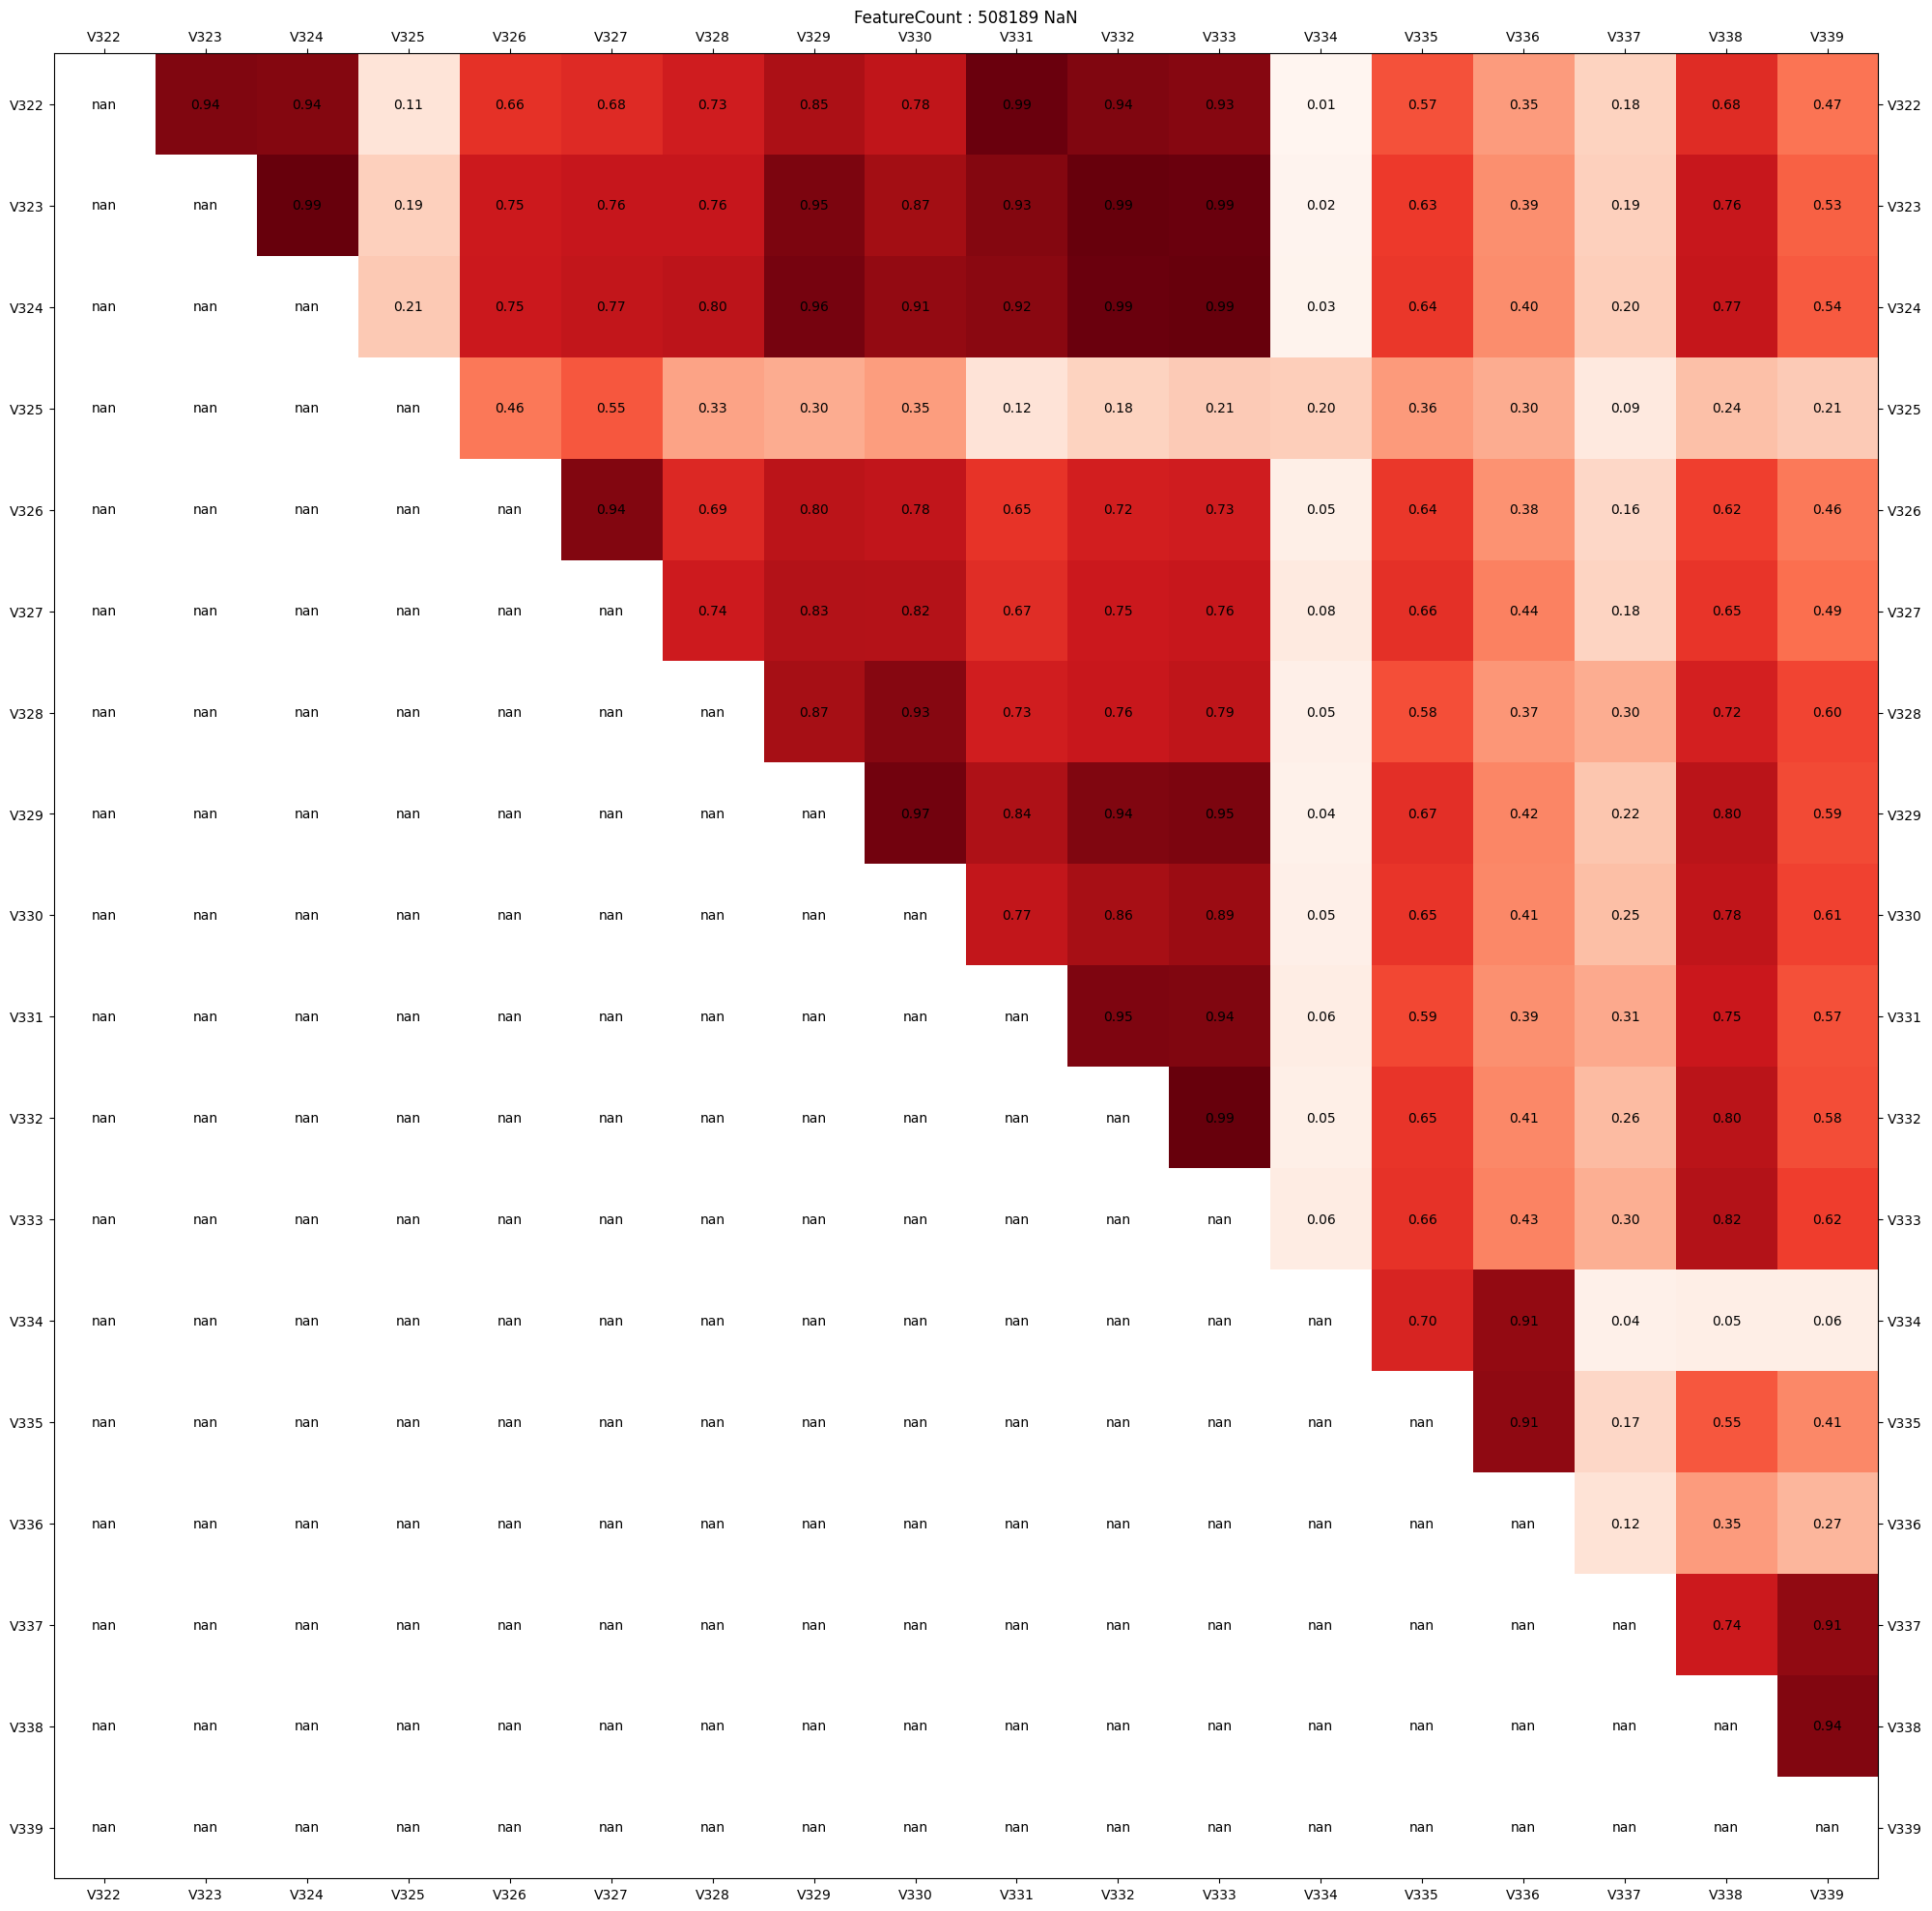

Correlated groups for 508189 : [['V322', 'V323', 'V324', 'V329', 'V330', 'V331', 'V332', 'V333', 'V338', 'V339'], ['V325'], ['V326', 'V327'], ['V328'], ['V334'], ['V335', 'V336'], ['V337']]

Best for 508189 : ['V333', 'V325', 'V326', 'V328', 'V334', 'V335', 'V337']
===== End processing group 508189 ======


===== Start processing group 508589 ======


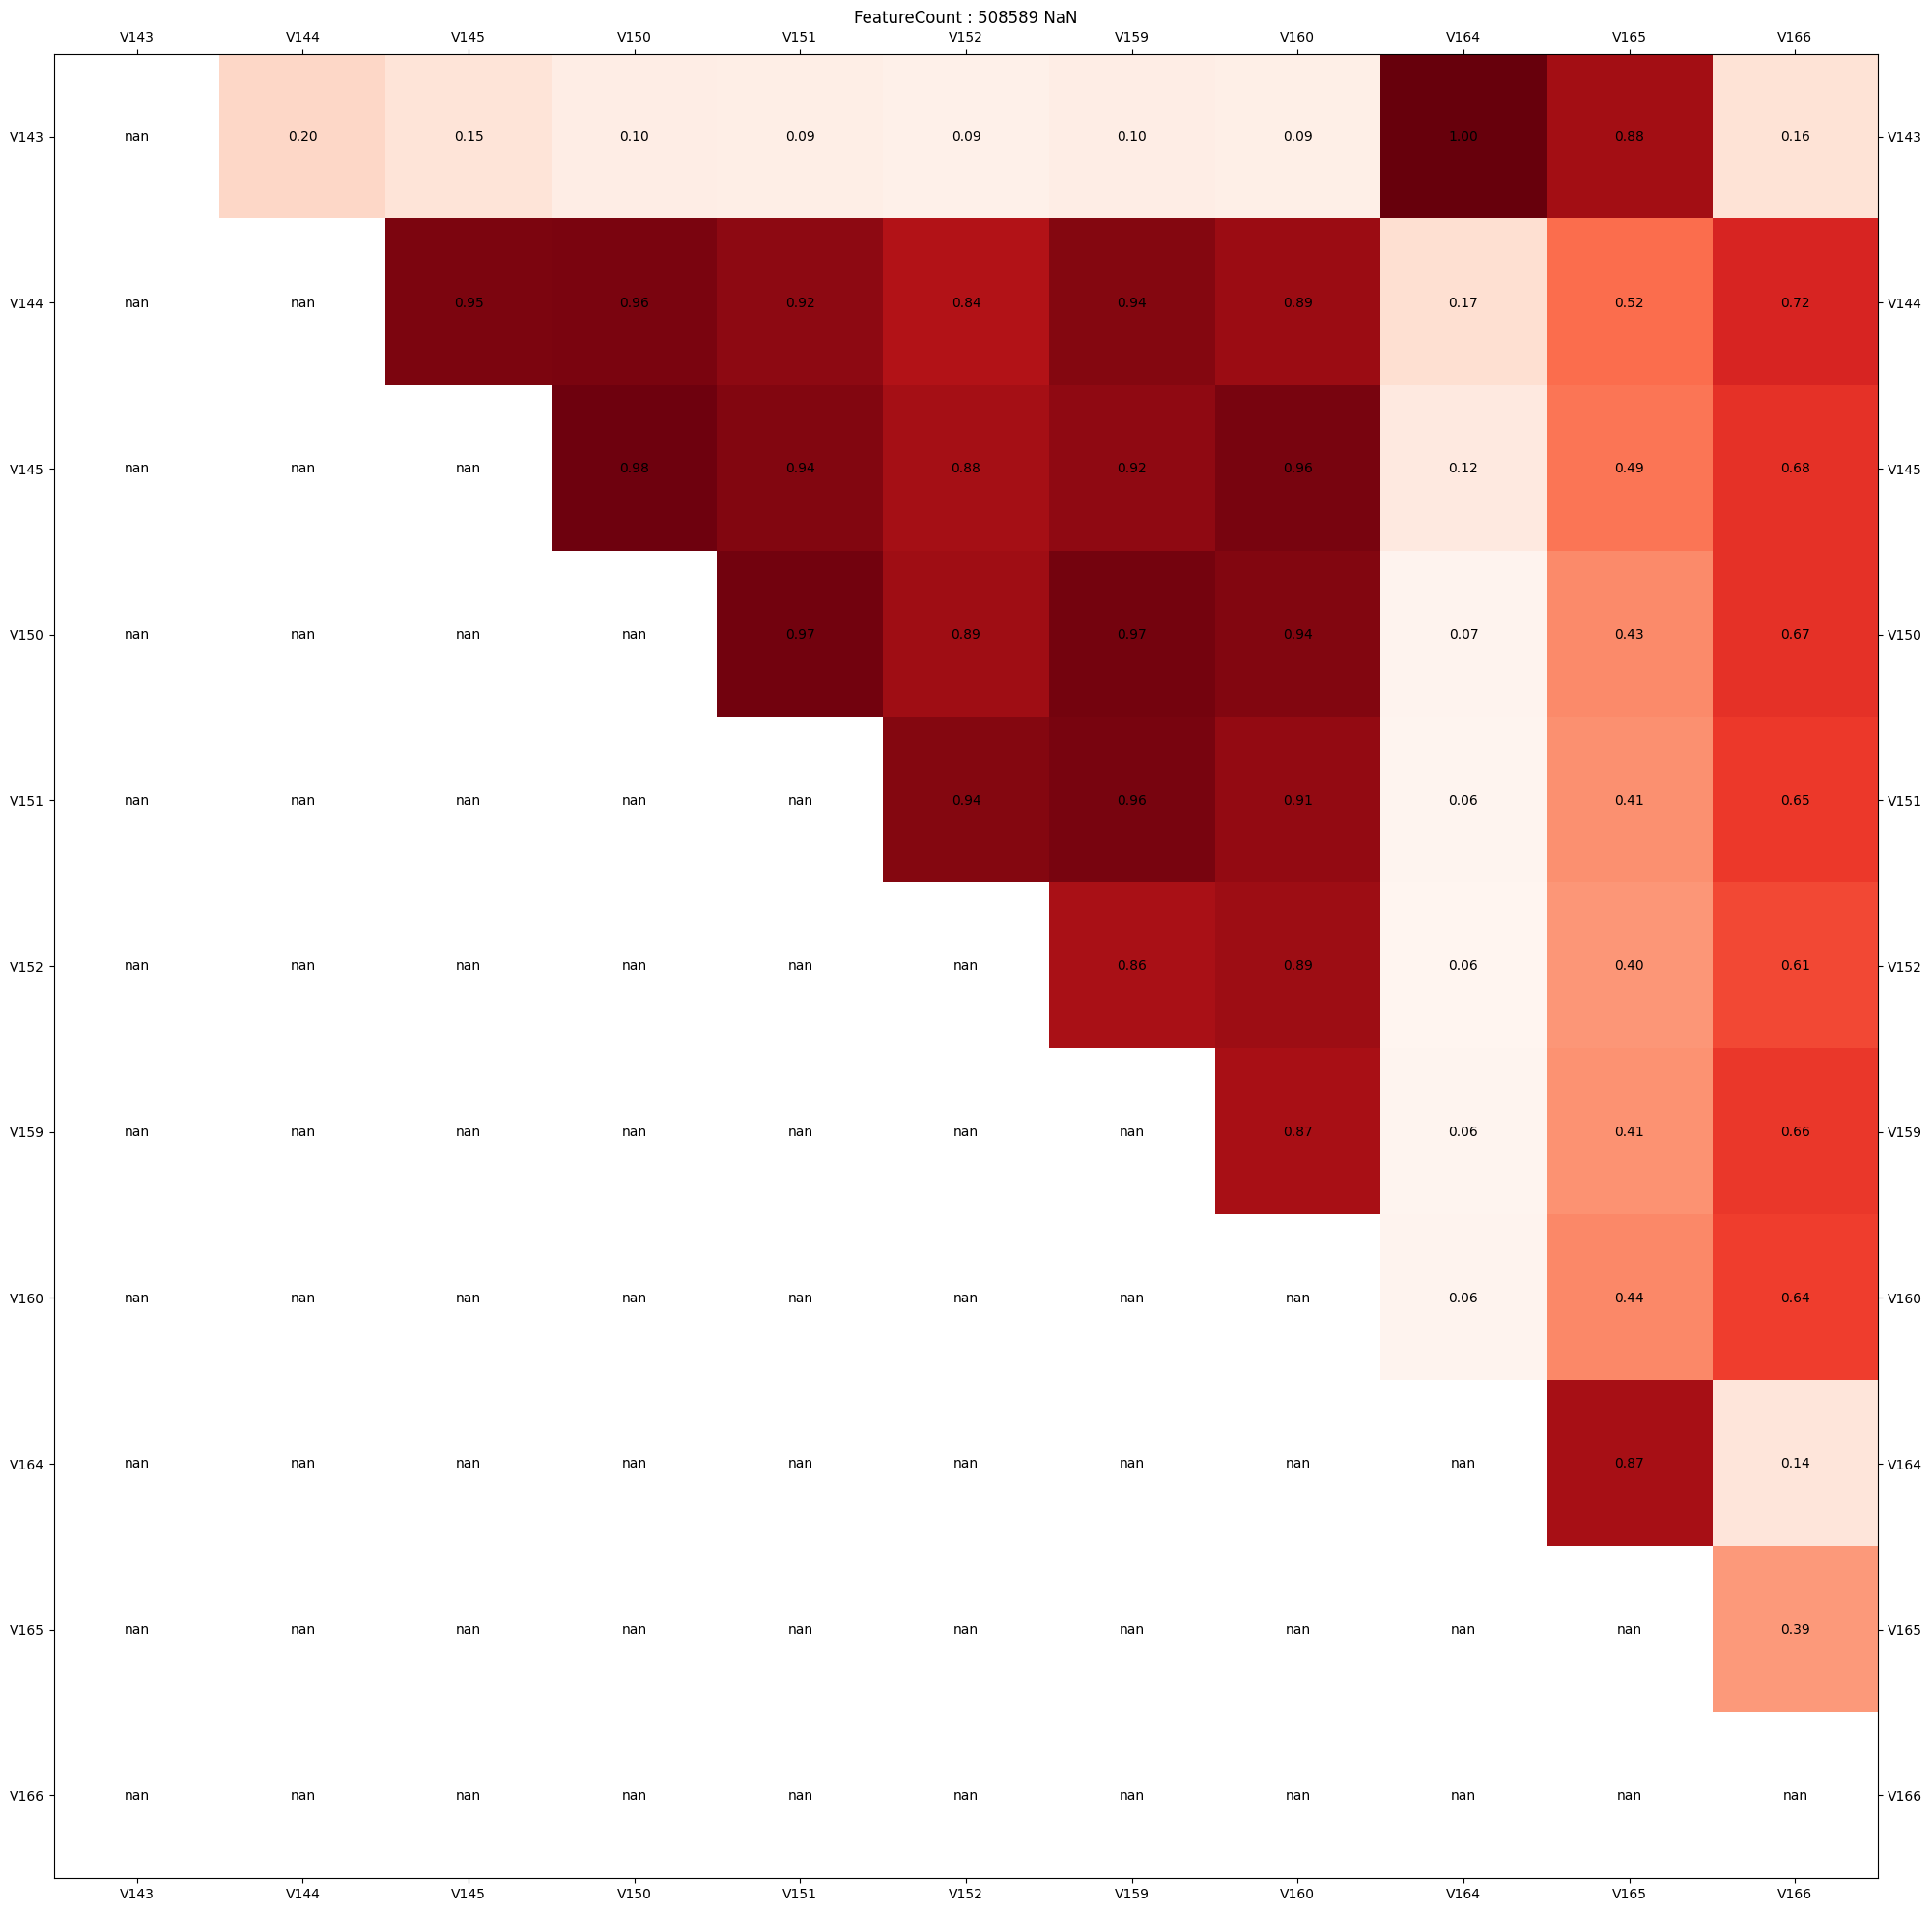

Correlated groups for 508589 : [['V143', 'V164', 'V165'], ['V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160'], ['V166']]

Best for 508589 : ['V165', 'V150', 'V166']
===== End processing group 508589 ======


===== Start processing group 508595 ======


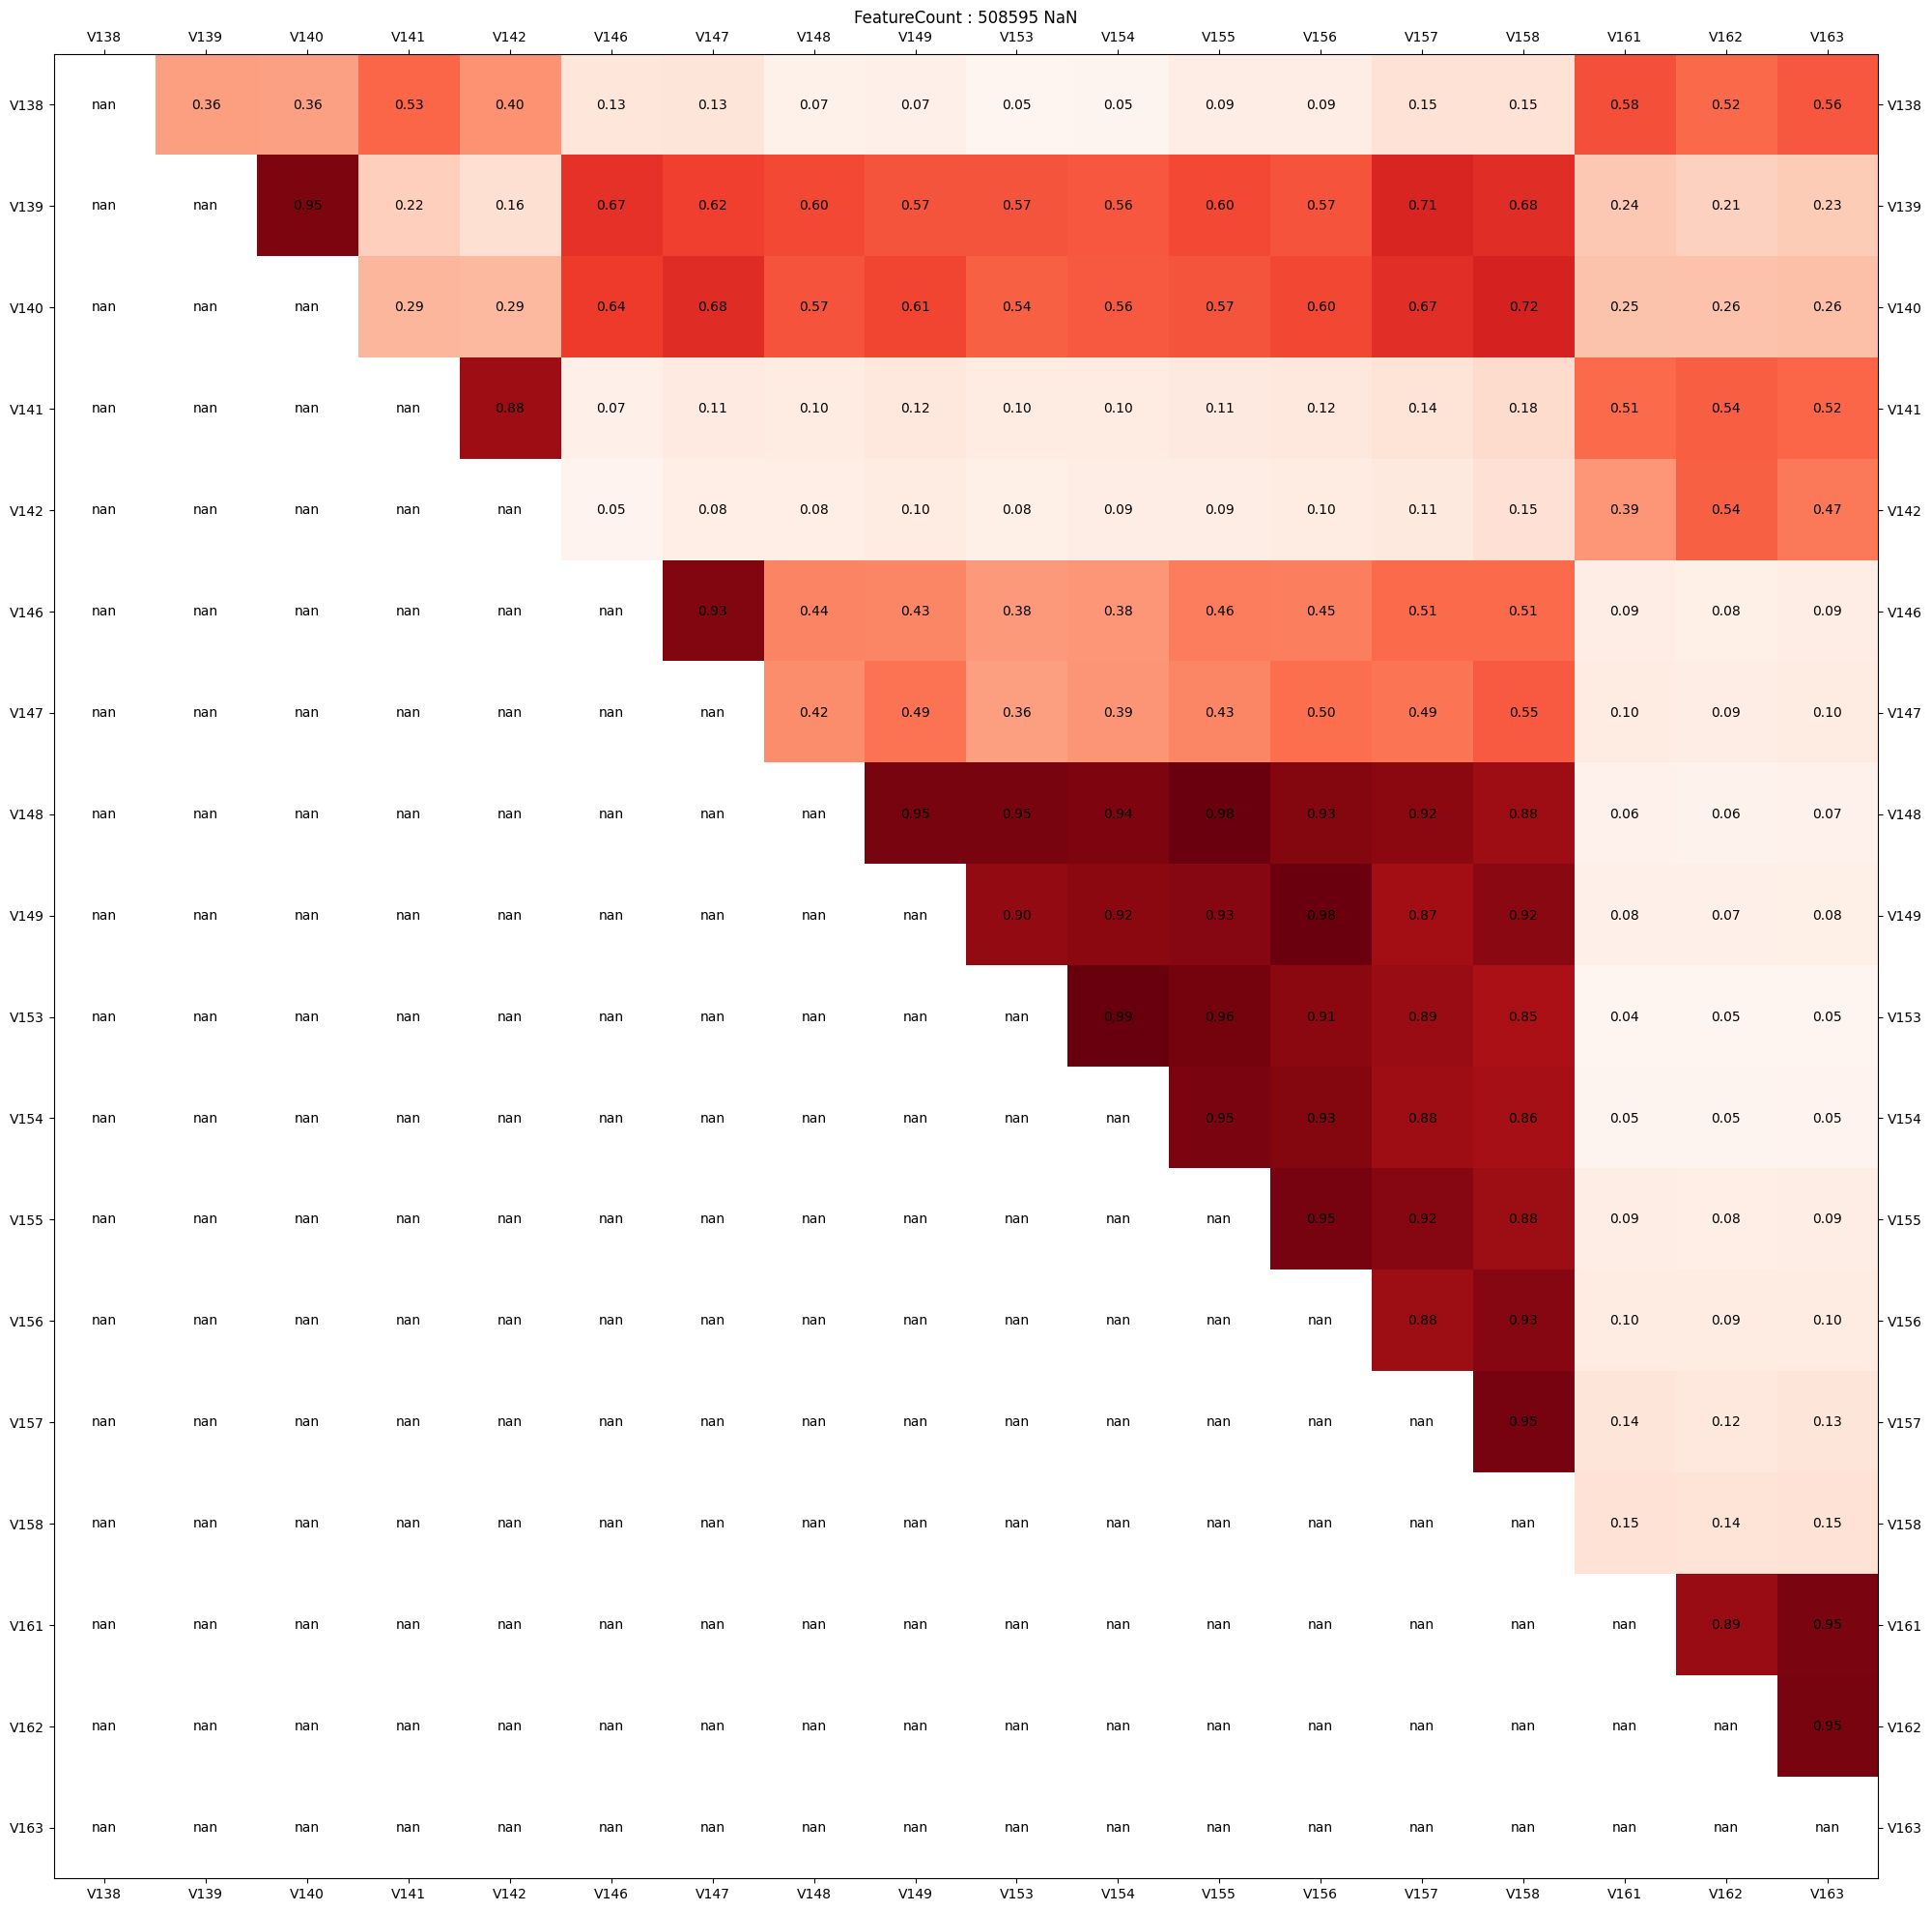

Correlated groups for 508595 : [['V138'], ['V139', 'V140'], ['V141', 'V142'], ['V146', 'V147'], ['V148', 'V149', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158'], ['V161', 'V162', 'V163']]

Best for 508595 : ['V138', 'V140', 'V141', 'V147', 'V156', 'V161']
===== End processing group 508595 ======


===== End processing =====


In [12]:
CORRELATION_THRESHOLD = 0.8
KEEP_NR_OF_BEST_IN_GROUP = 1
best_overall = []

for i in range(y.shape[0]):
    print(f'===== Start processing group {y.iloc[i].name} ======')
    plot_corr_matrix(v_df, y.iloc[i]['index'], y.iloc[i].name)
    groups=reduce_groups(v_df, y.iloc[i]['index'], CORRELATION_THRESHOLD)
    print(f'Correlated groups for {y.iloc[i].name} : {groups}')
    print('')
    best = reduce_group_infogain(df, groups, KEEP_NR_OF_BEST_IN_GROUP)
    best_overall.append(best)
    print(f'Best for {y.iloc[i].name} : {best}')
    print(f'===== End processing group {y.iloc[i].name} ======')
    print('')
    print('')
print('===== End processing =====')

In [13]:
f'number of features left: {sum([len(b) for b in best_overall[1]])}'

'number of features left: 91'

At this point we have 15 groups, each group has uncorrelated features and we selected features that have a high infogain value. Next up we need to figure out which are the best features left in each group, because there are still too many.

In [14]:
pd.set_option("display.max_columns", 100)
df[best_overall[1]].describe()

V133            V98           V100           V104  \
count  590226.00000  590226.000000  590226.000000  590226.000000   
mean      204.88916       0.061985       0.273504       0.085433   
std      3796.31665       0.284995       0.947176       0.648718   
min         0.00000       0.000000       0.000000       0.000000   
25%         0.00000       0.000000       0.000000       0.000000   
50%         0.00000       0.000000       0.000000       0.000000   
75%         0.00000       0.000000       0.000000       0.000000   
max    133915.00000      12.000000      28.000000      15.000000   

                V107           V110           V109           V113  \
count  590226.000000  590226.000000  590226.000000  590226.000000   
mean        0.999580       1.007739       1.014816       1.003383   
std         0.020494       0.097290       0.127769       0.074754   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       7.000000       7.000000       9.000000   

                V112           V114           V115           V119  \
count  590226.000000  590226.000000  590226.000000  590226.000000   
mean        1.005356       1.009298       1.032450       1.000728   
std         0.084617       0.110179       0.190385       0.036392   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         9.000000       6.000000       6.000000       3.000000   

                V118           V120           V121           V122  \
count  590226.000000  590226.000000  590226.000000  590226.000000   
mean        1.001474       1.000874       1.004276       1.001759   
std         0.041011       0.041684       0.067097       0.048636   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         3.000000       3.000000       3.000000       3.000000   

                V123           V124           V129           V130  \
count  590226.000000  590226.000000  590226.000000  590226.000000   
mean        1.031120       1.092975       8.768944      92.165863   
std         0.228134       0.374103     113.832832     315.960480   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         1.000000       1.000000       0.000000      59.000000   
max        13.000000      13.000000   55125.000000   55125.000000   

                V131           V135           V136  
count  590226.000000  590226.000000  590226.000000  
mean       31.133301      17.250130      38.821198  
std       161.161255     293.847565     451.808411  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000  
max     55125.000000   90750.000000   90750.000000

### Step3 : Create a base case
In the next steps we will try to add each of the **best_overall** groups to a model with the **base features only** and see how they change the model performance. 

That means we first need to know how the model performs without any of the V-Features.

#### Define Model Features

In [14]:
# Function to replace a negative number with Nan. For use as FeatureExpression.
def set_negative_to_nan(feature: int):
    return feature if not math.isnan(feature) and feature >= 0 else np.nan

# Categorical features.
amount_bin  = ft.FeatureBin('Amount_Bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
dist_bin    = ft.FeatureBin('Dist_Bin', ft.FEATURE_TYPE_INT_8, dist1, 20, scale_type='geometric')
dow         = ft.FeatureDateTimeFormat('day_of_week', ft.FEATURE_TYPE_INT_8, date_time, '%w')
dom         = ft.FeatureDateTimeFormat('day_of_month', ft.FEATURE_TYPE_INT_16, date_time, '%d')
hod         = ft.FeatureDateTimeFormat('hour_of_day', ft.FEATURE_TYPE_INT_16, date_time, '%H')
dow_i       = ft.FeatureIndex('day_of_week_i', ft.FEATURE_TYPE_INT_16, dow)
dom_i       = ft.FeatureIndex('day_of_month_i', ft.FEATURE_TYPE_INT_16, dom)
hod_i       = ft.FeatureIndex('hour_of_day_i', ft.FEATURE_TYPE_INT_16, hod)
product_i   = ft.FeatureIndex('product_i', ft.FEATURE_TYPE_INT_16, product)
card1_i     = ft.FeatureIndex('card1_i', ft.FEATURE_TYPE_INT_16, card1)
card2_i     = ft.FeatureIndex('card2_i', ft.FEATURE_TYPE_INT_16, card2)
card3_i     = ft.FeatureIndex('card3_i', ft.FEATURE_TYPE_INT_16, card3)
card4_i     = ft.FeatureIndex('card4_i', ft.FEATURE_TYPE_INT_16, card4)
card5_i     = ft.FeatureIndex('card5_i', ft.FEATURE_TYPE_INT_16, card5)
card6_i     = ft.FeatureIndex('card6_i', ft.FEATURE_TYPE_INT_16, card6)
addr1_i     = ft.FeatureIndex('addr1_i', ft.FEATURE_TYPE_INT_16, addr1)
addr2_i     = ft.FeatureIndex('addr2_i', ft.FEATURE_TYPE_INT_16, addr2)
p_mail_dom_i = ft.FeatureIndex('P_emaildomain_i', ft.FEATURE_TYPE_INT_16, p_mail_dom)
r_mail_dom_i = ft.FeatureIndex('R_emaildomain_i', ft.FEATURE_TYPE_INT_16, r_mail_dom) 

# Count Features
c1_bin     = ft.FeatureBin('C1_Bin', ft.FEATURE_TYPE_INT_8, c1, 20, scale_type='geometric')
c2_bin     = ft.FeatureBin('C2_Bin', ft.FEATURE_TYPE_INT_8, c2, 20, scale_type='geometric')
c3_bin     = ft.FeatureBin('C3_Bin', ft.FEATURE_TYPE_INT_8, c3, 20, scale_type='geometric')
c4_bin     = ft.FeatureBin('C4_Bin', ft.FEATURE_TYPE_INT_8, c4, 20, scale_type='geometric')
c5_bin     = ft.FeatureBin('C5_Bin', ft.FEATURE_TYPE_INT_8, c5, 20, scale_type='geometric')
c6_bin     = ft.FeatureBin('C6_Bin', ft.FEATURE_TYPE_INT_8, c6, 20, scale_type='geometric')
c7_bin     = ft.FeatureBin('C7_Bin', ft.FEATURE_TYPE_INT_8, c7, 20, scale_type='geometric')
c8_bin     = ft.FeatureBin('C8_Bin', ft.FEATURE_TYPE_INT_8, c8, 20, scale_type='geometric')
c9_bin     = ft.FeatureBin('C9_Bin', ft.FEATURE_TYPE_INT_8, c9, 20, scale_type='geometric')
c10_bin    = ft.FeatureBin('C10_Bin', ft.FEATURE_TYPE_INT_8, c10, 20, scale_type='geometric')
c11_bin    = ft.FeatureBin('C11_Bin', ft.FEATURE_TYPE_INT_8, c11, 20, scale_type='geometric')
c12_bin    = ft.FeatureBin('C12_Bin', ft.FEATURE_TYPE_INT_8, c12, 20, scale_type='geometric')
c13_bin    = ft.FeatureBin('C13_Bin', ft.FEATURE_TYPE_INT_8, c13, 20, scale_type='geometric')
c14_bin    = ft.FeatureBin('C14_Bin', ft.FEATURE_TYPE_INT_8, c14, 20, scale_type='geometric')

# Timing Features
d1_bin  = ft.FeatureBin('D1_Bin', ft.FEATURE_TYPE_INT_8, d1, 15)
d2_bin  = ft.FeatureBin('D2_Bin', ft.FEATURE_TYPE_INT_8, d2, 15)
d3_bin  = ft.FeatureBin('D3_Bin', ft.FEATURE_TYPE_INT_8, d3, 15)
d4_bin  = ft.FeatureBin('D4_Bin', ft.FEATURE_TYPE_INT_8, d4, 15)
d5_bin  = ft.FeatureBin('D5_Bin', ft.FEATURE_TYPE_INT_8, d5, 15)
d6_ex   = ft.FeatureExpression('d6_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d6])
d6_bin  = ft.FeatureBin('D6_Bin', ft.FEATURE_TYPE_INT_8, d6_ex, 15)
d7_bin  = ft.FeatureBin('D7_Bin', ft.FEATURE_TYPE_INT_8, d7, 15)
d8_bin  = ft.FeatureBin('D8_Bin', ft.FEATURE_TYPE_INT_8, d8, 15)
d9_bin  = ft.FeatureBin('D9_Bin', ft.FEATURE_TYPE_INT_8, d9, 15)
d10_bin = ft.FeatureBin('D10_Bin', ft.FEATURE_TYPE_INT_8, d10, 15)
d11_ex  = ft.FeatureExpression('d11_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d11])
d11_bin = ft.FeatureBin('D11_Bin', ft.FEATURE_TYPE_INT_8, d11_ex, 15)
d12_ex  = ft.FeatureExpression('d12_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d12])
d12_bin = ft.FeatureBin('D12_Bin', ft.FEATURE_TYPE_INT_8, d12_ex, 15)
d13_bin = ft.FeatureBin('D13_Bin', ft.FEATURE_TYPE_INT_8, d13, 15)
d14_ex  = ft.FeatureExpression('d14_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d14])
d14_bin = ft.FeatureBin('D14_Bin', ft.FEATURE_TYPE_INT_8, d14_ex, 15)
d15_ex  = ft.FeatureExpression('d15_ex', ft.FEATURE_TYPE_FLOAT_32, set_negative_to_nan, [d15])
d15_bin = ft.FeatureBin('D15_Bin', ft.FEATURE_TYPE_INT_8, d15_ex, 15)

# Match features
m1_i = ft.FeatureIndex('m1_i', ft.FEATURE_TYPE_INT_8, m1)
m2_i = ft.FeatureIndex('m2_i', ft.FEATURE_TYPE_INT_8, m2)
m3_i = ft.FeatureIndex('m3_i', ft.FEATURE_TYPE_INT_8, m3)
m4_i = ft.FeatureIndex('m4_i', ft.FEATURE_TYPE_INT_8, m4)
m5_i = ft.FeatureIndex('m5_i', ft.FEATURE_TYPE_INT_8, m5)
m6_i = ft.FeatureIndex('m6_i', ft.FEATURE_TYPE_INT_8, m6)
m7_i = ft.FeatureIndex('m7_i', ft.FEATURE_TYPE_INT_8, m7)
m8_i = ft.FeatureIndex('m8_i', ft.FEATURE_TYPE_INT_8, m8)
m9_i = ft.FeatureIndex('m9_i', ft.FEATURE_TYPE_INT_8, m9)

# Label Feature
fraud_label = ft.FeatureLabelBinary('Fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

td_categorical = ft.TensorDefinition('ieee-categorical', [
    amount_bin, dist_bin, dow_i, hod_i, product_i, card2_i, card3_i, card4_i, card5_i, card6_i, addr1_i, 
    p_mail_dom_i
])

td_counts = ft.TensorDefinition('ieee-counts', [
    c1_bin, c2_bin, c3_bin, c4_bin, c5_bin, c6_bin, c7_bin, c8_bin, c9_bin, c10_bin, 
    c11_bin, c12_bin, c13_bin, c14_bin
])

td_timing = ft.TensorDefinition('ieee-timing', [
    d1_bin, d2_bin, d3_bin, d4_bin, d5_bin, d6_bin, d7_bin, d8_bin, d9_bin, d10_bin, 
    d11_bin, d12_bin, d13_bin, d14_bin
])

td_match = ft.TensorDefinition('ieee-match', [m1_i, m2_i, m3_i, m4_i, m5_i, m6_i, m7_i, m8_i, m9_i])

td_label = ft.TensorDefinition('ieee-label', [fraud_label])

# Define all possible V-Features labels
v_features = []
for i, f in enumerate(v_base_features):
    if df[f.name].max() <= 20 and all(df[f.name].dropna().apply(float.is_integer)):
        v_features.append(ft.FeatureIndex(f'v{i+1}_i', 
                                          ft.FEATURE_TYPE_INT_32, 
                                          ft.FeatureSource(f'V{i+1}', 
                                          ft.FEATURE_TYPE_CATEGORICAL)))
    elif df[f.name].max() <= 1000:
        v_features.append(ft.FeatureBin(f'v{i+1}_bin', ft.FEATURE_TYPE_INT_8, f, 20))
    else:
        v_features.append(ft.FeatureBin(f'v{i+1}_bin', ft.FEATURE_TYPE_INT_8, f, 20, scale_type='geometric'))

In [15]:
## Free up memory
del df
_ = gc.collect()

#### Base Case w/Base Features
As a base case we will see how the model performs on the **Categorical data** only. This will be a worse performance than the previous model because we are using less fields. But we need this base case to see how the addition of the V-Feature Nan Groups affects the model

It would have been possible to test with the full feature set, but with the categorical only, things are a bit faster.

In [16]:
# Create a TensorInstance with the td_categorical only
with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv(
        (td_categorical, td_label), 
        tr_train_file, inference=False
    )
    
train, val, test = ti.split_sequential(50000,0)

train_sampler = mp.TensorInstanceNumpyLabelSampler().over_sampler(train)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)

train_dl = train_ds.data_loader(torch.device('cpu'), 128, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(torch.device('cpu'), 128, num_workers=2)

mc = mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def)

2023-06-01 10:35:38.347 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:35:38.348 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:35:38.348 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:35:38.348 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv
2023-06-01 10:35:44.383 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:35:44.391 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 2 numpy arrays


#### Create Base model

In [17]:
class IEEEFeedForwardModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(IEEEFeedForwardModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads(max_dims=30)
        heads_size = sum([h.output_size for h in self.heads])
        
        # Set of layers
        self.layers = mp.LinLayer(input_size=heads_size, layer_sizes=(128,64,64,32), dropout=0.0, bn_interval=2)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a 'IEEEFeedForwardModel' instance
model = IEEEFeedForwardModel(mc)
model

IEEEFeedForwardModel(
  Number of parameters : 76285. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=ieee-categorical, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(20, 10)
          (2): Embedding(8, 5)
          (3): Embedding(25, 12)
          (4): Embedding(6, 5)
          (5): Embedding(501, 30)
          (6): Embedding(115, 30)
          (7): Embedding(5, 5)
          (8): Embedding(120, 30)
          (9): Embedding(5, 5)
          (10): Embedding(333, 30)
          (11): Embedding(60, 30)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (layers): LinLayer(
    (layers): Sequential(
      (lin_layer_01): Linear(in_features=207, out_features=128, bias=True)
      (lin_act_01): ReLU()
      (lin_layer_02): Linear(in_features=128, out_features=64, bias=True)
      (lin_bn_02): BatchNorm1d(64, eps=1e-05, momentum=0

#### Train Base Model

Finding LR in 300 steps: 100%|██████████| 300/300 [00:01<00:00, 226.09it/s]                                                    


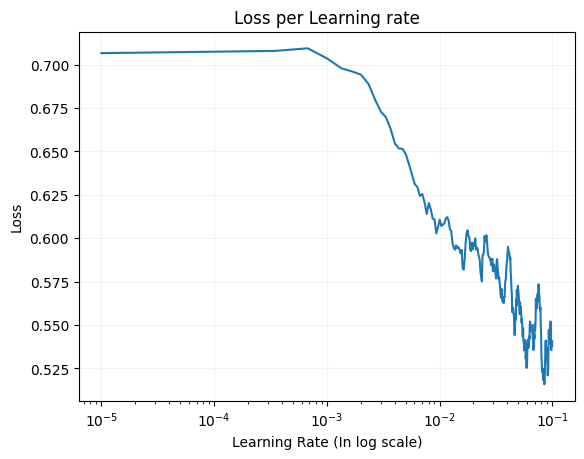

In [18]:
min_lr = 1e-5
max_lr = 1e-1
m_lr = IEEEFeedForwardModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, data_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 300)
mplt.TrainPlot.plot_lr(lrs);

# Free-up memory
del m_lr, o_lr, t_lr, lrs
_ = gc.collect()

In [19]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)

# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=3e-3)

# Set-up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 4614/4614 [00:08<00:00, 543.59it/s, t_loss=0.24, t_acc=0.899, v_loss=0.318, v_acc=0.858]       


#### Test Base Model
This model is not good, but it gives us an idea of what the categorical feature on their own (without the matching features and counting and time delta features) can achieve. This is also a very good illustration of how important the 'context' is in fraud detection. If we would use a standard approach on the base features only, we might not get much further than this. Also fairly typical is that the model still seems to find the same fraud (TP count), but it's mainly the FP count that goes up. This model creates more than 3 times as much false postives as the initial notebook.

We will need to remember the AUC of this model so we can contrast it to what we have when we start adding in V-Features. This model is giving us an approx **0.82 AUC** score and a really low **0.25 AP** score.

Testing in 391 steps: 100%|█████████████████| 391/391 [00:00<00:00, 1106.57it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     48104
         1.0       0.16      0.62      0.25      1896

    accuracy                           0.86     50000
   macro avg       0.57      0.74      0.58     50000
weighted avg       0.95      0.86      0.90     50000


auc score : 0.8220
ap score  : 0.2520
-----------------------------------------------------


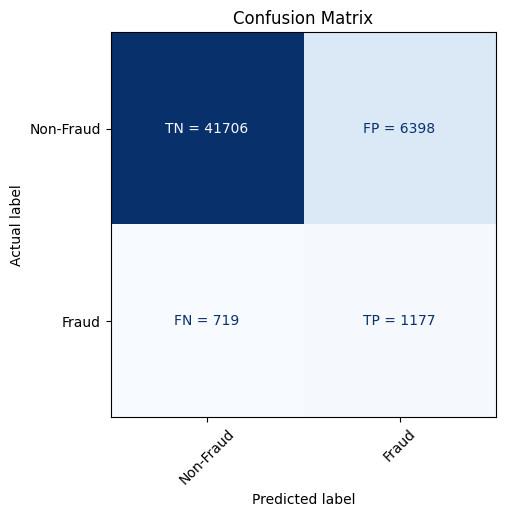

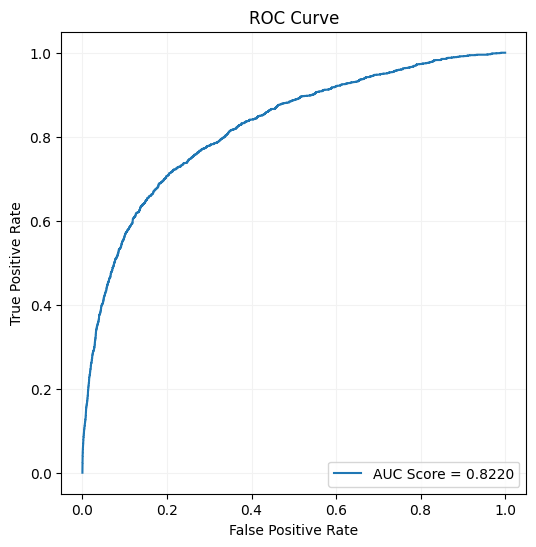

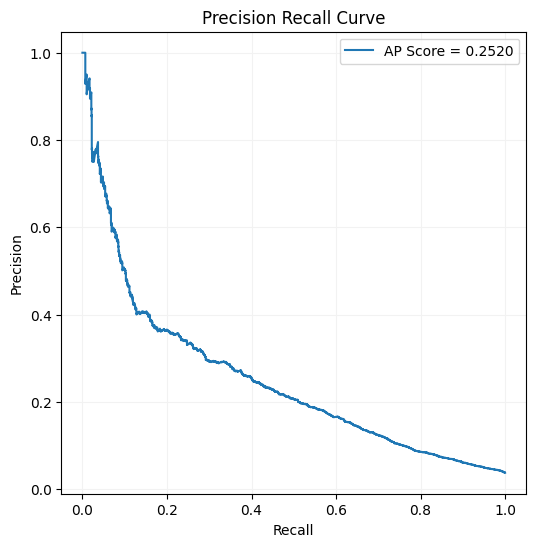

In [20]:
t = mp.Tester(model, torch.device(model_device), val_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6))
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

In [21]:
## Free up memory
del ti, trainer, optimizer, scheduler, t, results, model, train, val, test, train_ds, val_ds, train_dl, val_dl
_ = gc.collect()

### Step 4: Iterate over the Best Overall groups and store attributions.
In this step we will iterate over the best NaN groups, add them to the model and save the attributions. The attributions should show us the features that actually contributed to the model.

The attribution are plotted in violin plots. Ideally we want features with a fairly long light blue area, those are features that on average contribute most, they will be the ones with a higher standard deviation.

2023-06-01 10:39:03.311 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:39:03.312 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:39:03.312 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:39:03.313 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== Start group 0 =========


2023-06-01 10:39:09.852 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:39:09.860 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 825.50it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93     48104
         1.0       0.16      0.60      0.26      1896

    accuracy                           0.87     50000
   macro avg       0.57      0.74      0.59     50000
weighted avg       0.95      0.87      0.90     50000


auc score : 0.8276
ap score  : 0.2661
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


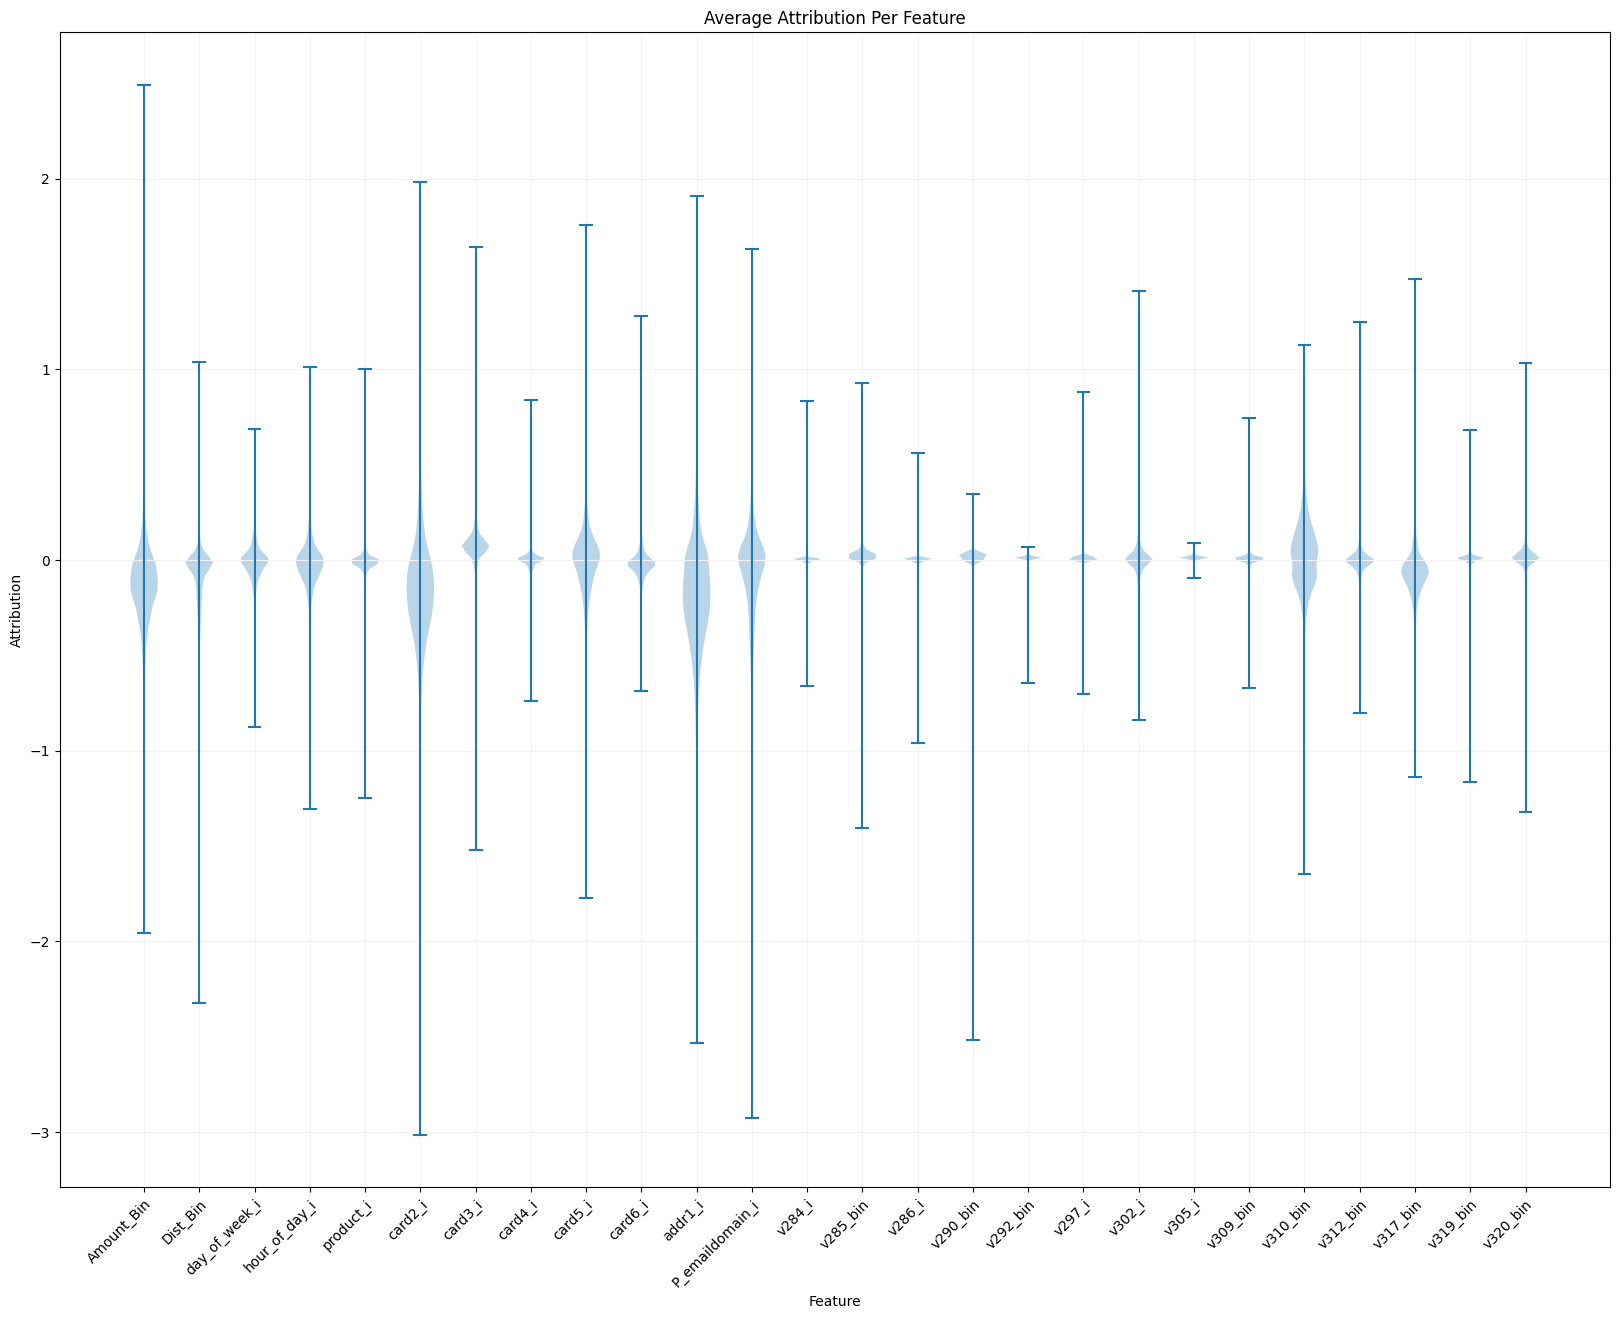

2023-06-01 10:40:22.402 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:40:22.402 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:40:22.402 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:40:22.403 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 0 =========
======== Start group 1 =========


2023-06-01 10:40:29.634 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:40:29.645 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 753.78it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93     48104
         1.0       0.17      0.60      0.26      1896

    accuracy                           0.87     50000
   macro avg       0.57      0.74      0.59     50000
weighted avg       0.95      0.87      0.90     50000


auc score : 0.8333
ap score  : 0.3055
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


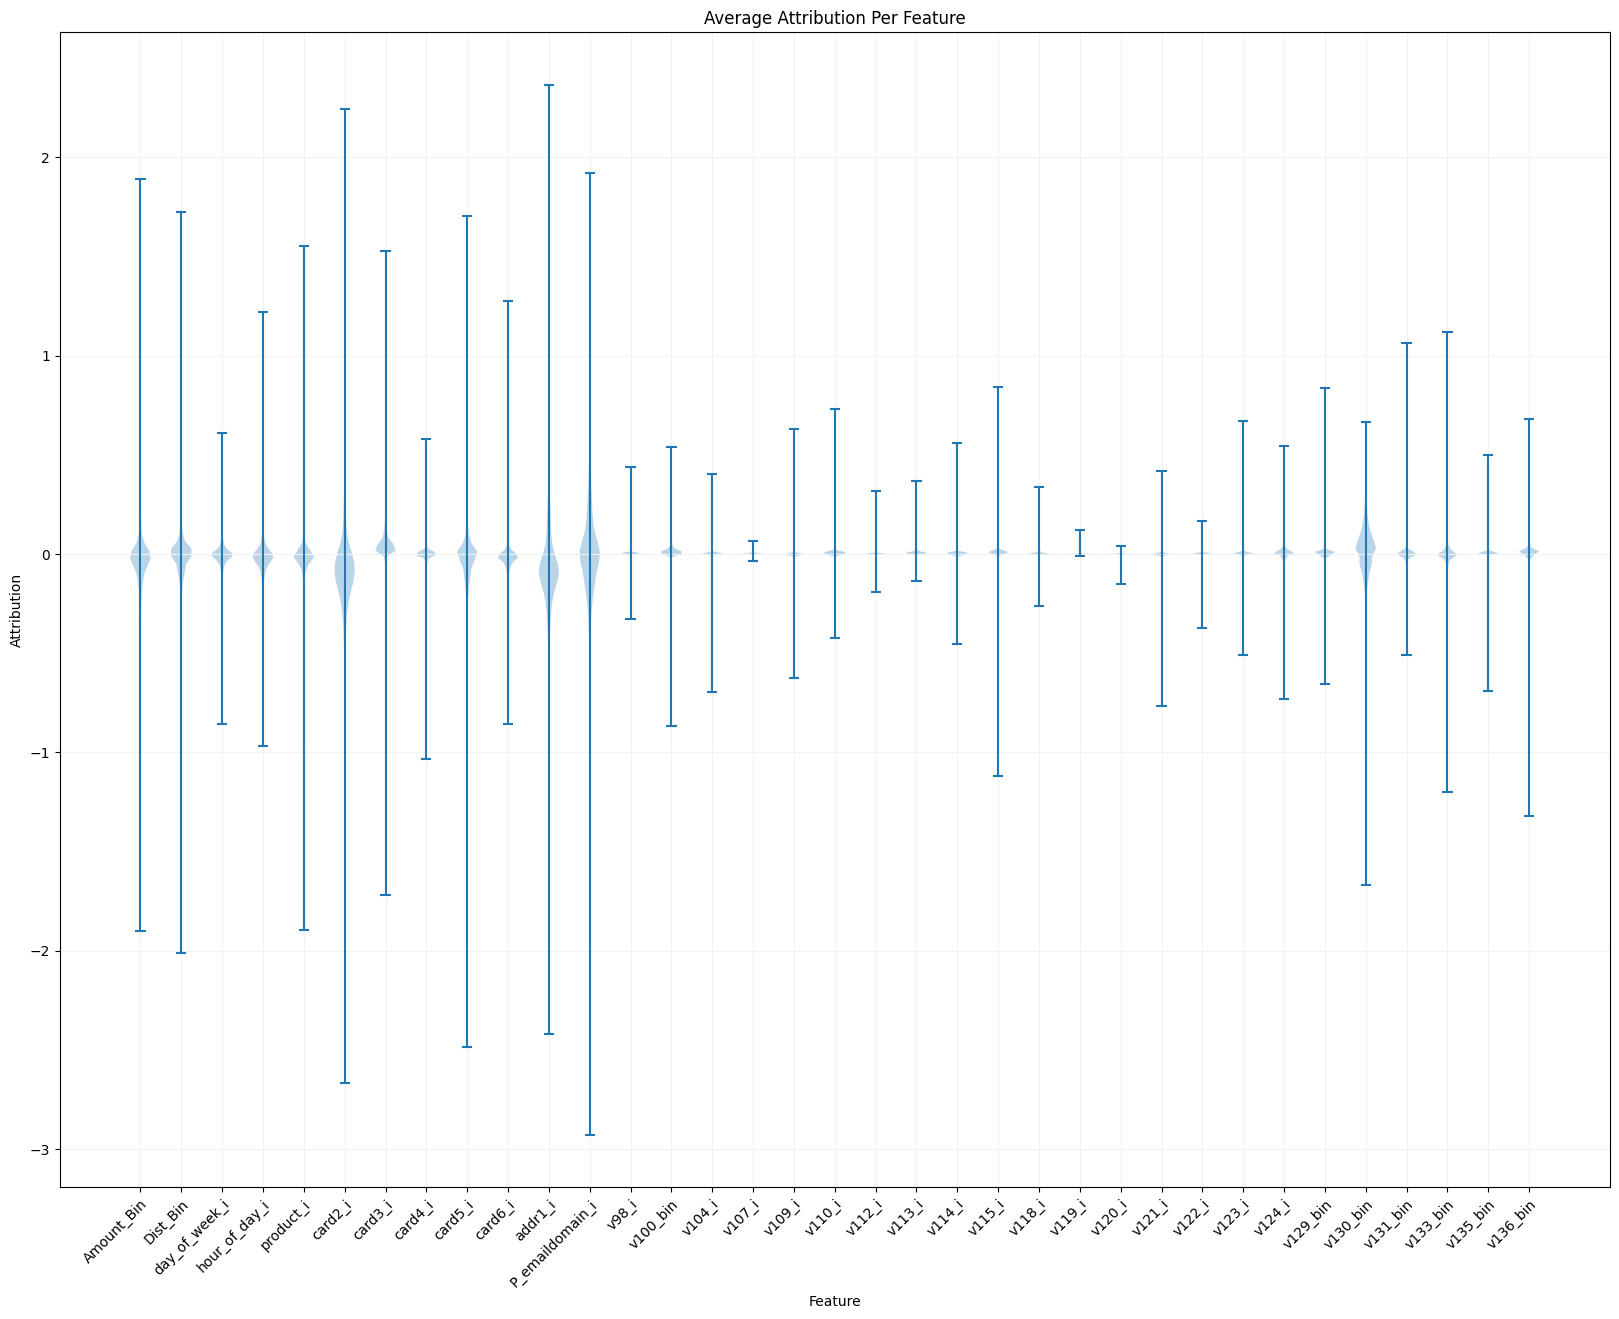

2023-06-01 10:41:50.041 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:41:50.041 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:41:50.041 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:41:50.041 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 1 =========
======== Start group 2 =========


2023-06-01 10:41:56.298 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:41:56.305 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 756.25it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93     48104
         1.0       0.18      0.62      0.27      1896

    accuracy                           0.88     50000
   macro avg       0.58      0.75      0.60     50000
weighted avg       0.95      0.88      0.91     50000


auc score : 0.8189
ap score  : 0.2614
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


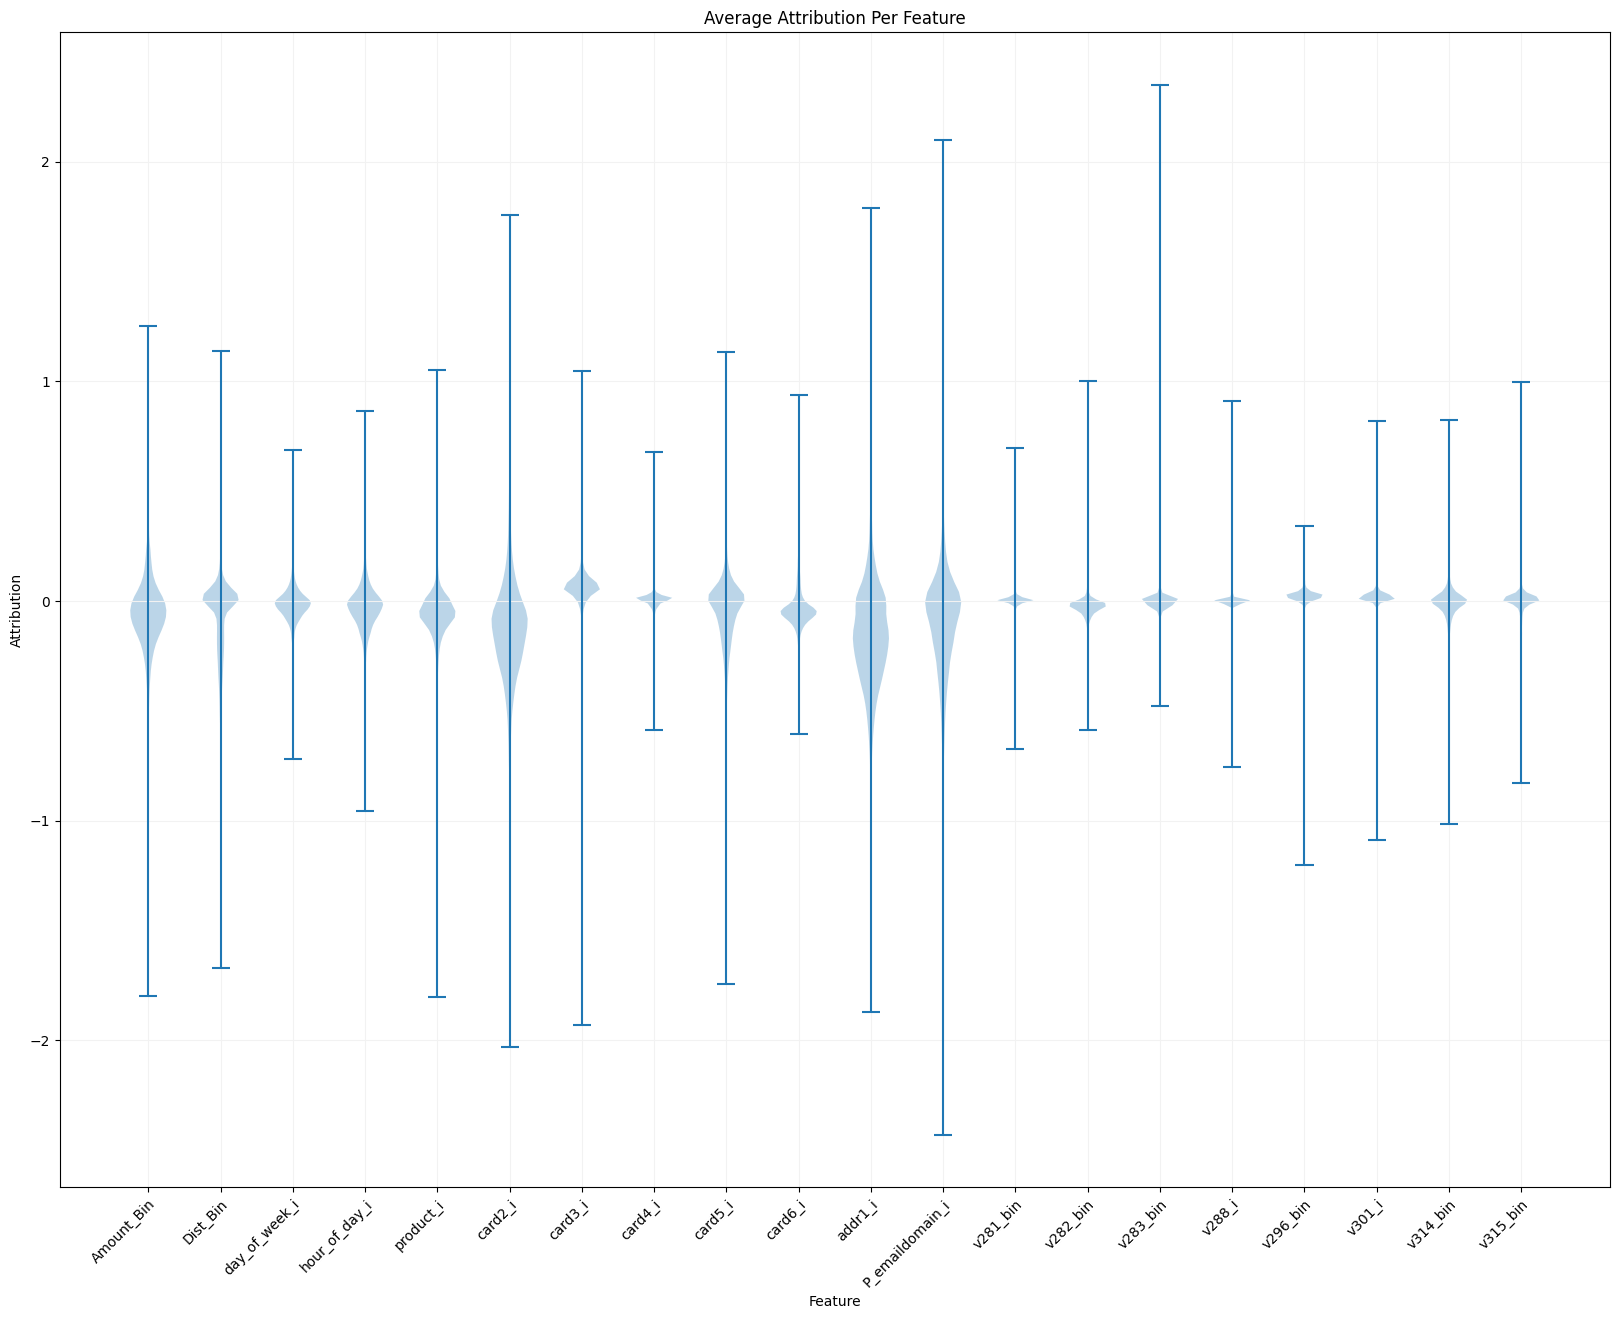

2023-06-01 10:43:01.444 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:43:01.445 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:43:01.445 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:43:01.446 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 2 =========
======== Start group 3 =========


2023-06-01 10:43:08.077 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:43:08.086 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 822.00it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.94     48104
         1.0       0.19      0.62      0.29      1896

    accuracy                           0.88     50000
   macro avg       0.58      0.76      0.61     50000
weighted avg       0.95      0.88      0.91     50000


auc score : 0.8390
ap score  : 0.3237
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


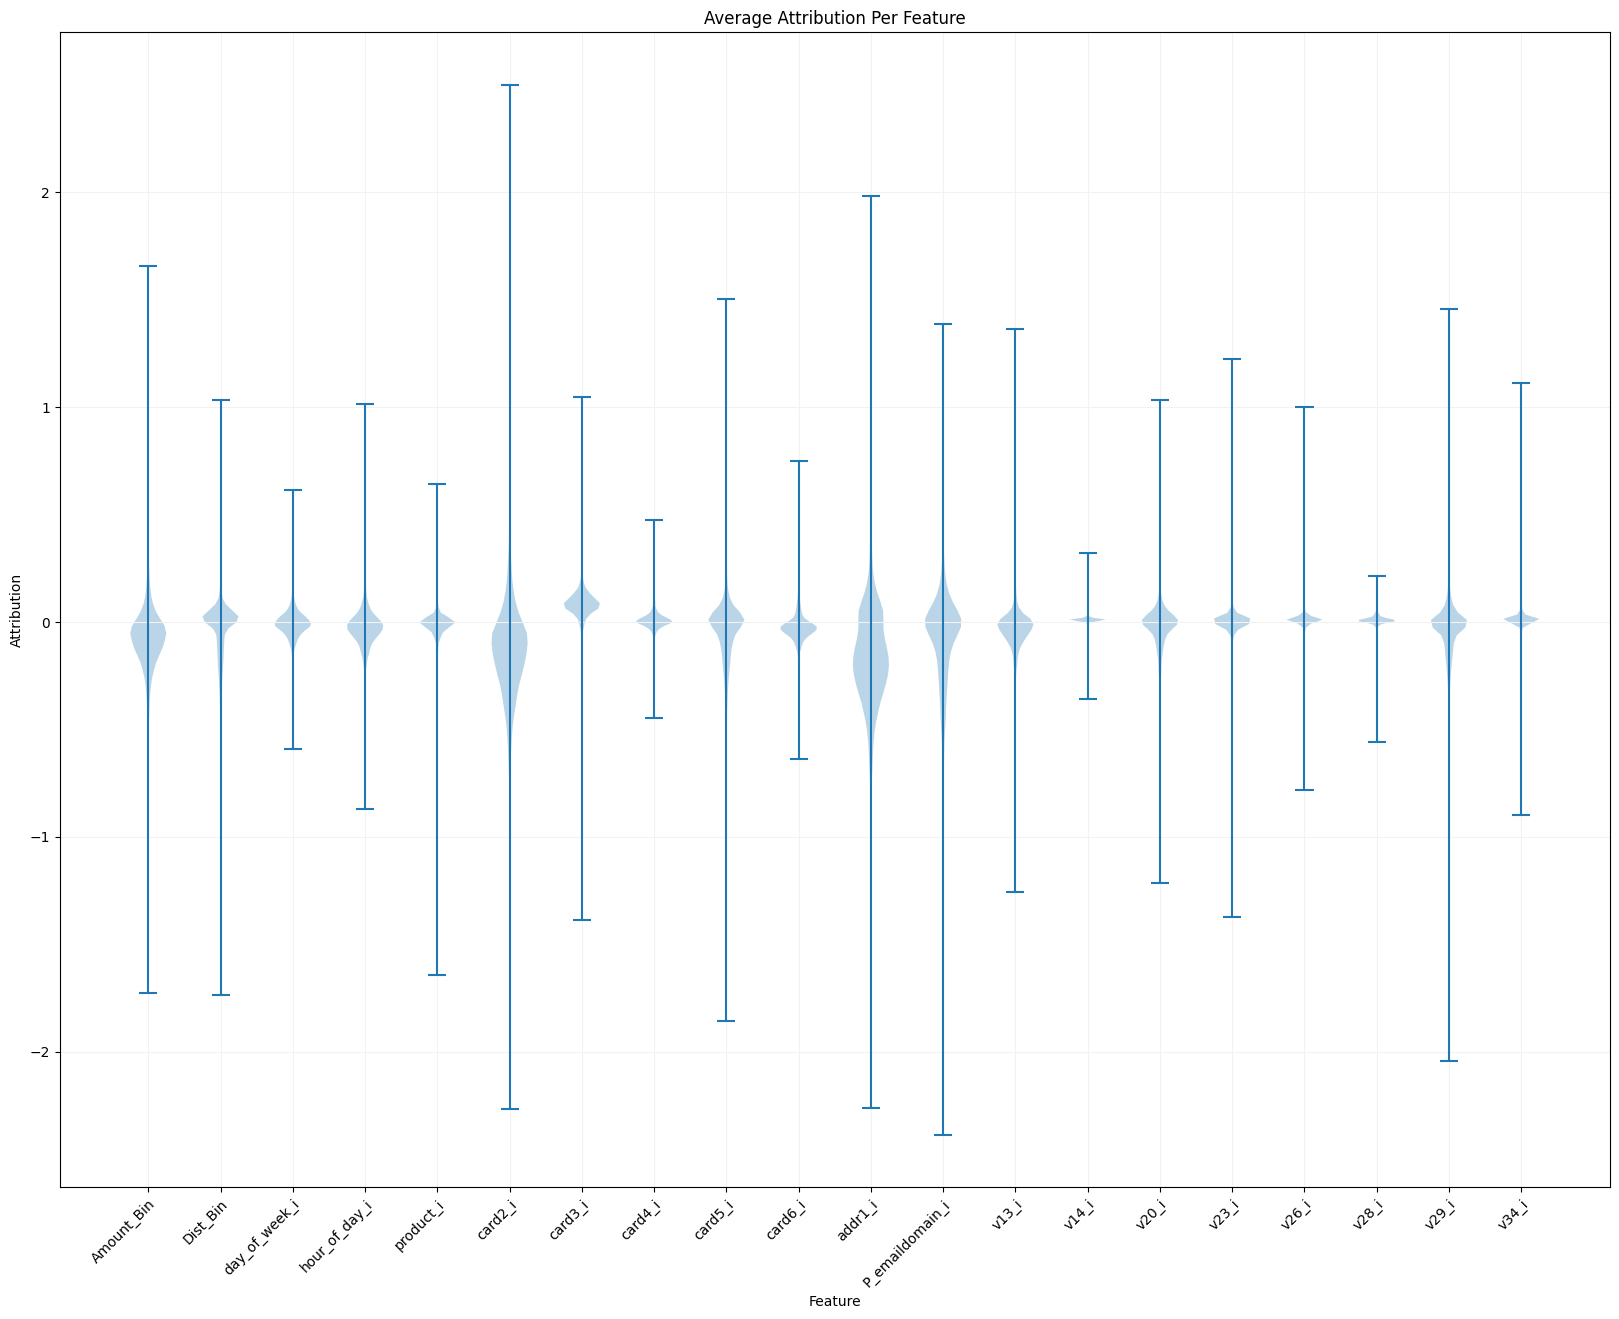

2023-06-01 10:44:13.415 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:44:13.416 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:44:13.416 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:44:13.417 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 3 =========
======== Start group 4 =========


2023-06-01 10:44:20.088 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:44:20.095 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 809.42it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.94     48104
         1.0       0.18      0.61      0.28      1896

    accuracy                           0.88     50000
   macro avg       0.58      0.75      0.61     50000
weighted avg       0.95      0.88      0.91     50000


auc score : 0.8468
ap score  : 0.2946
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


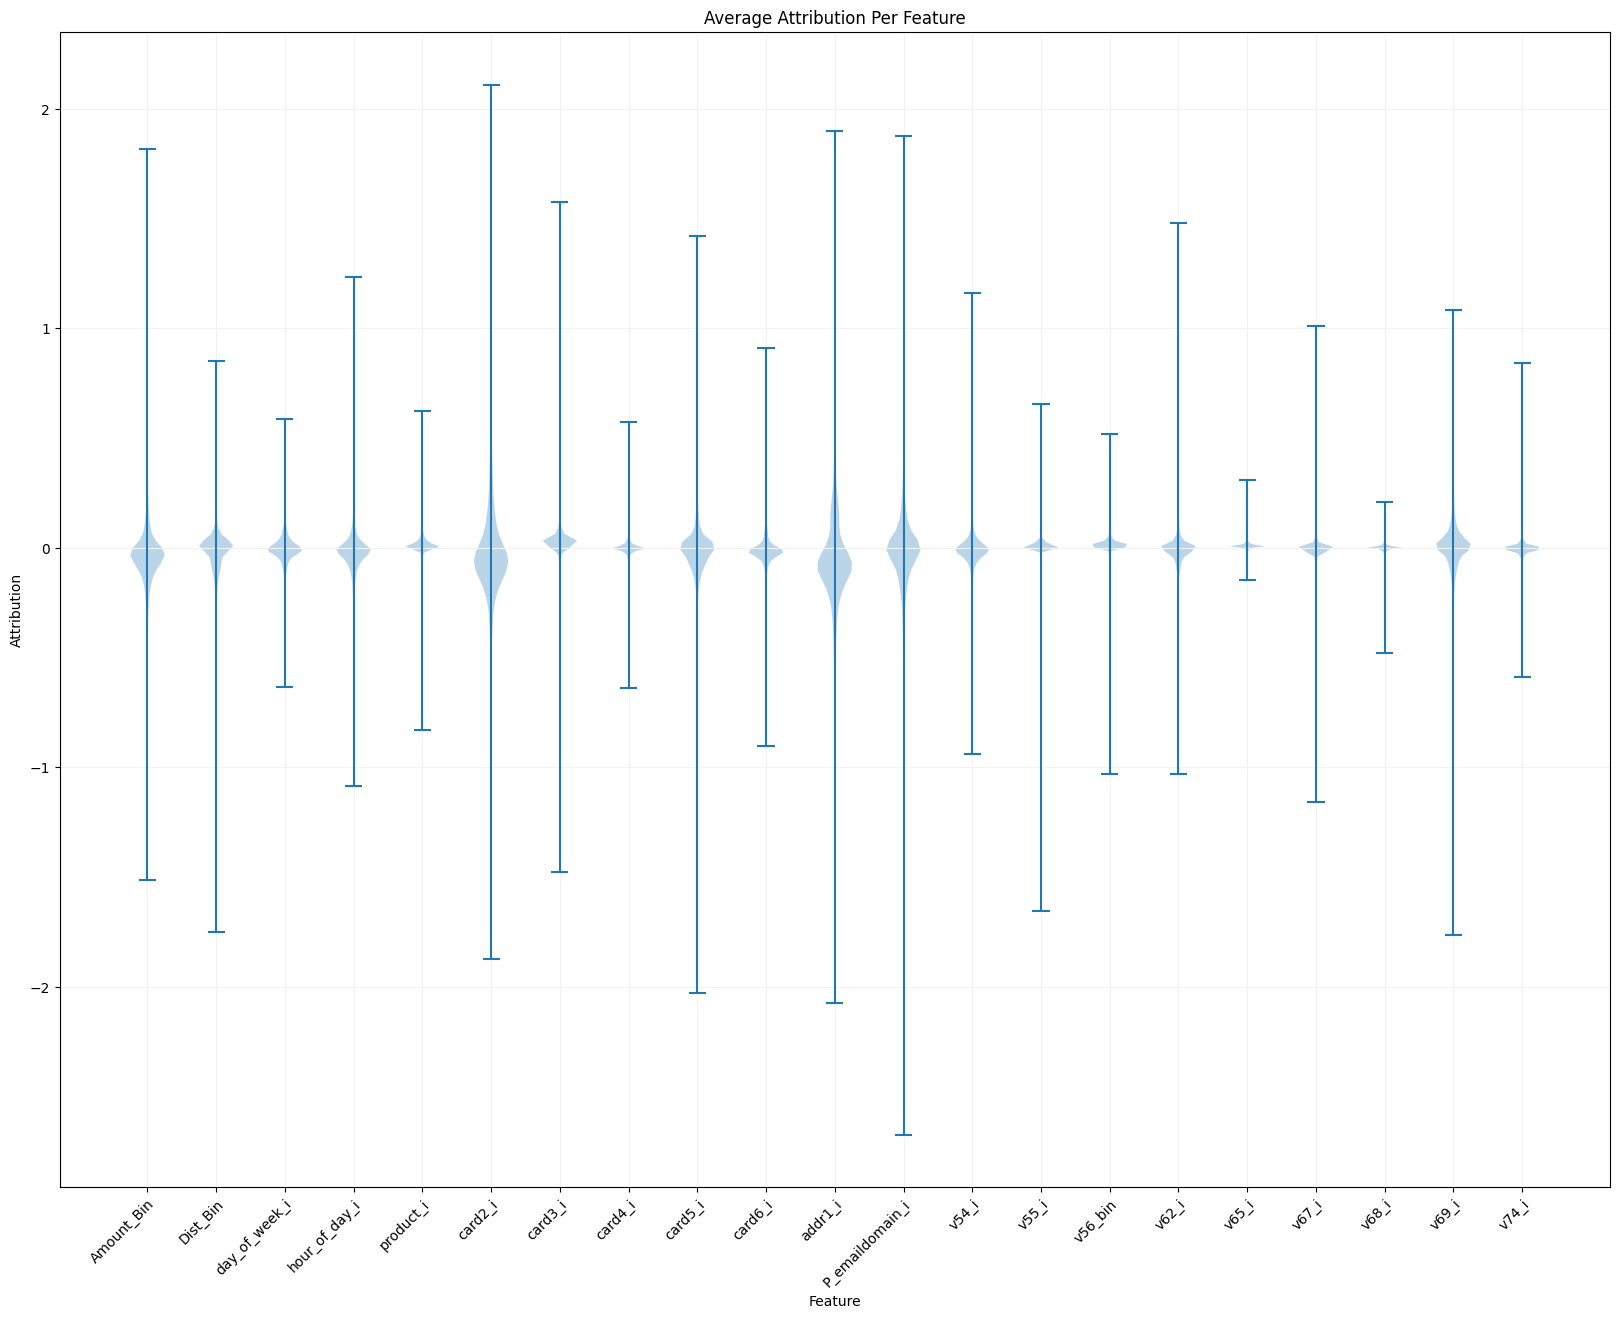

2023-06-01 10:45:26.213 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:45:26.213 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:45:26.213 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:45:26.214 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 4 =========
======== Start group 5 =========


2023-06-01 10:45:32.855 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:45:32.862 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 882.92it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94     48104
         1.0       0.20      0.63      0.30      1896

    accuracy                           0.89     50000
   macro avg       0.59      0.77      0.62     50000
weighted avg       0.95      0.89      0.92     50000


auc score : 0.8485
ap score  : 0.3627
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


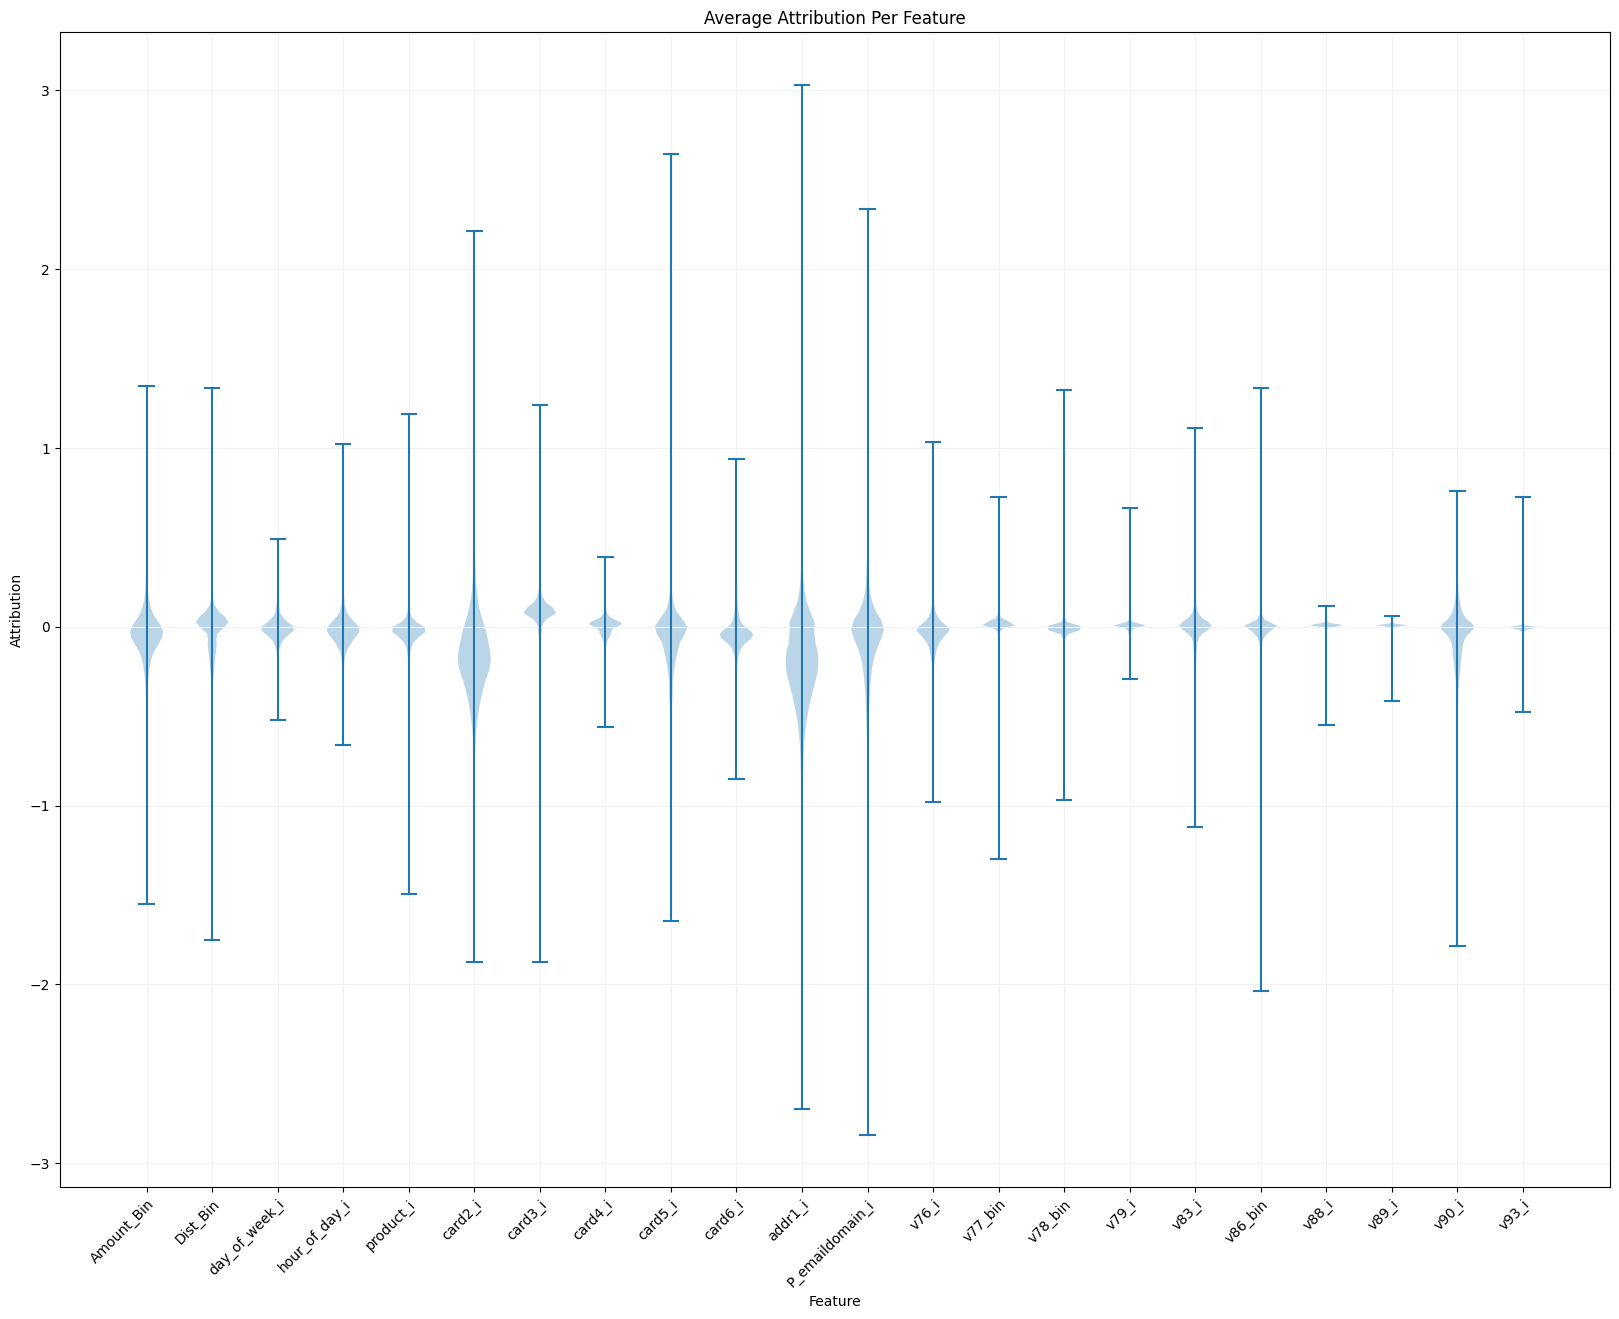

2023-06-01 10:46:39.854 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:46:39.854 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:46:39.855 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:46:39.855 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 5 =========
======== Start group 6 =========


2023-06-01 10:46:46.375 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:46:46.383 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 861.44it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93     48104
         1.0       0.18      0.61      0.27      1896

    accuracy                           0.88     50000
   macro avg       0.58      0.75      0.60     50000
weighted avg       0.95      0.88      0.91     50000


auc score : 0.8354
ap score  : 0.3432
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


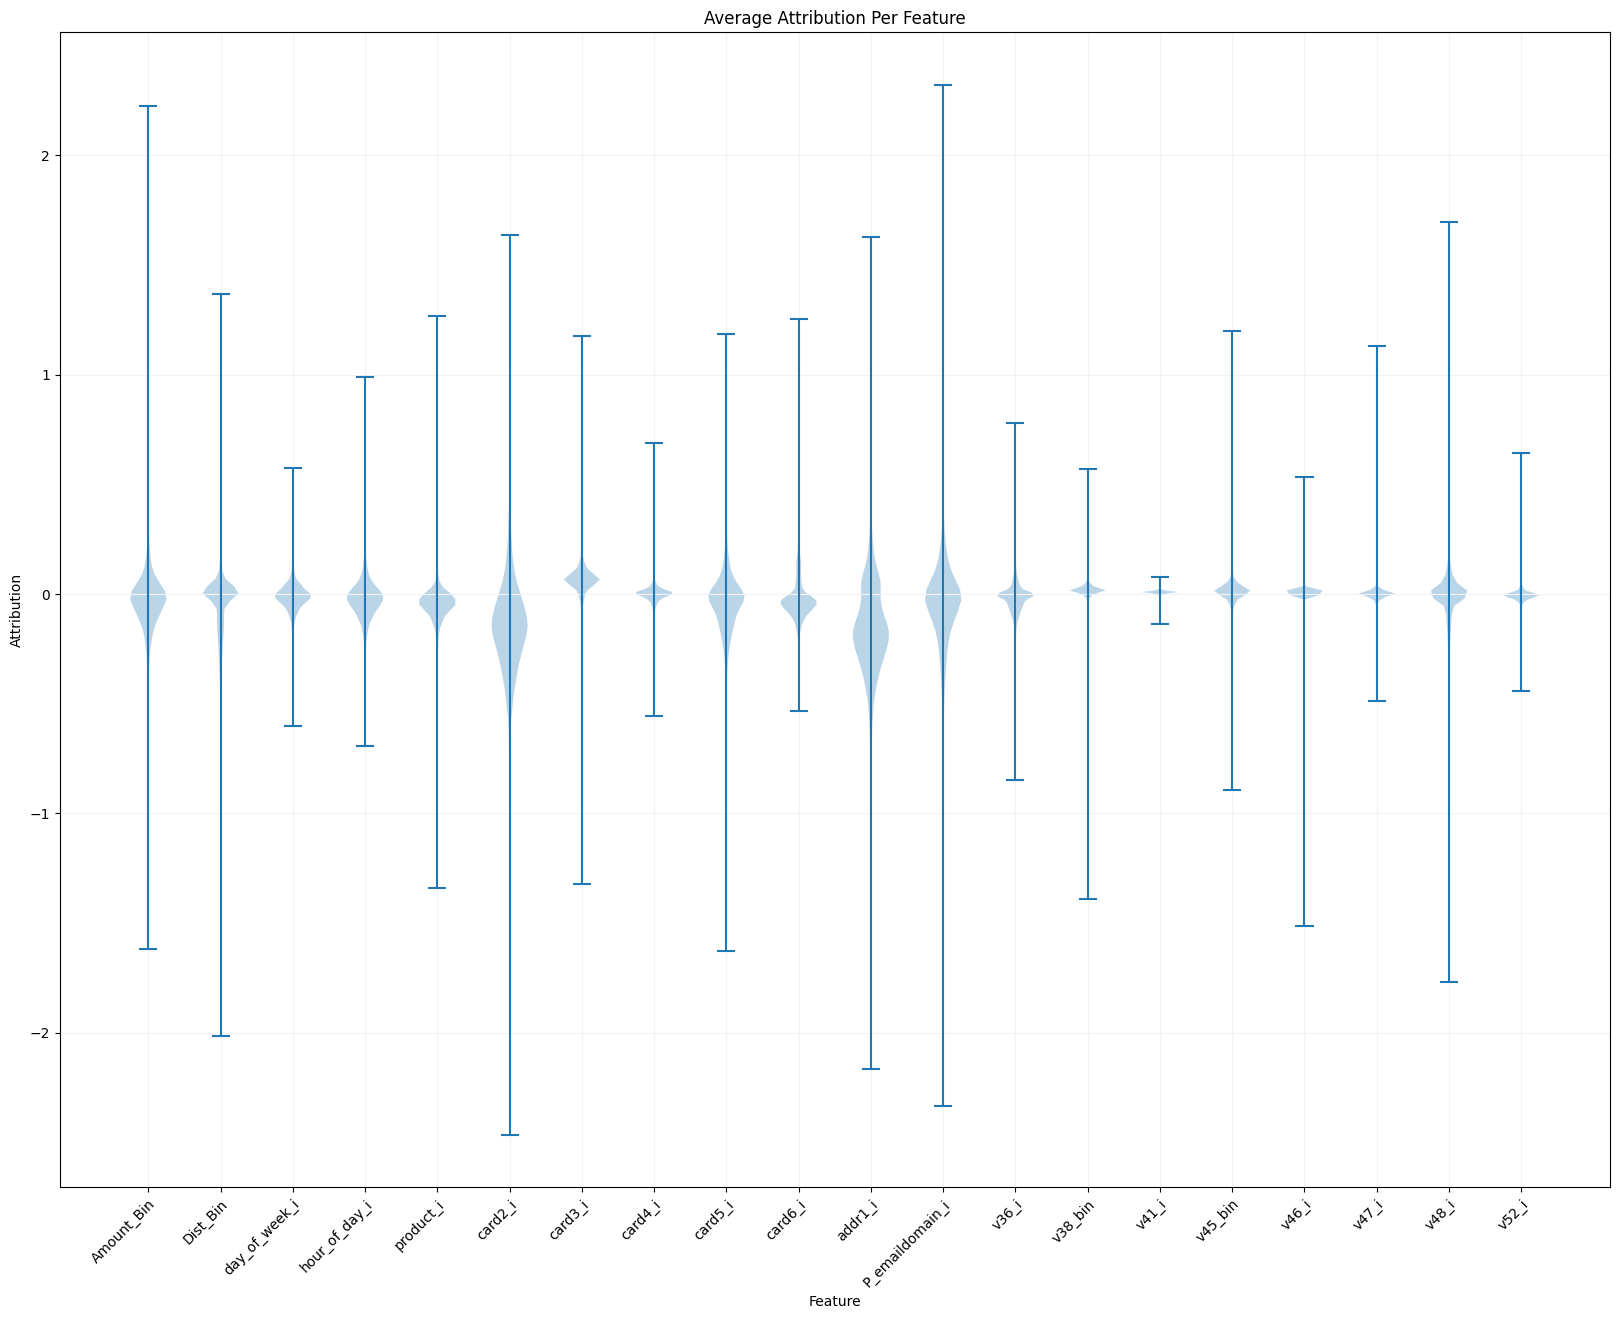

2023-06-01 10:47:50.690 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:47:50.690 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:47:50.690 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:47:50.691 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 6 =========
======== Start group 7 =========


2023-06-01 10:47:57.320 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:47:57.327 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 851.56it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93     48104
         1.0       0.17      0.62      0.26      1896

    accuracy                           0.87     50000
   macro avg       0.58      0.75      0.60     50000
weighted avg       0.95      0.87      0.90     50000


auc score : 0.8393
ap score  : 0.2685
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


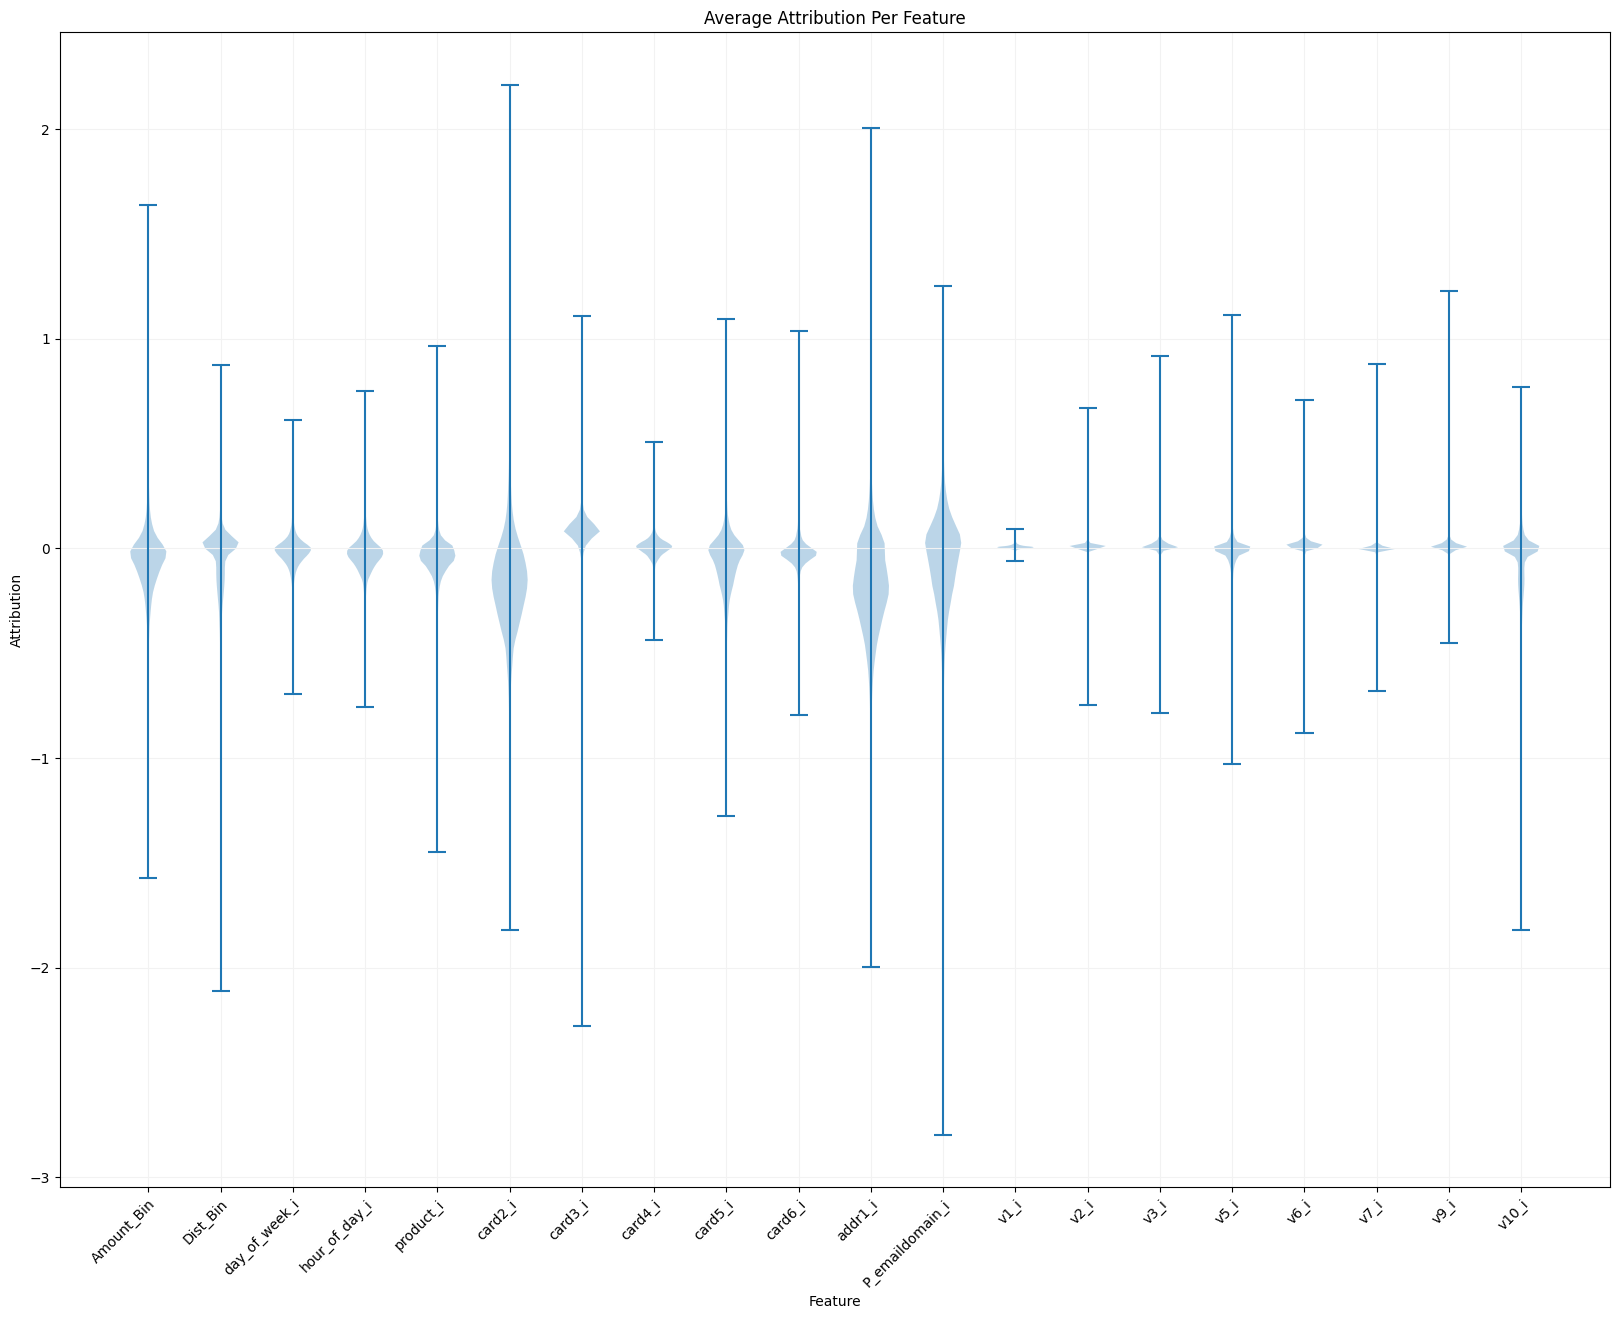

2023-06-01 10:49:02.314 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:49:02.314 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:49:02.315 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:49:02.315 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 7 =========
======== Start group 8 =========


2023-06-01 10:49:08.521 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:49:08.528 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 800.53it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93     48104
         1.0       0.16      0.59      0.25      1896

    accuracy                           0.87     50000
   macro avg       0.57      0.74      0.59     50000
weighted avg       0.95      0.87      0.90     50000


auc score : 0.8152
ap score  : 0.2654
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


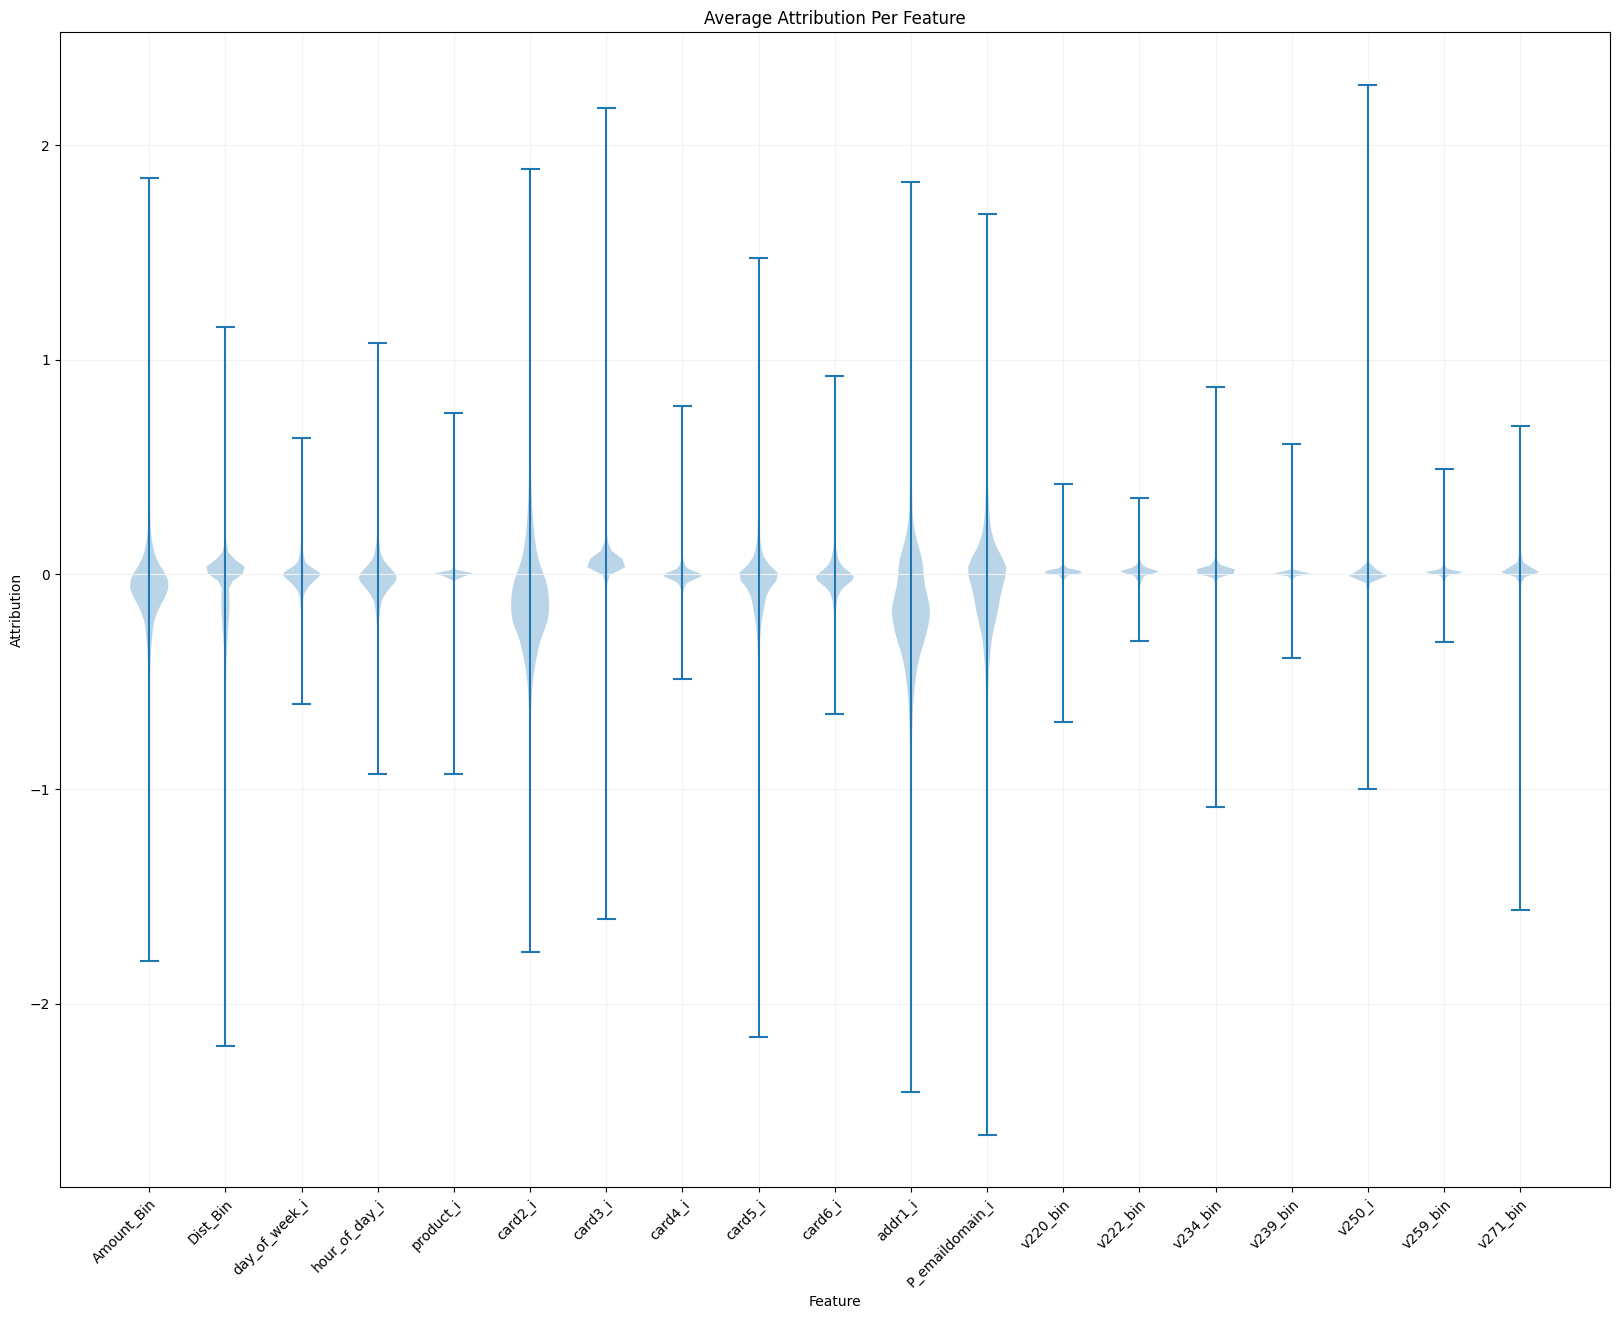

2023-06-01 10:50:12.643 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:50:12.644 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:50:12.644 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:50:12.644 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 8 =========
======== Start group 9 =========


2023-06-01 10:50:19.132 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:50:19.141 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 798.31it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93     48104
         1.0       0.18      0.64      0.29      1896

    accuracy                           0.88     50000
   macro avg       0.58      0.76      0.61     50000
weighted avg       0.95      0.88      0.91     50000


auc score : 0.8370
ap score  : 0.4125
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


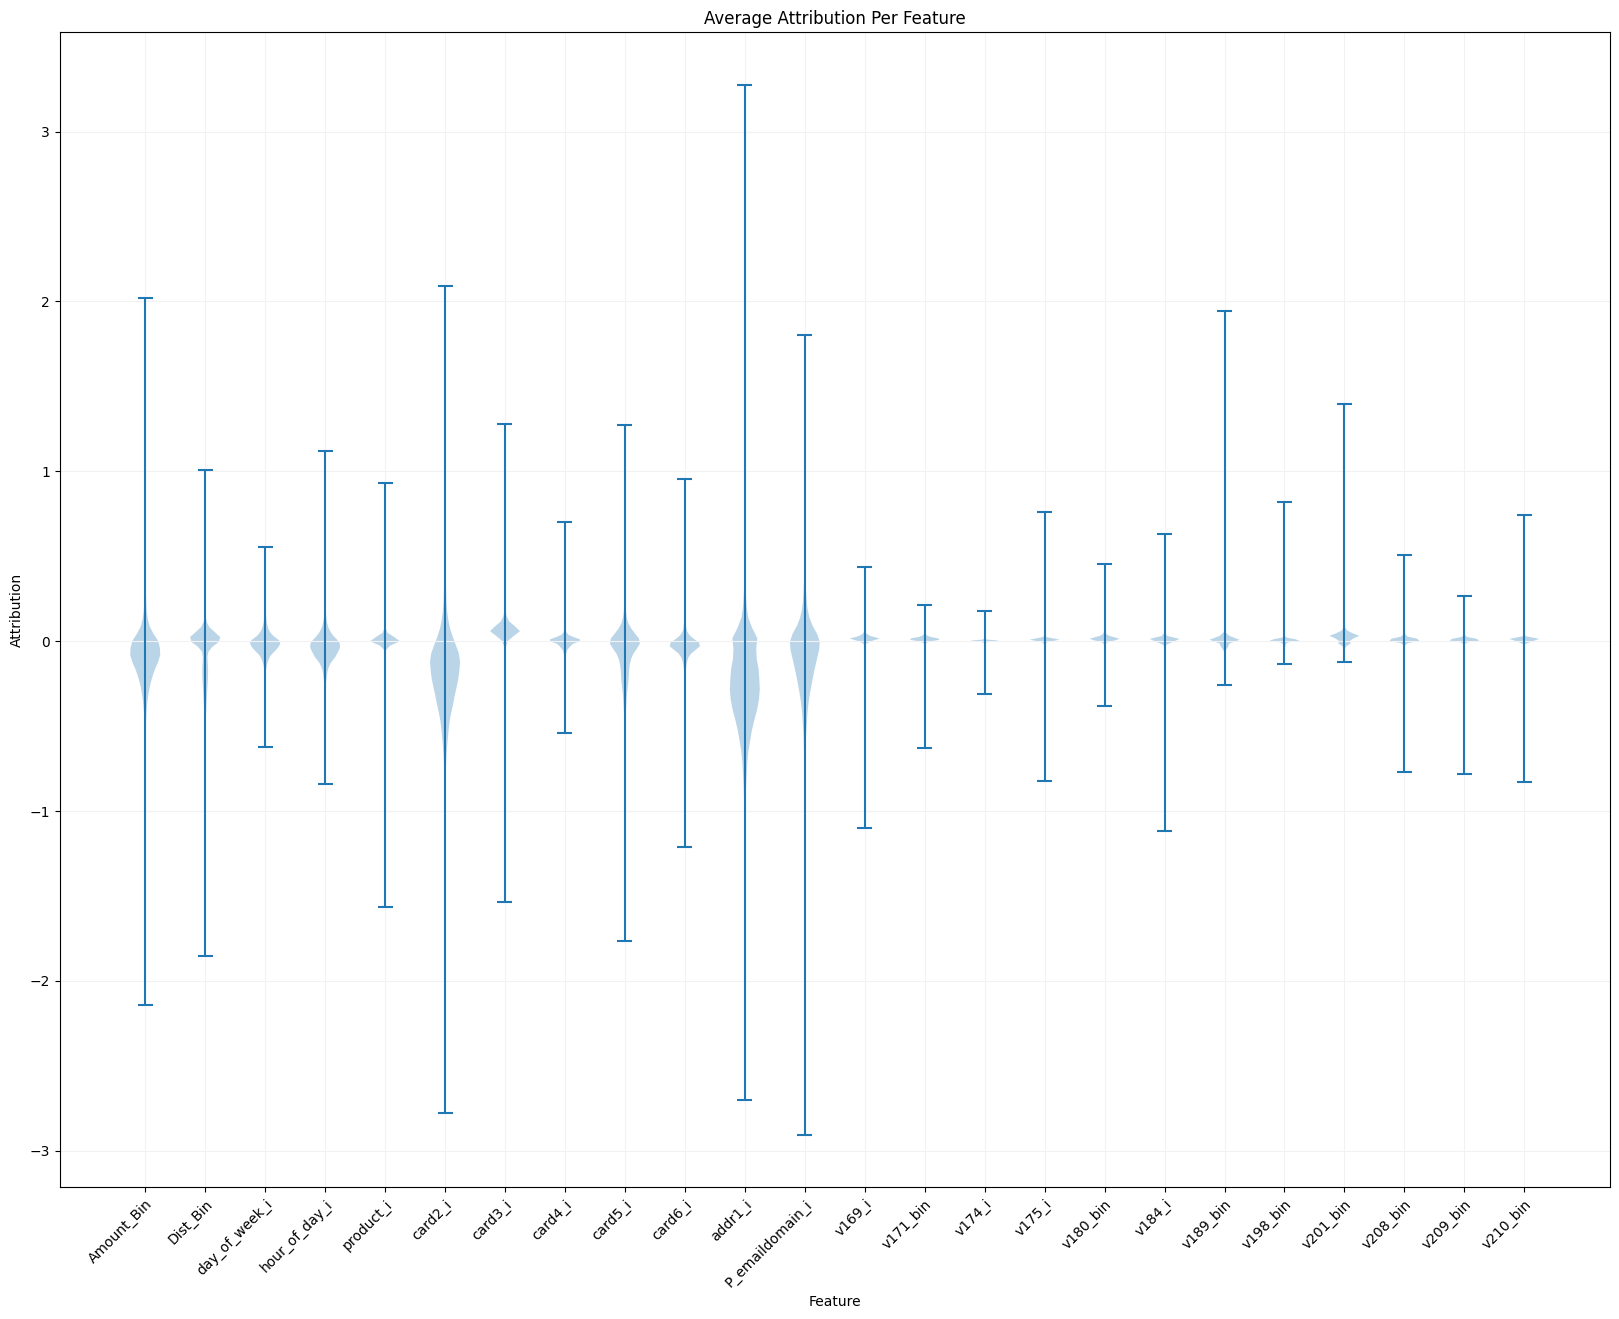

2023-06-01 10:51:28.085 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:51:28.086 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:51:28.086 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:51:28.086 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 9 =========
======== Start group 10 =========


2023-06-01 10:51:34.419 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:51:34.426 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 859.35it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93     48104
         1.0       0.18      0.65      0.28      1896

    accuracy                           0.87     50000
   macro avg       0.58      0.77      0.61     50000
weighted avg       0.95      0.87      0.91     50000


auc score : 0.8447
ap score  : 0.4025
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


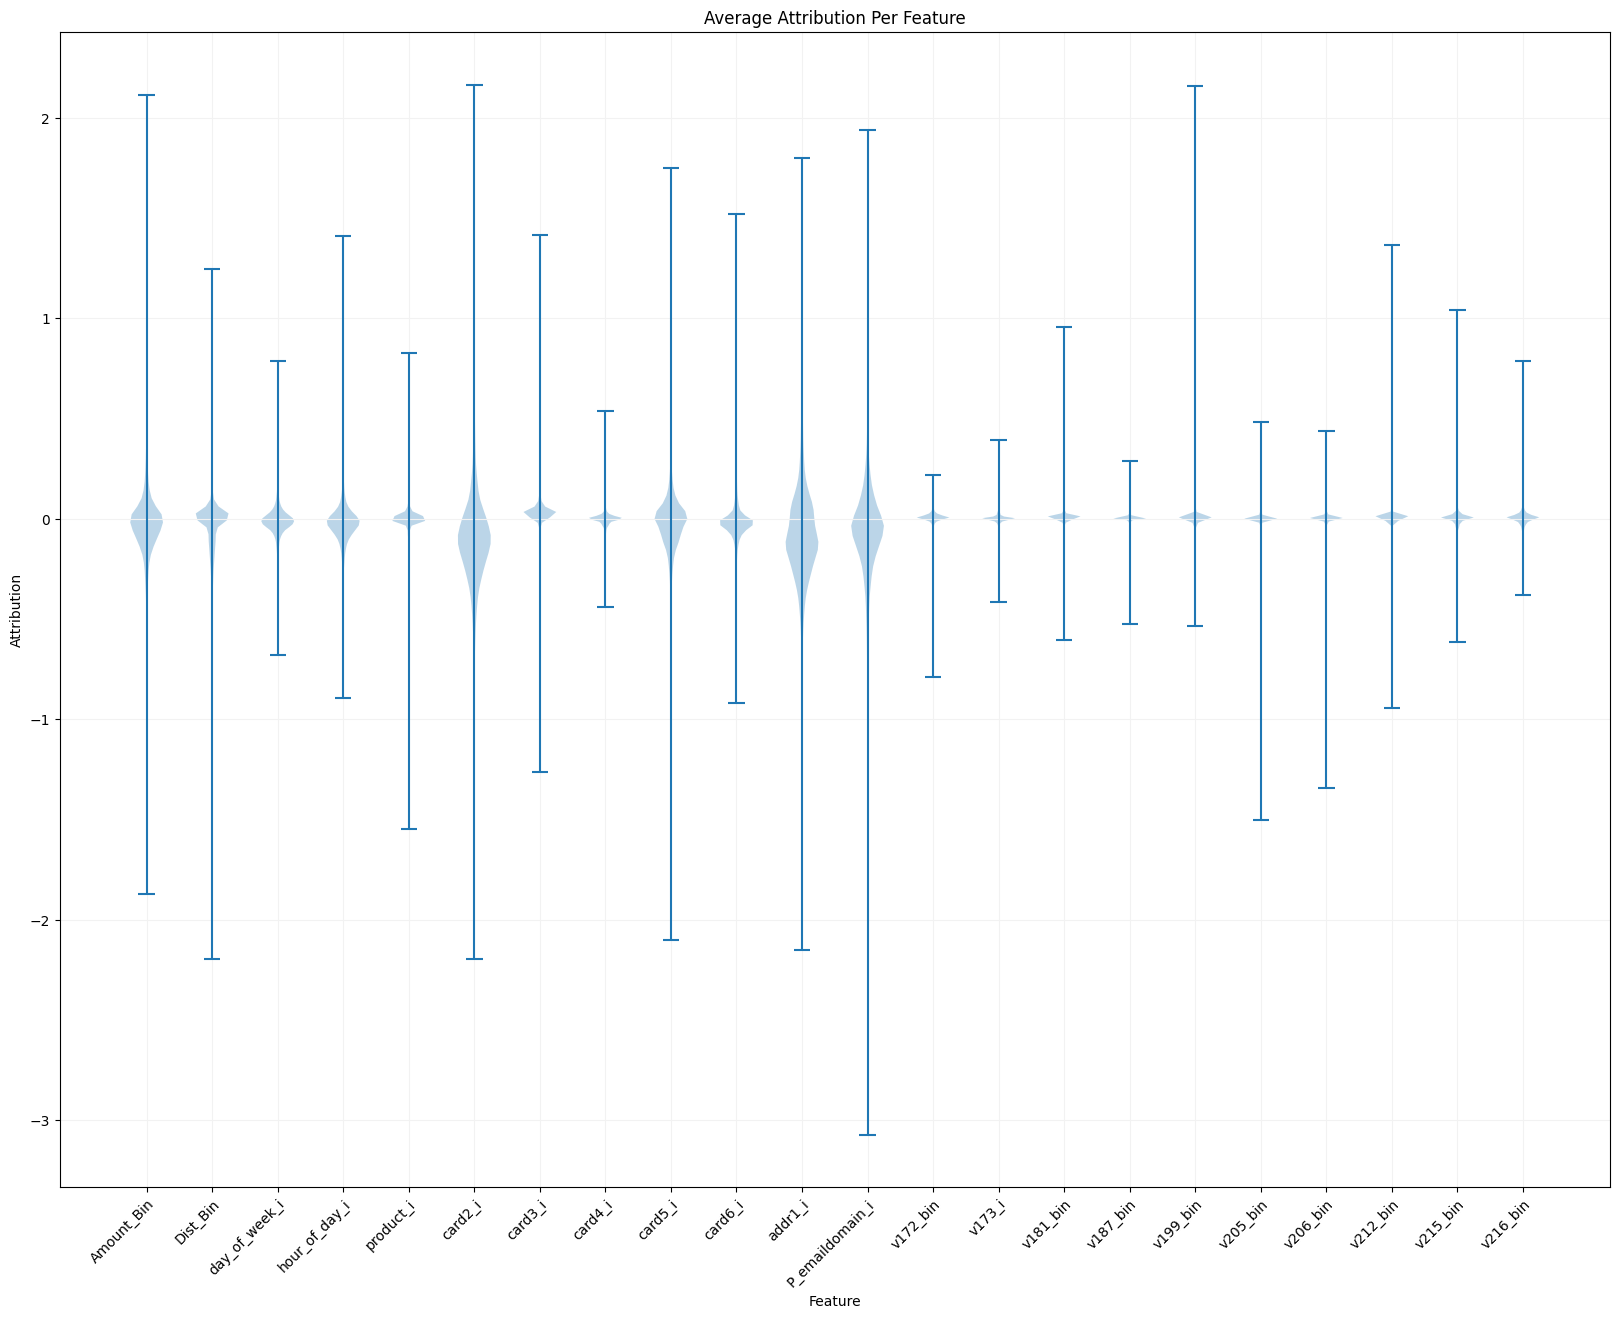

2023-06-01 10:52:41.933 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:52:41.933 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:52:41.933 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:52:41.934 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 10 =========
======== Start group 11 =========


2023-06-01 10:52:48.474 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:52:48.482 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 690.77it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.94     48104
         1.0       0.18      0.61      0.28      1896

    accuracy                           0.88     50000
   macro avg       0.58      0.75      0.61     50000
weighted avg       0.95      0.88      0.91     50000


auc score : 0.8287
ap score  : 0.3850
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


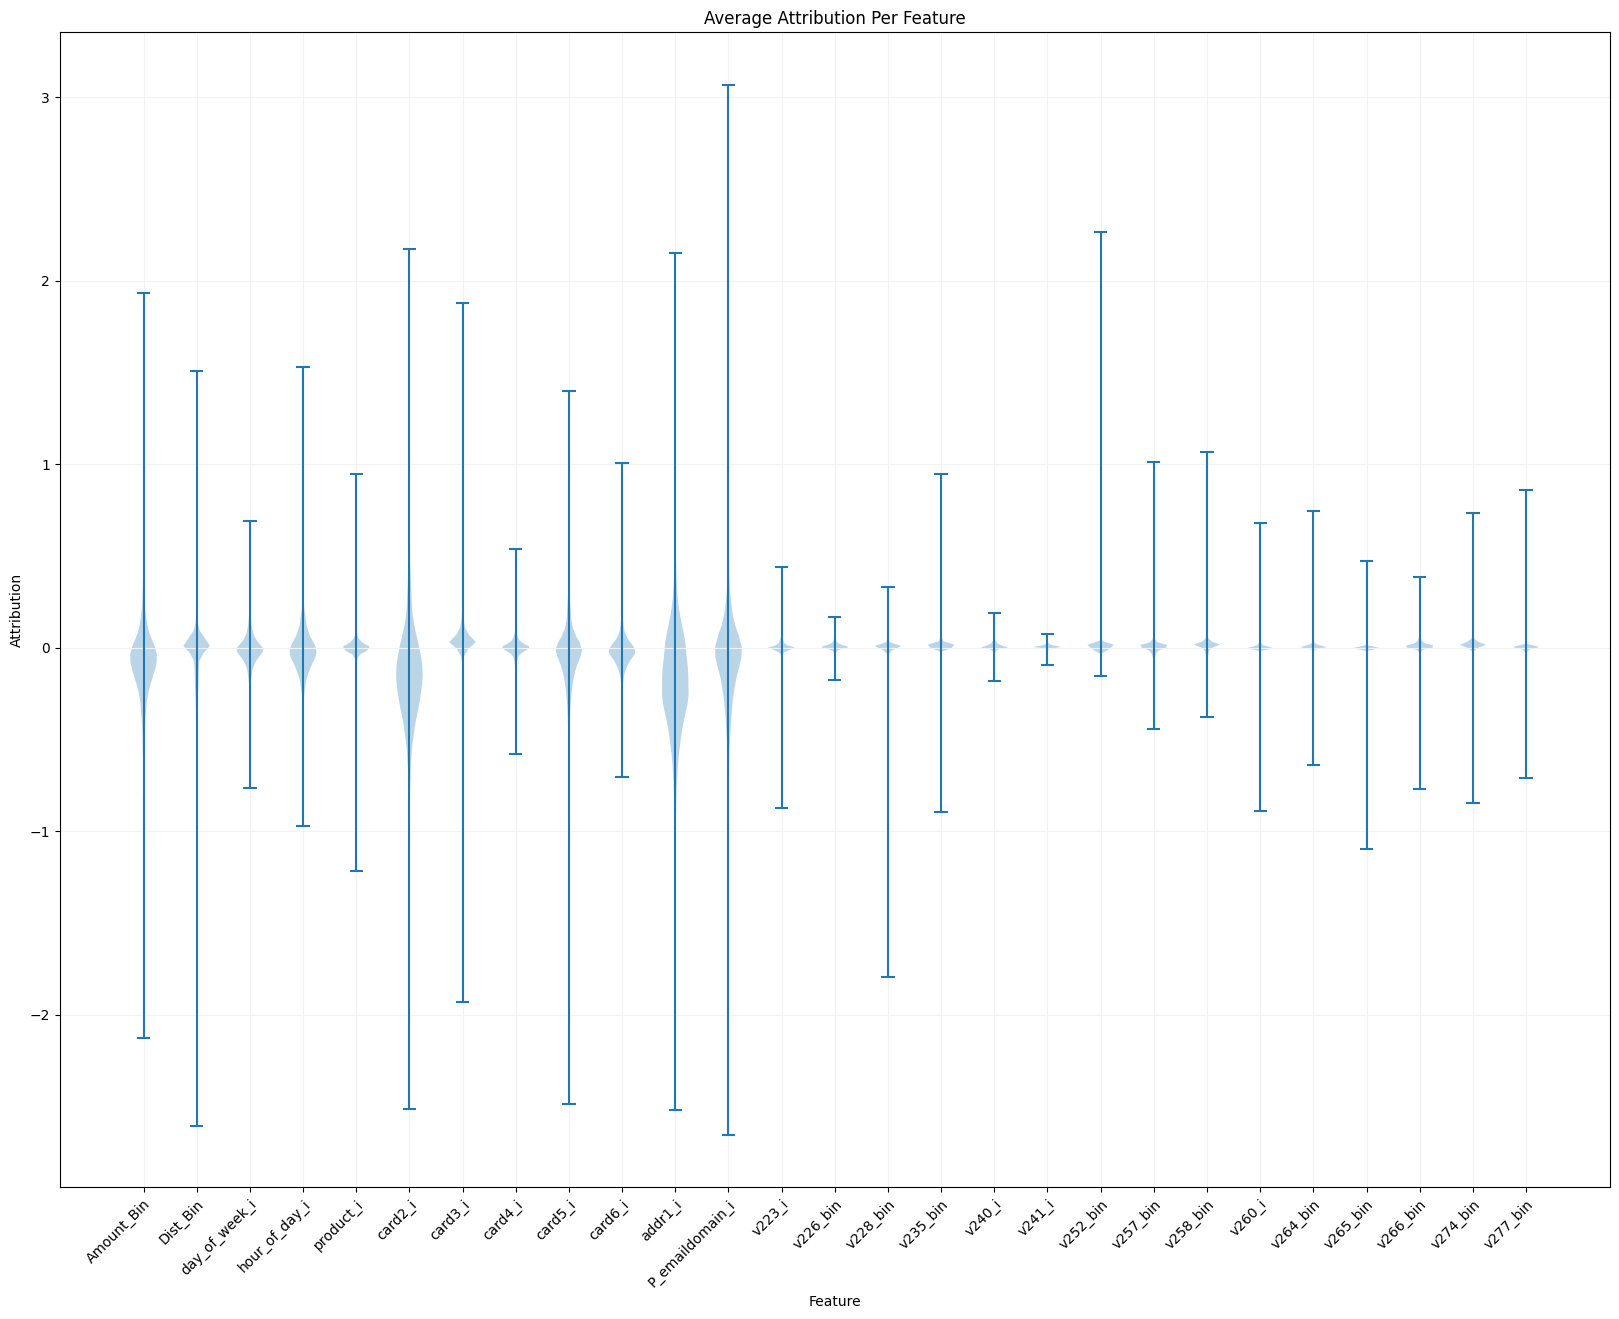

2023-06-01 10:54:00.087 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:54:00.087 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:54:00.087 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:54:00.088 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 11 =========
======== Start group 12 =========


2023-06-01 10:54:06.335 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:54:06.343 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 847.21it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     48104
         1.0       0.15      0.59      0.24      1896

    accuracy                           0.86     50000
   macro avg       0.57      0.73      0.58     50000
weighted avg       0.95      0.86      0.89     50000


auc score : 0.8124
ap score  : 0.2409
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


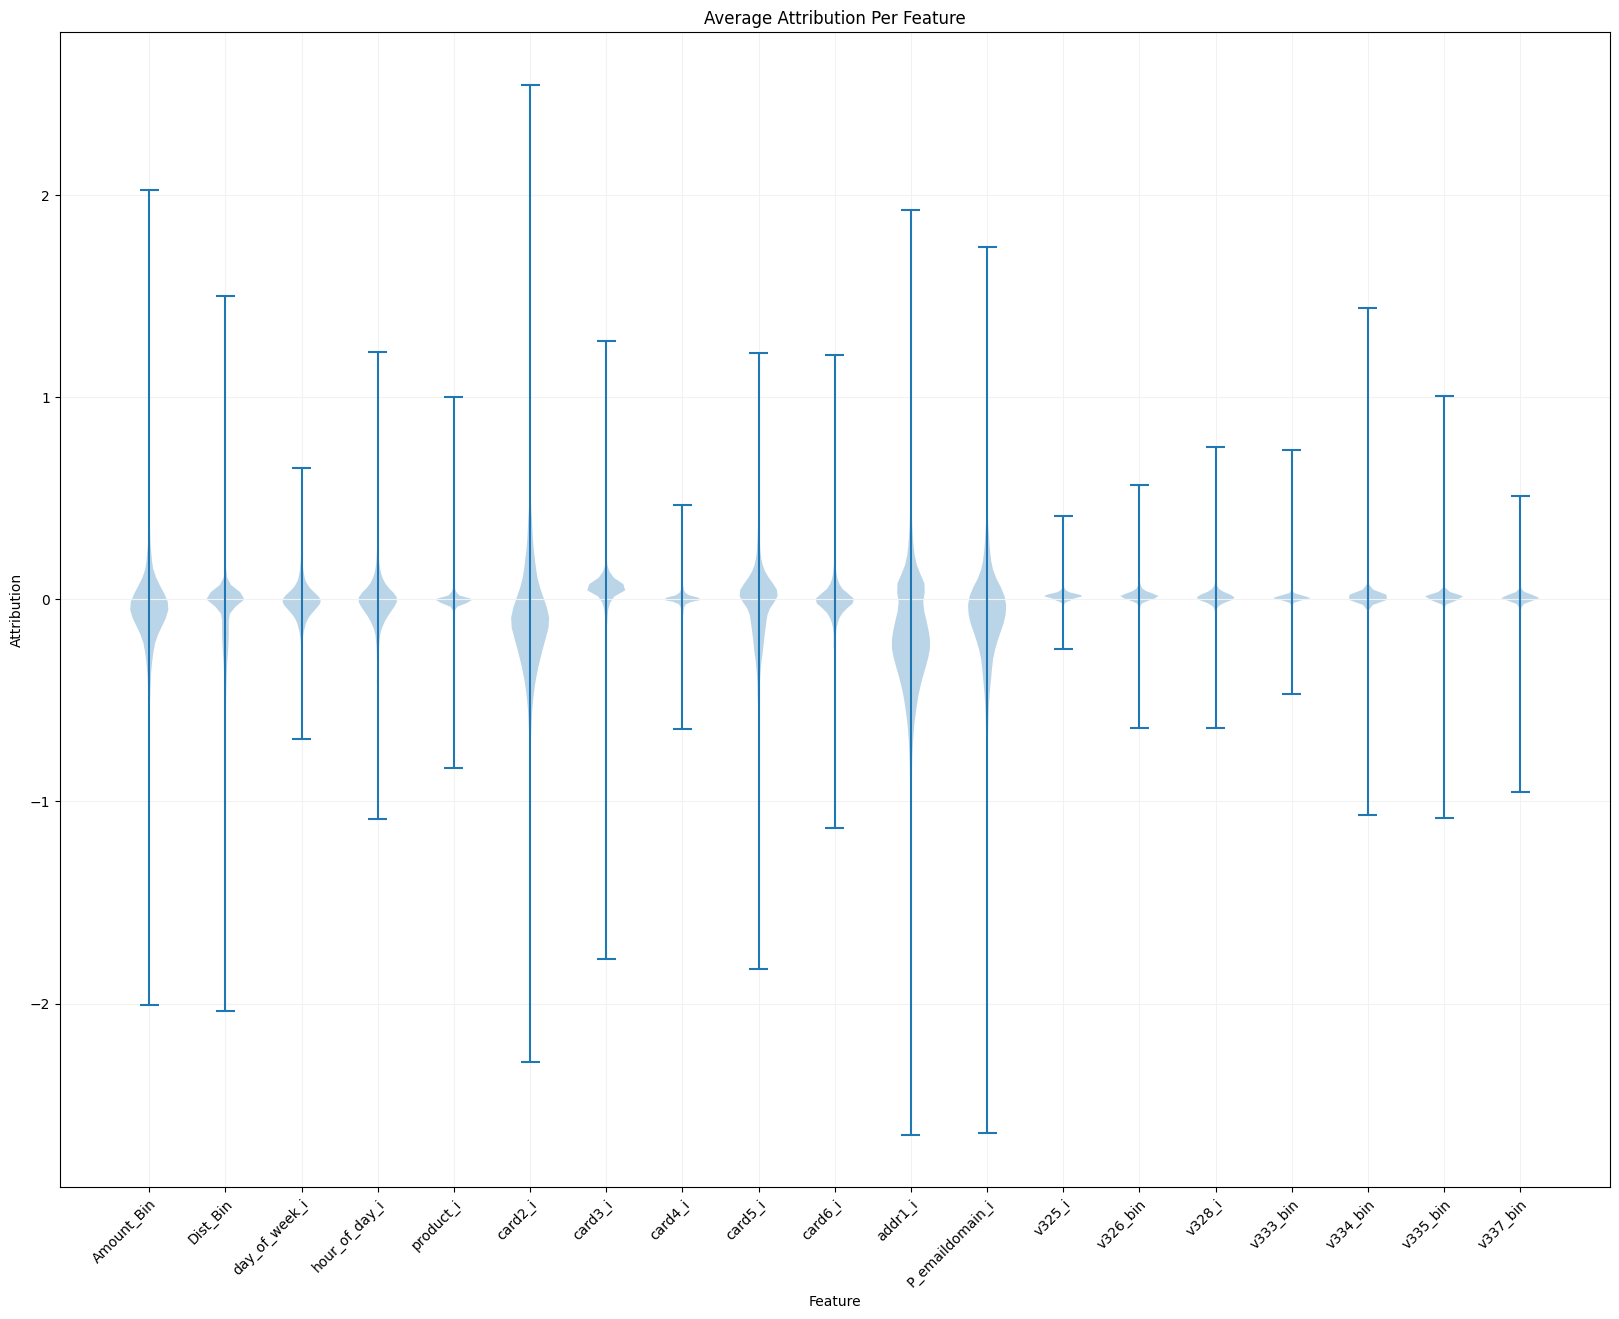

2023-06-01 10:55:11.005 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:55:11.005 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:55:11.005 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:55:11.006 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 12 =========
======== Start group 13 =========


2023-06-01 10:55:17.073 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:55:17.078 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 864.64it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.93     48104
         1.0       0.17      0.64      0.26      1896

    accuracy                           0.86     50000
   macro avg       0.58      0.76      0.59     50000
weighted avg       0.95      0.86      0.90     50000


auc score : 0.8254
ap score  : 0.2898
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


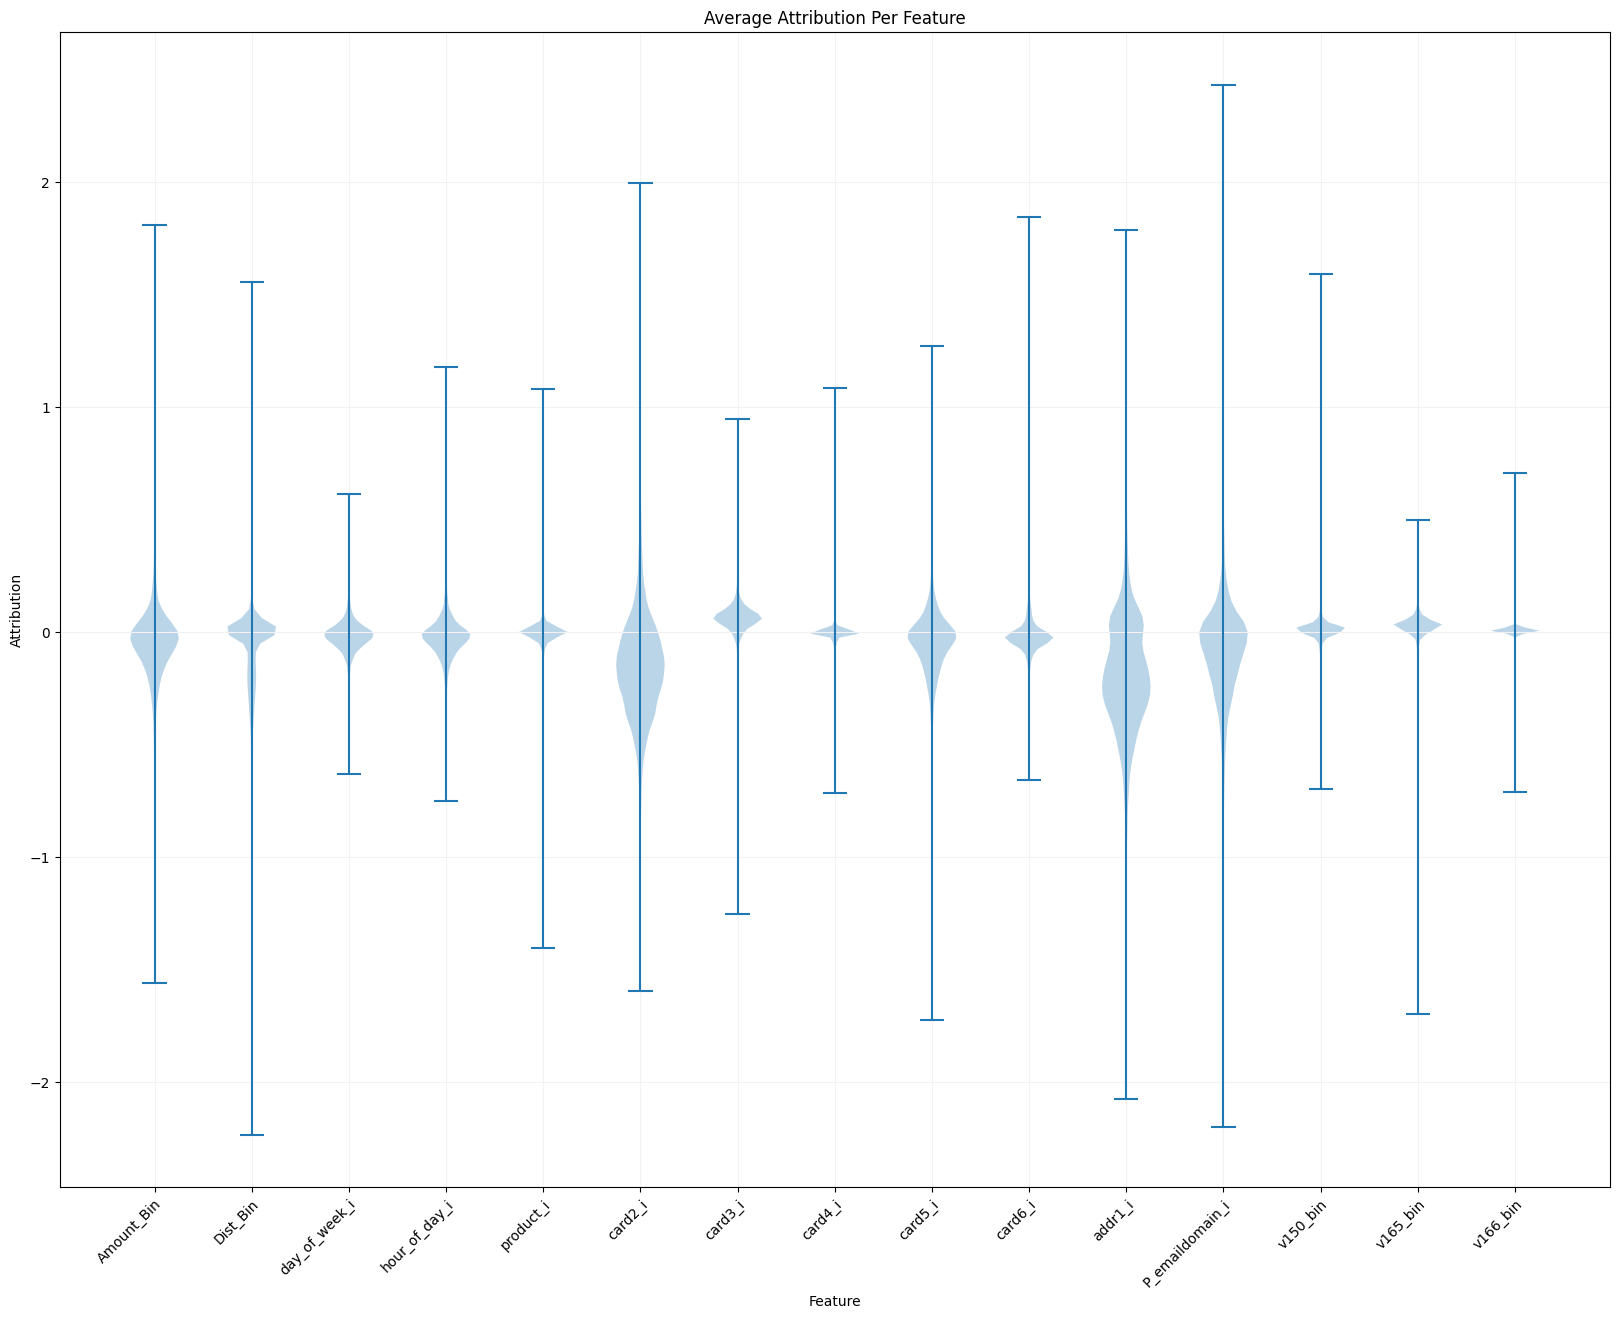

2023-06-01 10:56:16.614 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:56:16.614 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:56:16.614 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:56:16.615 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv


======== End group 13 =========
======== Start group 14 =========


2023-06-01 10:56:22.801 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:56:22.808 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 3 numpy arrays
Testing in 391 steps: 100%|██████████████████| 391/391 [00:00<00:00, 859.60it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     48104
         1.0       0.16      0.64      0.26      1896

    accuracy                           0.86     50000
   macro avg       0.57      0.75      0.59     50000
weighted avg       0.95      0.86      0.90     50000


auc score : 0.8374
ap score  : 0.3109
-----------------------------------------------------


/home/toms/Jupyter/lib/python3.10/site-packages/captum/attr/_models/base.py:191: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


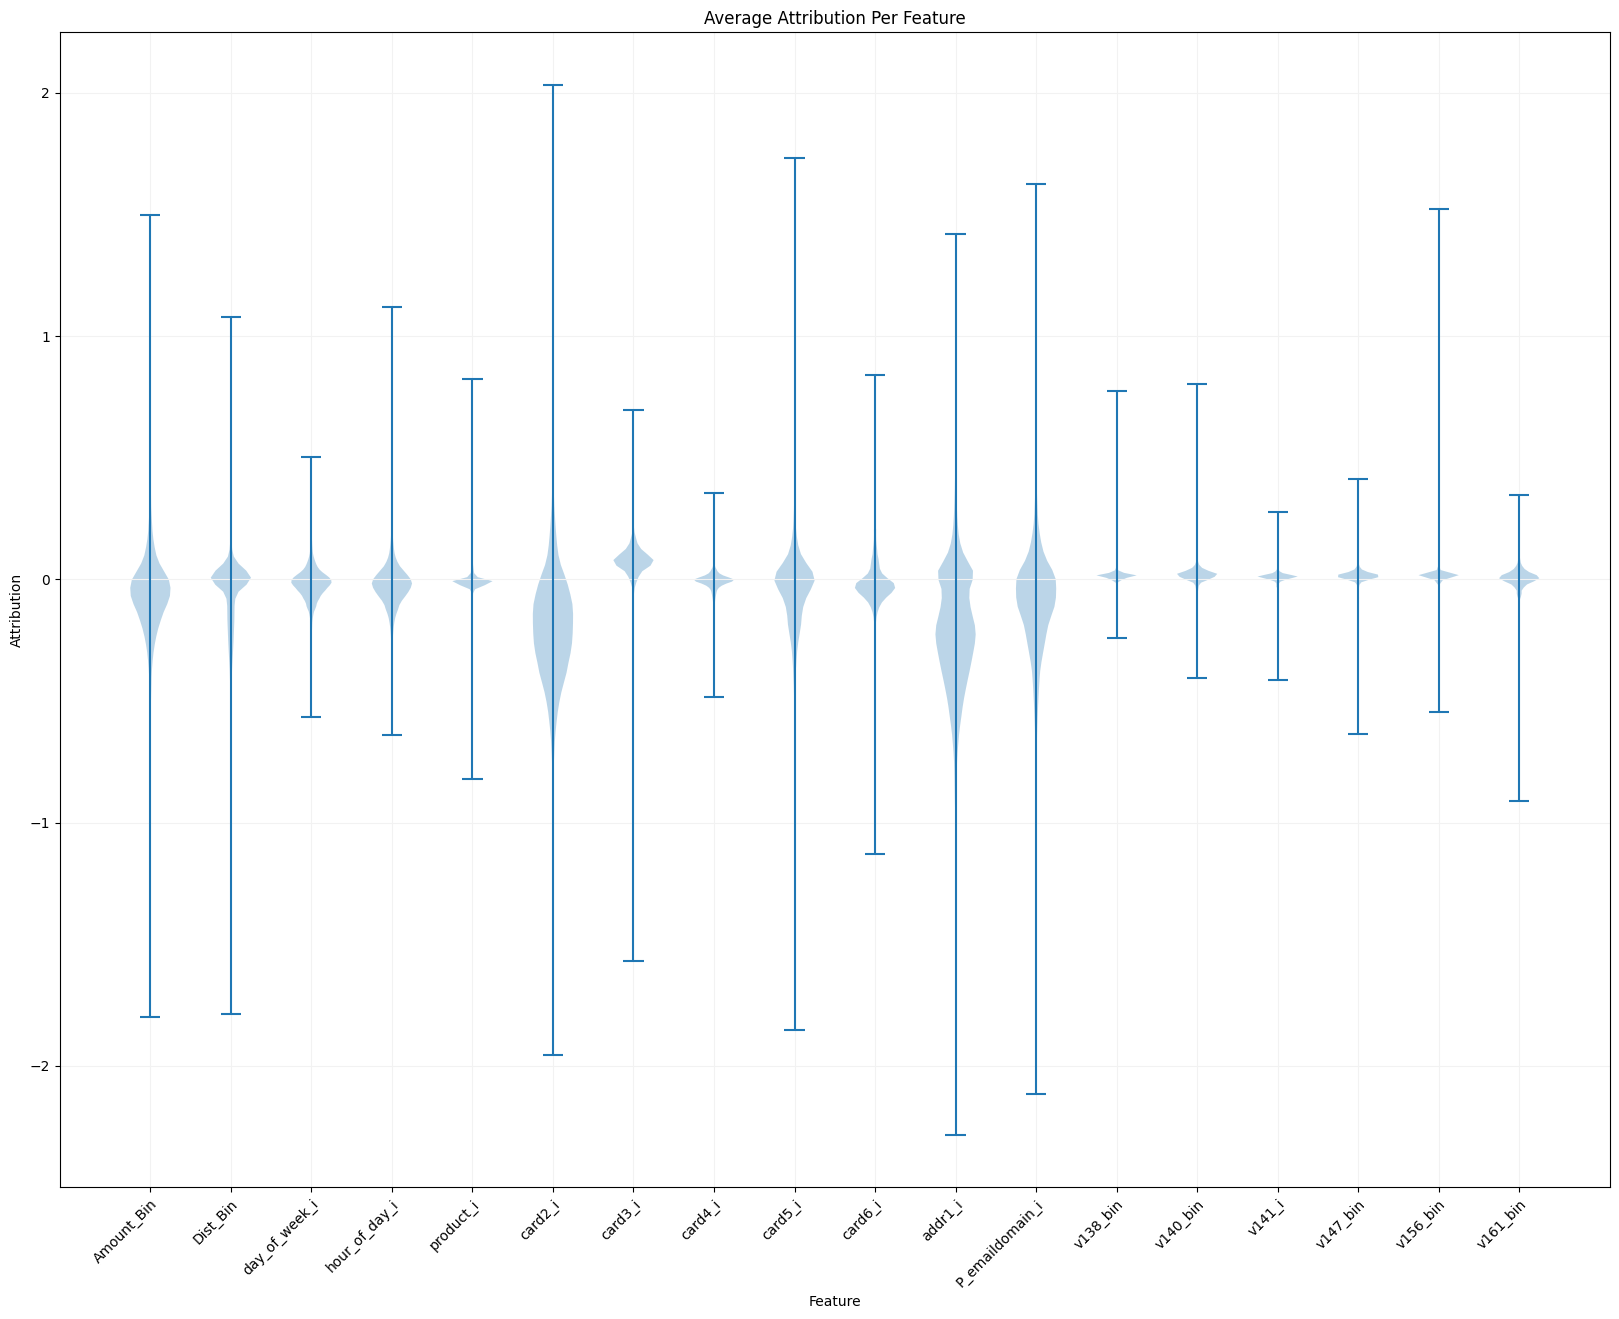

======== End group 14 =========


In [22]:
EPOCHS = 5

dfs = []

for i, b in enumerate(best_overall):
    print(f'======== Start group {i} =========')
    # Create a TensorDefinition for the NaN Group.
    td_vesta_group = ft.TensorDefinition(
        f'IEEE-vesta-group-{i}', [f for f in v_features if f.base_feature.name in b]
    )
    
    # Create Train and Validation Files.
    with en.EnginePandas(num_threads=1) as e:
        ti = e.np_from_csv(
            (td_categorical, td_vesta_group, td_label), 
            tr_train_file, inference=False
        )
    train, val, test = ti.split_sequential(50000,0)
    train_sampler = mp.TensorInstanceNumpyLabelSampler().over_sampler(train)
    train_ds = mp.TensorInstanceNumpyDataSet(train)
    val_ds   = mp.TensorInstanceNumpyDataSet(val)
    train_dl = train_ds.data_loader(torch.device('cpu'), 128, num_workers=2, sampler=train_sampler)
    val_dl   = val_ds.data_loader(torch.device('cpu'), 128, num_workers=2)
    mc = mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def)
    
    # Define Model
    class IEEEFeedForwardModel(mp.BinaryClassifier):
        def __init__(self, model_configuration: mp.ModelConfiguration):
            # Always call init, it is very important to correctly initialize the nn.Module
            super(IEEEFeedForwardModel, self).__init__(model_configuration)
        
            # Create the heads, they are the first layer of the NN.
            self.heads = self.create_heads(max_dims=30)
            heads_size = sum([h.output_size for h in self.heads])
        
            # Set of layers
            self.layers = mp.LinLayer(input_size=heads_size, layer_sizes=(128,64,64,32), dropout=0.0, bn_interval=2)
        
            # And a tail layer, for a binary classifier this is a Sigmoid.
            self.tail = self.create_tail(self.layers.output_size)

        # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
        def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
            o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
            o = self.layers(o)
            o = self.tail(o)
            return (o,)

    #Create a 'IEEEFeedForwardModel' instance
    model = IEEEFeedForwardModel(mc)
    
    # Train
    trainer = mp.Trainer(model, model_device, train_dl, val_dl)
    optimizer = mp.AdamWOptimizer(model, lr=3e-3)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
    )
    history = trainer.train(EPOCHS, optimizer, scheduler)
    
    # Test
    t = mp.Tester(model, torch.device(model_device), val_dl)
    results = t.test_results_binary()
    mplt.TestPlot.print_binary_classification_report(results)

    # Get and Save feaure attributions
    attr = cp.CaptumAttributions.get_attributions_binary(
        model, ti.target_tensor_def, model_device, IntegratedGradients, val_ds[:20000]
    )
    mplt.AttributionPlotBinary.overview(attr, fig_size=(20,15))
    df = pd.DataFrame(
    {
        'Feature': [f.name for f in attr.tensor_definition[1].features],
        'Max': attr.attributions[1].max(axis=0),
        'Min': attr.attributions[1].min(axis=0),
        'Std': attr.attributions[1].std(axis=0)
    })
    df
    dfs.append(df)
    print(f'======== End group {i} =========')

# Free up memory
del attr, results, t, trainer, model, ti, train, val, test, train_ds, train_dl, val_ds, val_dl
_ = gc.collect()

## Validate Performance

We are now in a position where we know how best V-Features contributed to the model and we can validate if adding them actual improves the model performance.

### Select best V-Features.
We are going to assume that the best features are the ones with the highest standard deviation between the attribution values.

In [23]:
x = pd.concat(dfs, axis=0).set_index('Feature')
x.sort_values('Std', ascending=False)

Max       Min       Std
Feature                               
v310_bin  1.126886 -1.649680  0.193608
v90_i     0.757504 -1.786919  0.166315
v10_i     0.771513 -1.823130  0.147083
v29_i     1.458096 -2.041902  0.146669
v317_bin  1.472974 -1.136828  0.139630
...            ...       ...       ...
v41_i     0.077131 -0.135905  0.007970
v112_i    0.315703 -0.193264  0.007344
v107_i    0.063988 -0.037247  0.005001
v120_i    0.038469 -0.151618  0.003805
v119_i    0.120817 -0.010043  0.001875

[148 rows x 3 columns]

### Plot the 100 highest variance features.

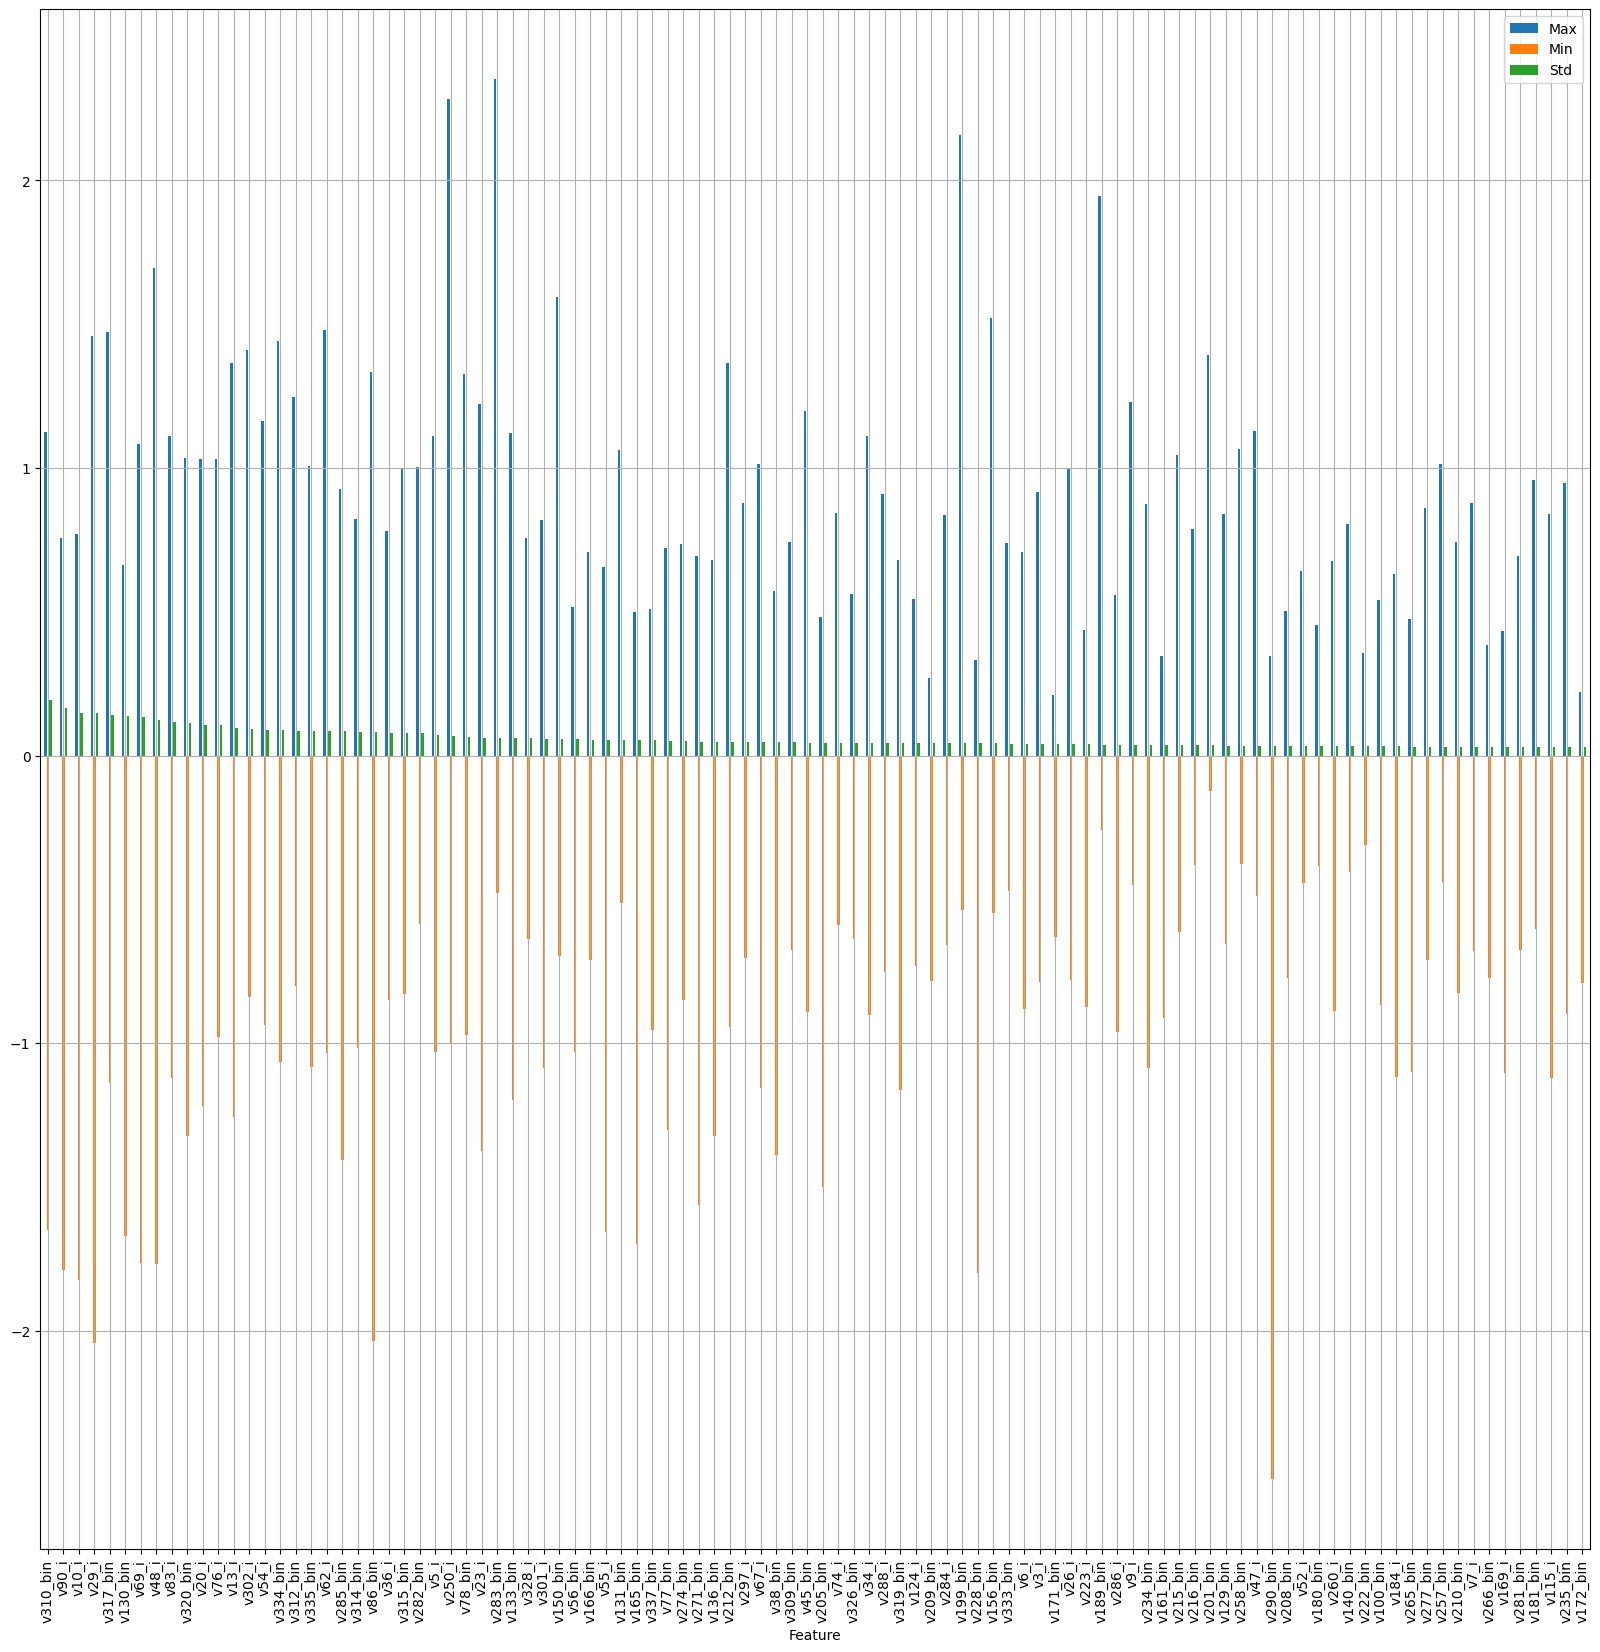

In [24]:
x.sort_values('Std', ascending=False)[:100].plot.bar(figsize=(20,20), grid=0.8);

### Display the 30 highest variance features

In [25]:
y=x.sort_values('Std', ascending=False).iloc[:30].index

In [26]:
list(y)

['v310_bin',
 'v90_i',
 'v10_i',
 'v29_i',
 'v317_bin',
 'v130_bin',
 'v69_i',
 'v48_i',
 'v83_i',
 'v320_bin',
 'v20_i',
 'v76_i',
 'v13_i',
 'v302_i',
 'v54_i',
 'v334_bin',
 'v312_bin',
 'v335_bin',
 'v62_i',
 'v285_bin',
 'v314_bin',
 'v86_bin',
 'v36_i',
 'v315_bin',
 'v282_bin',
 'v5_i',
 'v250_i',
 'v78_bin',
 'v23_i',
 'v283_bin']

### Add to the model. 
We are ready to add the 'best' V-features to the model, test and compare against the base case.

#### Create Data sets

In [27]:
top30_var = list(x.sort_values('Std', ascending=False).iloc[:30].index)

td_vesta_best_var = ft.TensorDefinition(
    'IEEE-V-Features-Best-Var', [f for f in v_features if f.name in  top30_var]
)

# Create a TensorInstance with the td_categorical only
with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv(
        (td_categorical, td_counts, td_timing, td_match, td_vesta_best_var, td_label), 
        tr_train_file, inference=False
    )
    
train, val, test = ti.split_sequential(100000,0)

train_sampler = mp.TensorInstanceNumpyLabelSampler().over_sampler(train)

train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)

train_dl = train_ds.data_loader(torch.device('cpu'), 128, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(torch.device('cpu'), 128, num_workers=2)

mc = mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def)

2023-06-01 10:58:21.296 eng1n3.common.engine           INFO     Start Engine...
2023-06-01 10:58:21.297 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-01 10:58:21.297 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-01 10:58:21.300 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../data/train_transaction.csv
2023-06-01 10:58:30.373 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-01 10:58:30.389 eng1n3.pandas.pandasengine     INFO     Converting All_r_1 to 6 numpy arrays


#### Create new model

In [28]:
class IEEEFeedForwardModel(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(IEEEFeedForwardModel, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads(max_dims=30)
        heads_size = sum([h.output_size for h in self.heads])
        
        # Set of layers
        self.layers = mp.LinLayer(input_size=heads_size, layer_sizes=(128,64,64,32), dropout=0.0, bn_interval=2)
        
        # And a tail layer, for a binary classifier this is a Sigmoid.
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        o = torch.cat([h(x[i]) for i, h in enumerate(self.heads)], dim=1)
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a 'IEEEFeedForwardModel' instance
model = IEEEFeedForwardModel(mc)
model

IEEEFeedForwardModel(
  Number of parameters : 150876. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(
      Name=ieee-categorical, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0): Embedding(30, 15)
          (1): Embedding(20, 10)
          (2): Embedding(8, 5)
          (3): Embedding(25, 12)
          (4): Embedding(6, 5)
          (5): Embedding(501, 30)
          (6): Embedding(115, 30)
          (7): Embedding(5, 5)
          (8): Embedding(120, 30)
          (9): Embedding(5, 5)
          (10): Embedding(333, 30)
          (11): Embedding(60, 30)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TensorDefinitionHead(
      Name=ieee-counts, lc=Categorical
      (embedding): Embedding(
        (embeddings): ModuleList(
          (0-13): 14 x Embedding(20, 10)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (2): TensorDefinitionHead(
    

### Find a good learning rate

In [ ]:
min_lr = 1e-5
max_lr = 1e-1
m_lr = IEEEFeedForwardModel(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, data_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 300)
mplt.TrainPlot.plot_lr(lrs);
del m_lr, o_lr, t_lr, lrs
_ = gc.collect()

#### Train

In [29]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)

# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=3e-3)

# Set-up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 4615/4615 [00:25<00:00, 180.71it/s, t_loss=0.0879, t_acc=0.966, v_loss=0.206, v_acc=0.942]     


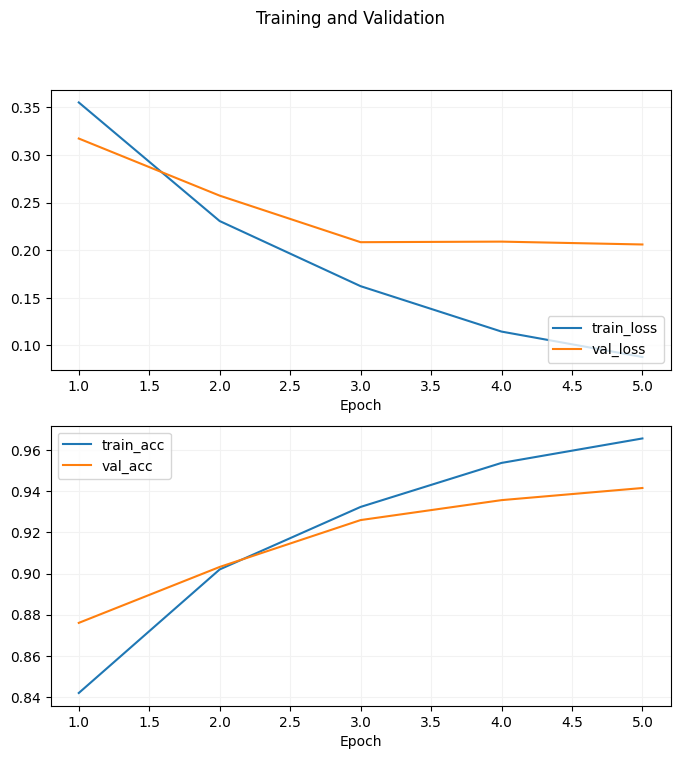

In [30]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

#### Test

Interestingly, this addition of the V-Feature made our model worse :( We need to compare this to the score from the previous notebook and compared to that, this model does quite a lot worse.

Testing in 782 steps: 100%|██████████████████| 782/782 [00:01<00:00, 443.60it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     96566
         1.0       0.32      0.60      0.41      3434

    accuracy                           0.94    100000
   macro avg       0.65      0.78      0.69    100000
weighted avg       0.96      0.94      0.95    100000


auc score : 0.8715
ap score  : 0.4778
-----------------------------------------------------


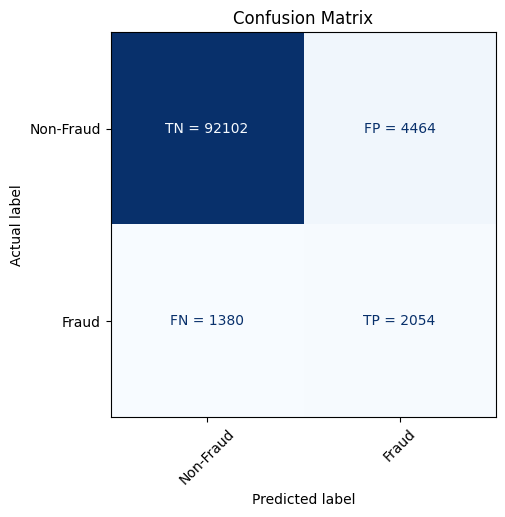

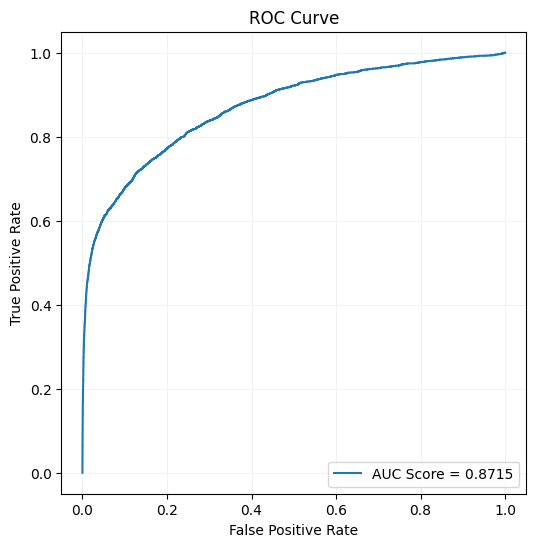

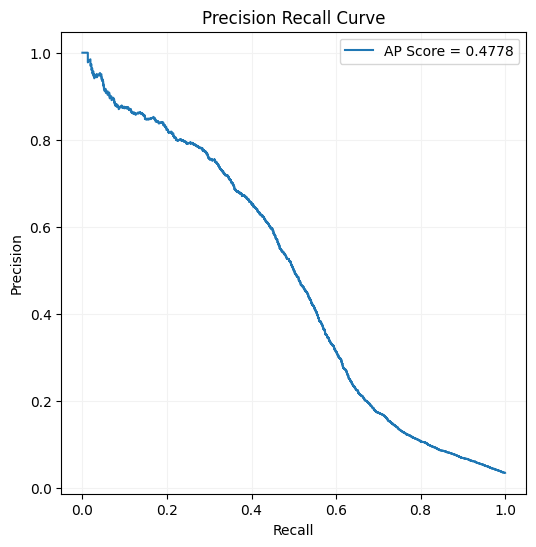

In [31]:
t = mp.Tester(model, torch.device(model_device), val_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5))
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6))
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))

In [33]:
    attr = cp.CaptumAttributions.get_attributions_binary(
        model, ti.target_tensor_def, model_device, IntegratedGradients, val_ds[:10000]
    )
    mplt.AttributionPlotBinary.overview(attr, fig_size=(20,15))
    df = pd.DataFrame(
    {
        'Feature': [f.name for f in attr.tensor_definition[1].features],
        'Max': attr.attributions[1].max(axis=0),
        'Min': attr.attributions[1].min(axis=0),
        'Std': attr.attributions[1].std(axis=0)
    })

RuntimeError: mat1 and mat2 must have the same dtype

# Conclusion
This was a very hefty notebook for no performance gain whatsoever. The fact we get no uplift might have various reasons. Some of which include.
- The approach might be wrong.
- The V-Features could be correlated to the base, count, delta-timing an match features. They may not bring a lot of new info the model did not have before.
- The model architecture. We can see that the output of the 'heads' layer is 728 and we cram those 728 nodes through a 128 nodes layer in the body (the linear layers). It may turn out that this body is too small to support the gigantic head.
- After adding the V-features we get quite a lot of features, there is the chance the model starts to overfit.

We'll try some notebooks with and without V-Features. But our overall inclination at present might be that they are not really worth the computational expense.